# Notizen

# Die zu betrachteten Attribute sind: 
1. Manufacturer name
2. A list of model names
3. Manufacturer part number (mpn)
4. European article number (ean) 
5. Digital and optical zoom
6. Camera dimensions
7. Weight
8. Product code
8. Sensor type
9. Price

# Datenqualitätprobleme 
1. Nicht alle Datensätze weisen die gleichen Attribute wie im Paper au
2. Bei einigen Datensätzen sind nur zwei oder drei vorhanden.
3. Einige Datensätze enthalten das Gesamtgewicht der Kamera, während andere nur das Gewicht ohne Batterie anzeigen
4. Manche führen nur den Begriff 'Zoom' auf, ohne 'optischen' oder 'digitalen' Zoom zu unterscheiden
5. Wiederum andere spezifizieren lediglich den optischen Zoom, wie beispielsweise 'wexphotographic'
6. In manchen Fällen wird nur die Videoauflösung angegeben, während bei anderen nur die Fotoauflösung vorhanden   ist.

# Import libraries

In [1]:
import re
import math
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# Help functions

In [105]:
# Function to convert mixed units to pounds and remove "lbs" suffix
def convert_to_pounds(weight_str):
    if pd.isna(weight_str):
        return weight_str  # Return NaN as is
    if 'oz' or 'Oz' in weight_str:
        ounces = float(weight_str.split(' ')[0])  # Extract the number of ounces
        pounds = ounces / 16.0  # Convert ounces to pounds (1 pound = 16 ounces)
        return f'{pounds:.2f}'  # Remove "lbs" suffix
    elif 'lbs' in weight_str:
        return weight_str.split(' ')[0]  # Remove "lbs" suffix
    else:
        return 'Invalid'
    
    
# Function to consolidate weight columns 
def consolidate_weights(row):
    for col in row.index:
        if not pd.isna(row[col]) and 'weight' in col:
            return row[col]
    return np.nan


# Function to convert non-numeric characters to numeric and coerce to NaN if errors occur
def clean_numeric_columns(df, columns):
    df[columns] = df[columns].replace(r'[^0-9.]', '', regex=True).apply(pd.to_numeric, errors='coerce')
    return df

    
def consolidate_dimensions(row):
    for col in row.index: 
        if not pd.isna(row[col]) and 'dimensions' in col: 
            return row[col]
    return np.nan
    

def convert_to_grams(weight_str):
    if pd.isna(weight_str):
        return weight_str # Retrun NaN as is 
    if 'oz' in weight_str or 'Oz' in weight_str: 
        ounces = float(weight_str.split(' ')[0]) # Extract the number of ounces 
        return ounces * 28.3495 # convert ounces to grams 
    elif 'lb' in weight_str or 'pounds' in weight_str:
        pounds = float(weight_str.split(' ')[0])
        return  pounds * 453.592  # convert ounces to grams 
    
    elif 'Kg' in weight_str or 'kg' in weight_str:
        kgrams = float(weight_str.split(' ')[0])
        return kgrams * 1000 
    else:
        processed_string = re.sub(r'gr', '', weight_str)  # Removes the word "gr" as a whole word
        processed_string = processed_string.replace('"', '')  # Removes double quotes ("")
        processed_string = processed_string.replace('\\','') # Replace backslah (\) with empty string in the 'extracted_weight' column 
        return processed_string
        
def extract_dimensions(dimensions_str, dimension,split_num):
    if pd.isna(dimensions_str):
        return dimensions_str
    splitt_array = dimensions_str.replace('″', '').strip().split('x')
    if 'cm' in dimensions_str:
        if dimension == 'width':
            width = splitt_array[split_num] 
            return width
        if dimension == 'height':
            width = splitt_array[split_num] 
            return width
        if dimension == 'depth':
            width = splitt_array[split_num] 
            return width
    elif 'mm' in dimensions_str:
         if len(splitt_array) >= 3: 
             if dimension == 'width':
                width = splitt_array[split_num] + ' mm'
                return width
             if dimension == 'height':
                width = splitt_array[split_num] + ' mm'
                return width
             if dimension == 'depth':
                width = splitt_array[split_num] + ' mm'
                return width
    
    elif 'inches' in dimensions_str.lower():
          if len(splitt_array) >= 3: 
             if dimension == 'width':
                width = splitt_array[split_num] + ' in'
                return width
             if dimension == 'height':
                width = splitt_array[split_num] + ' in'
                return width
             if dimension == 'depth':
                width = splitt_array[split_num] + ' in'
                return width   
    
    else:
        return 'Invalid'
    
    
def extract_resolutions(resolution_str, resolution_dim):
    if pd.isna(resolution_str):
        return resolution_str
    splitt_array = resolution_str.split('x')
    if resolution_dim == 'x':
        return splitt_array[0]
    else:
        return splitt_array[1]
    
        
    
    
def convert_mm_to_cm(dimension_str):
    dimension_str = str(dimension_str)
    if pd.isna(dimension_str): 
        return dimension_str
    elif 'cm' in dimension_str:
        dimension_str_splitted = dimension_str.split(' ')
        return dimension_str_splitted[0]
    elif not any(char.isdigit() for char in dimension_str):
        return 0
    else:
         # Remove non-numeric characters and convert to float
         numeric_value = float(''.join(char for char in dimension_str if char.isdigit() or char == '.'))
         # Check if 'mm' is present and convert to centimeters
         if 'mm' in dimension_str:
             numeric_value /= 10.0
         
         return numeric_value
    

def convert_to_cm(dim_str,unit=None):
    # Conversion factor from inches to centimeters
    cm_per_inch = 2.54 
    
    if not pd.isna(dim_str):
        dim_str = dim_str.strip()
    
    if pd.isna(dim_str):
        return dim_str
    
    
    elif 'mm' in dim_str:
        dimension_str_splitted = dim_str.split(' ')
        return float(dimension_str_splitted[0]) / 10.0
    
    elif 'in' in dim_str or unit=='inch':
        # Convert inches to centimeters
        cm = float(dim_str.split(' ')[0]) * cm_per_inch
        return cm
    elif 'cm' in dim_str:
        dimension_str_splitted = dim_str.split(' ')
        return dimension_str_splitted[0]
        
    else: 
        processed_string = re.sub(r'[^\d.]', '', dim_str)
        return processed_string

        
   

# Define a function to extract values for 'd,' 'w,' and 'h' from flexible patterns
def extract_values(text):
    if pd.isna(text): 
        return text
    
    values = {'d': None, 'w': None, 'h': None}
    
    # Find all numeric values and labels for 'd,' 'w,' and 'h'
    matches = re.findall(r'(\d+\.\d+|\d+)[^\d]*(d|w|h)', text)
   
    for value, label in matches:
        values[label] = value
    
    return values


# Function to conditionally assign values based on specific strings
def assign_value(text):
    if pd.isna(text):
        return text
    if 'CMOS' in text:
        return 'CMOS'
    elif 'MOS' in text:
        return 'MOS'
    elif 'CCD' in text:
        return 'CCD'
    else:
        return math.nan
    
    

def check_and_create_columns(df, column_list):
    missing_columns = [col for col in column_list if col not in df.columns]
    for col in missing_columns:
        df[col] = "/"
    
    return df 


# Import data

In [179]:
data = pd.read_csv('data_cleaned_very_new.csv')
# Create a new column 'row_key' with numbers starting from 1 for each source
#data['row_key'] = data.groupby('source').cumcount() + 1

/var/folders/m5/zq5xgdts1qb357rw5h3mg1fm0000gn/T/ipykernel_4157/1581690389.py:1: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,15,17,19,20,21,26,27,30,33,34,35,36,38,39,40,41,42,45,46,47,48,50,51,52,53,55,56,57,58,59,60,61,62,63,65,66,67,68,69,70,71,72,73,74,75,77,78,79,80,81,82,83,84,85,86,87,88,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,116,117,118,119,120,121,122,123,124,125,126,127,128,129,131,134,135,136,137,138,139,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,197,198,199,200,201,202,203,204,205,206,209,210,211,212,214,215,216,217,218,219,220,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,245,246,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,281,282,284

# Extract Ground Truth Data from the Data

In [27]:
data['source'].unique()
sources_pairs = []

for source_1 in data['source'].unique():
    print(source_1)
    for source_2 in data['source'].unique():
        sources_pair_str_1 = source_1 + '_' + source_2
        sources_pair_str_2 = source_2 + '_' + source_1 
        if (sources_pair_str_1 in sources_pairs) or (sources_pair_str_2 in sources_pairs):
            pass
        else:
            sources_pairs.append(sources_pair_str_1)
            sources_pairs.append(sources_pair_str_2)
            source_1_row_keys_true_matches = []
            source_2_row_keys_true_matches = []
            source_1_rec_ids_true_matches = []
            source_2_rec_ids_true_matches = []
            source_1_recIds =  data.loc[data['source'] == source_1]['recId'].values
            source_2_recIds =  data.loc[data['source'] == source_2]['recId'].values
            source_1_rowkeys = data.loc[data['source'] == source_1]['row_key'].values
            source_2_rowkeys = data.loc[data['source'] == source_2]['row_key'].values
            is_matched = []
            
            for source_1_recId, row_key_1 in zip(source_1_recIds, source_1_rowkeys):
                for source_2_recId, row_key_2 in zip (source_2_recIds, source_2_rowkeys):
                    if source_1_recId == source_2_recId:
                        source_1_row_keys_true_matches.append(row_key_1)
                        source_2_row_keys_true_matches.append(row_key_2)
                        source_1_rec_ids_true_matches.append(source_1_recId)
                        source_2_rec_ids_true_matches.append(source_2_recId)
                        is_matched.append(1)
                    else:
                        pass
            
            result_dict = {'source_1_rowkeys':source_1_row_keys_true_matches, 'source_2_rowkeys': source_2_row_keys_true_matches,
                           'source_1_rec_ids': source_1_rec_ids_true_matches, 'source_2_rec_ids': source_2_rec_ids_true_matches,
                           'is_match': is_matched}
            dataframe = pd.DataFrame(result_dict)
            dataframe.to_csv(source_1 + '_' + source_2 + '.csv')
        
    

www.wexphotographic.com
www.garricks.com.au
www.ilgs.net
buy.net
www.henrys.com
www.ukdigitalcameras.co.uk
www.camerafarm.com.au
www.price-hunt.com
cammarkt.com
www.flipkart.com
www.buzzillions.com
www.cambuy.com.au
www.pricedekho.com
www.gosale.com
www.canon-europe.com
www.walmart.com
www.shopmania.in
www.ebay.com
www.priceme.co.nz
www.eglobalcentral.co.uk
www.pcconnection.com
www.shopbot.com.au
www.mypriceindia.com


# TO consider Attributes

### Those are the following attribute that need to be taken into consideration , when doing the comparisons between the record-pairs:

1. Modell-liste (famer_model_list)
2. MPN-Liste    (famer_mpn_list)
3. EAN-Liste    (famer_ean_list)
4. product-name (famer_product_name)
5. Digital-zoom (famer_digital_zoom)
6. optischer-zoom (famer_optical_zoom)
7. Breite (famer_width in cm)
8. Höhe   (famer_height in cm)
9. Gewicht (famer_weight in g)
10. Sensor-typ (famer_image_sensor)


In [16]:
columns_to_order = ['key','row_key', 'source','famer_model_list','famer_model_no_list','famer_mpn_list','famer_ean_list', 
                    'famer_product_name', 'famer_digital_zoom','famer_optical_zoom', 'famer_width', 'famer_height',
                    'famer_weight', 'famer_sensor','famer_brand_list']


path_to_help_data = '/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/help_data/'
path_to_cleaned_data = '/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/cleaned_data/'


# Define cleaning functions for each source with their specific important features
def clean_priceme_data(data):
    data = check_and_create_columns(data, columns_to_order)
    data = data[columns_to_order]
    data.to_csv(path_to_cleaned_data + 'priceme_data_cleaned.csv', index=False)

    
    
def clean_buy_data(data):
    # Cleaning logic for buy.net data using specific important features
    numeric_columns = ['digital zoom', 'optical zoom', 'height', 'width']
    data = clean_numeric_columns(data, numeric_columns)

    # Convert weight from grams to pounds
    data['weight'] = data['weight'].apply(convert_to_pounds)

    buy_data_new_columns_names = {
    'weight': 'famer_weight', 
    'digital zoom': 'famer_digital_zoom',
    'optical zoom': 'famer_optical_zoom', 
    'height': 'famer_height', 
    'width': 'famer_width',
    'image sensor': 'famer_sensor'
    }

    data.rename(columns=buy_data_new_columns_names, inplace=True)
    
    # Check and create missing columns
    data = check_and_create_columns(data, columns_to_order)

    # Save cleaned buy data to CSV
    data.to_csv(path_to_cleaned_data + 'buy_data_cleaned.csv', index=False)
    
    

def clean_buzzillions_data(data):
    # Clean numeric columns
    numeric_columns = ['optical zoom', 'digital zoom', 'width', 'height', 'megapixels']
    data = clean_numeric_columns(data, numeric_columns)

    buzzillions_data_new_column_names = {
       'optical zoom': 'famer_optical_zoom',
       'digital zoom': 'famer_digital_zoom',
       'height': 'famer_height',
       'width' : 'famer_width',
       'sensor': 'famer_sensor',
       'megapixels': 'famer_megapixels'
   }
    
    data.rename(columns=buzzillions_data_new_column_names, inplace=True)
    
    # Check and create missing columns
    data = check_and_create_columns(data, columns_to_order)

    data = data[columns_to_order] 
    
    # Save cleaned buzzillions data to CSV
    data.to_csv(path_to_cleaned_data + 'buzzillions_data_cleaned.csv', index=False)
    
    

    
def clean_eglobalcentral_data(data):

    # notices: 
    # Width in cm 
    # height in cm
    
    # Clean numeric columns
    numeric_columns = ['optical zoom', 'digital zoom']
    clean_numeric_columns(data, numeric_columns)

    # Consolidate weight and dimensions columns
    data['weight'] = data.apply(consolidate_weights, axis=1)
    data['dimensions'] = data.apply(consolidate_dimensions, axis=1)

    #eglobalcentral_data_cleaned['dimensions'] = eglobalcentral_data_cleaned['dimensions'].str.replace(r'\([^)]*\)', '', regex=True)
    #eglobalcentral_data_cleaned['dimensions'] = eglobalcentral_data_cleaned['dimensions'].str.replace(r'\([^)]*\)', '', regex=True)

    # Extract the width and height dimensions
    data['extracted_width'] = data['dimensions'].apply(lambda x: extract_dimensions(x, 'width',0))
    data['extracted_height'] = data['dimensions'].apply(lambda x: extract_dimensions(x, 'height',1))
     
    # Correct some spellings in the Width and height columns 
    data.loc[data['famer_product_name'] == 'panasonichcmdh2', 'extracted_width'] = np.nan 
    data.loc[data['famer_product_name'] == 'panasonichcmdh2', 'extracted_height'] = np.nan


    # Convert the dimensions from mm to cm
    data['extracted_width'] = data['extracted_width'].str.replace('mm','')
    data['extracted_width'] = data['extracted_width'].apply(convert_mm_to_cm)

    data['extracted_height'] = data['extracted_height'].str.replace('mm','')
    data['extracted_height'] = data['extracted_height'].apply(convert_mm_to_cm)

    eglobalcentral_data_new_columns_names = { 
        'digital zoom': 'famer_digital_zoom',
        'optical zoom': 'famer_optical_zoom',
        'weight': 'famer_weight',
        'extracted_width': 'famer_width',
        'extracted_height': 'famer_height',
        'Auflösung_x': 'famer_Auflösung_x',
        'Auflösung_y': 'fmaer_Auflösung_y',
        'famer_sensortype':'famer_sensor'
    }

    data.rename(columns=eglobalcentral_data_new_columns_names, inplace=True)
    
    print("The avaliable columns now are {} ".format(data.columns))
    # Drop some unnecessary columns
    #columns_to_drop = ['dimensions w x h x d', 'dimensions','famer_Auflösung_x','fmaer_Auflösung_y','famer_resolution_to','famer_resolution_from']
    #data.drop(columns=columns_to_drop, axis=1, inplace=True)


    # Check and create the missing columns
    data = check_and_create_columns(data, columns_to_order)

    # Reorder the columns in the right way
    data = data[columns_to_order] 

    print("before saving the data")
    # Save cleaned data to CSV
    data.to_csv(path_to_cleaned_data + 'eglobalcentral_data_cleaned.csv', index=False)
    
    
    
def clean_price_hunt_data(data):
    
    # Notices:
    # Width in cm 
    # Height in cm 
    # Weight in g
    
    
    # read a dataframe that contains manually cleaned infos about the weights
    cleaned_weight_dataframe = pd.read_csv(path_to_help_data + 'price_hunt_cleaned_weight_cleaned.csv', sep=";")
    
    # Merge dataframes on the common column
    all_relevant_data = pd.merge(data, cleaned_weight_dataframe[['weight_with_battery', 'weight_without_battery','famer_product_name']], on='famer_product_name', how='left')

    
    # Extract the dimensions_values from the dimensions column
    all_relevant_data['extracted_dimension_values'] = all_relevant_data['dimensions'].apply(extract_values)

    
    # Extract the width, height and depth values from the dimensions values
    all_relevant_data['w_value'] = all_relevant_data['extracted_dimension_values'].apply(lambda x: x.get('w') if isinstance(x, dict) else None)
    all_relevant_data['h_value'] = all_relevant_data['extracted_dimension_values'].apply(lambda x: x.get('h') if isinstance(x, dict) else None)
    all_relevant_data['d_value'] = all_relevant_data['extracted_dimension_values'].apply(lambda x: x.get('d') if isinstance(x, dict) else None)
    
    # Convert the width and height values into cm
    all_relevant_data['w_value'] = all_relevant_data['w_value'].apply(convert_mm_to_cm)
    all_relevant_data['h_value'] = all_relevant_data['h_value'].apply(convert_mm_to_cm)
    
    # Fill NaN values in the "weight" column
    all_relevant_data['weight_with_battery'] = all_relevant_data['weight_with_battery'].fillna(all_relevant_data['weight_without_battery'])


    # Format the width , height and weight values to two decimal places
    all_relevant_data['w_value'] =  round(all_relevant_data['w_value'],2)
    all_relevant_data['h_value'] = round(all_relevant_data['h_value'],2)
    all_relevant_data['weight_with_battery'] = round(all_relevant_data['weight_with_battery'],2)
    
    
    #price_hunt_data_cleaned['famer_model_no_list'] = price_hunt_data_cleaned['famer_model_list'].str.replace(r'\D', '', regex=True)


    price_hunt_data_new_columns_names = { 
        'digital zoom': 'famer_digital_zoom',
        'optical zoom': 'famer_optical_zoom',
        'weight_with_battery': 'famer_weight',
        'weight_without_battery':'famer_weight_without_battery',
        'w_value': 'famer_width',
        'h_value': 'famer_height',
        'sensor type': 'famer_sensor',
    }
    # Rename the relevant columns 
    all_relevant_data.rename(columns = price_hunt_data_new_columns_names, inplace=True)


    # Extract the values of the digital and optical zoom 
    all_relevant_data['famer_digital_zoom'] = all_relevant_data['famer_digital_zoom'].str.extract(r'([\d.]+)\s*x')
    all_relevant_data['famer_optical_zoom'] = all_relevant_data['famer_optical_zoom'].str.extract(r'([\d.]+)\s*x')
    
    # Create a new column 'row_number' representing the row numbers
    #price_hunt_data_cleaned.insert(0, 'row_key', price_hunt_data_cleaned.reset_index().index + 1)

    # Check and create missing columns
    all_relevant_data = check_and_create_columns(all_relevant_data, columns_to_order)

    all_relevant_data = all_relevant_data[columns_to_order] 

    all_relevant_data.to_csv(path_to_cleaned_data + 'price_hunt_cleaned.csv')
    
    
def clean_shopbot_data(data):
    
    # Extract dimensions (width, height, depth) from the 'dimensions' column
    data['width'] = data['dimensions'].apply(lambda x: extract_dimensions(x, 'width',0))
    data['height'] = data['dimensions'].apply(lambda x: extract_dimensions(x, 'height',1))
    data['depth'] = data['dimensions'].apply(lambda x: extract_dimensions(x, 'depth',2))

    # Clean extracted dimension columns
    dimension_columns = ['width', 'height', 'depth', 'zoom', 'weight']
    data[dimension_columns] = data[dimension_columns].replace(r'[^0-9.]', '', regex=True)
    
    # Convert the dimension values from mm to cm
    data['width'] = data['width'].apply(convert_mm_to_cm)
    data['height'] = data['height'].apply(convert_mm_to_cm)

    shopbot_new_column_names = {  
        'weight': 'famer_weight',
        'width': 'famer_width',
        'height': 'famer_height',
        'weight': 'famer_weight',
        'zoom': 'famer_optical_zoom',
    }
    data.rename(columns=shopbot_new_column_names, inplace=True)

    # List of column names to drop
    columns_to_drop = ['dimensions', 'video resolution', 'depth']

    # Drop the specified columns
    data.drop(columns=columns_to_drop, axis=1, inplace=True)

    # Check and create missing columns
    data = check_and_create_columns(data, columns_to_order)

    data = data[columns_to_order] 
    
    # Save cleaned data to CSV
    data.to_csv(path_to_cleaned_data + 'shopbot_data_cleaned.csv', index=False)
    
    

def clean_wexphotographic_data(data):
    # Extract dimensions (width, height, depth) from the 'size' column
    data['width'] = data['size'].apply(lambda x: extract_dimensions(x, 'width',0))
    data['height'] = data['size'].apply(lambda x: extract_dimensions(x, 'height',1))
    data['depth'] = data['size'].apply(lambda x: extract_dimensions(x, 'depth',2))

    # Convert dimensions from mm to cm
    data['width'] = data['width'].apply(convert_mm_to_cm)
    data['height'] = data['height'].apply(convert_mm_to_cm)

    # Clean extracted numeric columns
    dimension_columns = ['width', 'height','weight g']
    data = clean_numeric_columns(data, dimension_columns)


    wexphotographic_data_new_column_names = {  
        'optical zoom x': 'famer_optical_zoom',
        'weight g': 'famer_weight',
        'sensor type': 'famer_sensor',
        'width': 'famer_width',
        'height': 'famer_height'
    }

    data.rename(columns=wexphotographic_data_new_column_names, inplace=True)

    # List of column names to drop
    columns_to_drop = ['size', 'resolution', 'depth']

    # Drop the specified columns
    data.drop(columns=columns_to_drop, axis=1, inplace=True)

    # Round numeric columns to two decimal digits after comma
    data['famer_width'] =  round(data['famer_width'],2)
    data['famer_height'] = round(data['famer_height'],2)
    data['famer_weight'] = round(data['famer_weight'],2)



    # Check and create missing columns
    data = check_and_create_columns(data, columns_to_order)

    # Reorder the columns
    data = data[columns_to_order] 

    # Save cleaned data to CSV
    data.to_csv(path_to_cleaned_data + 'wexphotographic_data_cleaned.csv', index=False)
    
    
    
def clean_garricks_data(data):
    garricks_data_new_column_names = {  
    'weight': 'famer_weight',
    'sensor details': 'famer_sensor'
    }

    data.rename(columns=garricks_data_new_column_names, inplace=True)

    # List of column names to drop
    columns_to_drop = ['zoom range', 'resolution']

    # Drop the specified columns
    data.drop(columns=columns_to_drop, axis=1, inplace=True)

    data['famer_weight'] = data['famer_weight'].str.extract(r'([\d.]+)\s*g')

    # Check and create missing columns
    data = check_and_create_columns(data, columns_to_order)

    data = data[columns_to_order] 
    data.to_csv(path_to_cleaned_data + 'garricks_data_cleaned.csv',index=False)
    
    


def clean_pcconnection_data(data):
    data['extracted_values'] = data['physical dimensions'].apply(extract_values)

    # Extract values for 'd,' 'w,' and 'h' from the extracted dictionary
    #data['d_value'] = data['extracted_values'].apply(lambda x: x.get('d') if isinstance(x, dict) else None)
    data['w_value'] = data['extracted_values'].apply(lambda x: x.get('w') if isinstance(x, dict) else None)
    data['h_value'] = data['extracted_values'].apply(lambda x: x.get('h') if isinstance(x, dict) else None)

    data['actual weight'] = data['actual weight'].apply(convert_to_grams)


    pcconnection_data_new_column_names = {  
        'digital zoom': 'famer_digital_zoom',
        'optical zoom': 'famer_optical_zoom',
        'optical sensor type': 'famer_sensor',
        'actual weight': 'famer_weight',
        'h_value': 'famer_height',
        'w_value': 'famer_width'
    }

    data.rename(columns=pcconnection_data_new_column_names, inplace=True)


    # List of column names to drop
    #columns_to_drop = ['physical dimensions', 'd_value','extracted_values']

    # Drop the specified columns
    #data.drop(columns=columns_to_drop, axis=1, inplace=True)

    # Check and create missing columns
    data = check_and_create_columns(data, columns_to_order)

    data = data[columns_to_order]

    data['famer_digital_zoom'] = data['famer_digital_zoom'].str.replace('X','')
    data['famer_optical_zoom'] = data['famer_optical_zoom'].str.replace('X','')


    data.loc[data['famer_product_name']=='canoneos70d', 'famer_optical_zoom'] = np.nan
    data.to_csv(path_to_cleaned_data + 'pcconnection_data_cleaned.csv')
    
    

    
def clean_cammarkt_data(data):
    # Extract weight values before the first slash using regular expression
    data['extracted_weight'] = data['weight'].str.split('\\', n=1).str[0]
    # Remove "[" and double qoute at the beginning of the strings
    data['extracted_weight'] = data['extracted_weight'].str.replace(r'^\["', '', regex=True)
    data.loc[data['extracted_weight'] == '1', 'extracted_weight'] = data['weight'].str.split(',').str[1].str.replace(r'[\"\']', '').str.strip()
    data['extracted_weight'] = data['extracted_weight'].apply(convert_to_grams)

    #width
    data['extracted_width'] = data['width'].str.split('\\', n=1).str[0]
    data['extracted_width'] = data['extracted_width'].str.replace(r'^\["', '', regex=True)
    data['extracted_width'] = data['extracted_width'].apply(convert_to_cm)

    #height
    data['extracted_height'] = data['height'].str.split('\\', n=1).str[0]
    data['extracted_height'] = data['extracted_height'].str.replace(r'^\["', '', regex=True)
    data['extracted_height'] = data['extracted_height'].apply(convert_to_cm)

    #optical zoom
    data['extracted_optical_zoom'] = data['famer_opticalzoom']

    # digital zoom
    data['extracted_digital_zoom'] = data['digital zoom'].str.extract(r'(\d+)x')

    # sensor type
    data['extracted_sensor_typ'] = data['image sensor type'].str.split('\\', n=1).str[0].str.strip()

    # Columns to be removed
    #columns_to_be_removed = ['famer_width','famer_height', 'camera resolution', 'width','height','optical zoom', 'image sensor type', 
    #                         'camera resolution', 'image resolutions', 'optical zoom','digital zoom','weight','famer_opticalzoom','famer_weight',
    #                        'megapixels']

    # Remove the specified columns
    #cammarkt_data_non_null_columns.drop(columns= columns_to_be_removed, axis=1, inplace=True)


    cammarkt_data_new_column_names = {  
        'extracted_weight': 'famer_weight',
        'extracted_width': 'famer_width',
        'extracted_height': 'famer_height',
        'extracted_optical_zoom': 'famer_optical_zoom',
        'extracted_digital_zoom': 'famer_digital_zoom',
        'extracted_sensor_typ': 'famer_sensor'
    }

    data.rename(columns=cammarkt_data_new_column_names, inplace=True)

    # Check and create missing columns
    data = check_and_create_columns(data, columns_to_order)

    data = data[columns_to_order]
   
    data.to_csv(path_to_cleaned_data + 'cammarkt_data_cleaned.csv')
    
    
    
def clean_gosale_data(data):
    
    data['famer_weight'] = data['famer_weight'] * 453.592
    gosale_data_new_column_names = {  
        'famer_opticalzoom': 'famer_optical_zoom'
    }

    data.rename(columns=gosale_data_new_column_names, inplace=True)

    # Remove the specified columns
    data.drop(columns= ['product number mpn'], axis=1, inplace=True)


    # Check and create missing columns
    data = check_and_create_columns(data, columns_to_order)

    data = data[columns_to_order]
    
    data.to_csv(path_to_cleaned_data + 'gosale_data_cleaned.csv')
    
    

def clean_henrys_data(data):
    data['famer_opticalzoom'] = np.where(data['famer_product_name']== 'fujifilmxf1', 4, data['famer_opticalzoom'])


    # width
    data['width'] = data['dimensions wxhxd'].apply(lambda x: extract_dimensions(x,'width',0))
    data['width'] = data['width'].str.replace('mm',' mm')
    data.loc[data['famer_product_name'] == 'panasonichxa500h', 'width'] = 26.5
    data.loc[data['famer_product_name'] == 'samsungwb50f', 'width'] = np.nan
    data['width'] = data['width'].apply(convert_mm_to_cm)
    #height
    data['height'] = data['dimensions wxhxd'].apply(lambda x: extract_dimensions(x,'height',1))
    data['height'] = data['height'].str.replace('mm',' mm')
    data.loc[data['famer_product_name'] == 'panasonichxa500h', 'height'] = 68.5
    data.loc[data['famer_product_name'] == 'samsungwb50f', 'height'] = np.nan
    data['height'] = data['height'].apply(convert_mm_to_cm)

    # weight
    data['extracted_weight'] = data['weight'].str.extract(r'([\d.]+)\s*g')
    # digital zoom
    data['digital zoom'] = data['digital zoom'].str.replace('x','')
    # sensor type
    data['sensor type'] = data['sensor typesize'].apply(assign_value)


    # Columns to be removed
    #columns_to_be_removed = ['weight','dimensions wxhxd', 'sensor typesize', 'video resolution','famer_weight','optical zoom']

    # Remove the specified columns
    #henrys_data_non_null_columns.drop(columns= columns_to_be_removed, axis=1, inplace=True)



    henrys_data_new_column_names = {  
        'digital zoom': 'famer_digital_zoom',
        'width': 'famer_width',
        'height': 'famer_height',
        'extracted_weight': 'famer_weight',
        'sensor type': 'famer_sensor',
        'famer_opticalzoom': 'famer_optical_zoom'
    }

    data.rename(columns=henrys_data_new_column_names, inplace=True)

    # Check and create missing columns
    data = check_and_create_columns(data, columns_to_order)

    data = data[columns_to_order]
   
    data['famer_digital_zoom'] = data['famer_digital_zoom'].replace('ma. 5',5)
    data.loc[data['famer_product_name']=='sigmadp3', 'famer_digital_zoom'] = np.nan
    data.loc[data['famer_product_name']== 'fujifilmxf1', 'famer_digital_zoom'] = 2
    data.loc[data['famer_product_name']== 'leicaxvarioapscdigitalcamera18430', 'famer_digital_zoom'] = np.nan
    data.loc[data['famer_product_name']== 'panasonicdmcfz70', 'famer_digital_zoom'] = 5
    data.loc[data['famer_product_name']== 'ricohgrwideanglelcd175743', 'famer_digital_zoom'] = np.nan
    data.loc[data['famer_product_name']== 'ricohgrlimitededwhoodstrapcase175823', 'famer_digital_zoom'] = np.nan
    data.loc[data['famer_product_name']== 'nikoncoolpixp7800', 'famer_digital_zoom'] = 4
    data.loc[data['famer_product_name']== 'fujifilmx100t', 'famer_digital_zoom'] = np.nan
    data.loc[data['famer_product_name']== 'leicax2', 'famer_digital_zoom'] = np.nan
    data.loc[data['famer_product_name']== 'sigmadp1', 'famer_digital_zoom'] = np.nan
    data.loc[data['famer_product_name']== 'fujifilmx100t', 'famer_digital_zoom'] = np.nan
    data.loc[data['famer_product_name']== 'sigmadp2', 'famer_digital_zoom'] = np.nan


    data.to_csv(path_to_cleaned_data + 'henrys_data_cleaned.csv')
    

    
    
    
def clean_ilgs_data(data):
    # Optical zoom
    data['famer_opticalzoom'] = np.where(data['famer_product_name']== 'fujifilms9200', 50, data['famer_opticalzoom'])
    data['famer_opticalzoom'] = np.where(data['famer_product_name']== 'sonyqx10', 10, data['famer_opticalzoom'])
    data['famer_opticalzoom'] = np.where(data['famer_product_name']== 'canondigitalixus140', 8, data['famer_opticalzoom'])
    data['famer_opticalzoom'] = np.where(data['famer_product_name']== 'sonywx300', 20, data['famer_opticalzoom'])
    data['famer_opticalzoom'] = np.where(data['famer_product_name']== 'sonyhx300', 50, data['famer_opticalzoom'])
    # digital zoom 
    data['extracted_digital_zoom'] = data['digital zoom'].str.extract(r'([\d.]+)\s*x')
    # sensor typ
    data['extracted_sensor_typ'] = data['sensor type'].apply(assign_value)
    # weight
    #ilgs_data_non_null_columns['extracted_weight'] = ilgs_data_non_null_columns['weight including battery']
    data['extracted_weight'] = data['weight including battery'].fillna(data['weight'])
    data['extracted_weight'] = data['extracted_weight'].str.extract(r'([\d.]+)\s*g')
    # width
    data['extracted_width'] = data['dimensions w x d x h'].apply(lambda x: extract_dimensions(x,'width',0))
    data['extracted_width'] = data['extracted_width'].str.replace('mm','')
    data['extracted_width'] = data['extracted_width'].apply(convert_mm_to_cm)
    data['extracted_width'] = data['extracted_width'].fillna(data['famer_width'])

    # height
    data['extracted_height'] = data['dimensions w x d x h'].apply(lambda x: extract_dimensions(x,'height',2))
    data['extracted_height'] = data['extracted_height'].str.replace('mm','')
    data['extracted_height'] = data['extracted_height'].apply(convert_mm_to_cm)


    # Columns to be removed
    #columns_to_be_removed = ['famer_width', 'famer_sensortype', 'dimensions w x d x h','display resolution numeric',
    #                         'sensor type','optical zoom','weight','famer_weight','digital zoom', 'weight including battery']

    # Remove the specified columns
    #data.drop(columns= columns_to_be_removed, axis=1, inplace=True)


    ilgs_data_new_column_names = {  
        'extracted_digital_zoom': 'famer_digital_zoom',
        'famer_opticalzoom': 'famer_optical_zoom',
        'extracted_width': 'famer_width',
        'extracted_height': 'famer_height',
        'extracted_weight': 'famer_weight',
        'extracted_sensor_typ': 'famer_sensor'
    }

    data.rename(columns=ilgs_data_new_column_names, inplace=True)


    # Check and create missing columns
    data = check_and_create_columns(data, columns_to_order)

    data = data[columns_to_order]
   
    data.to_csv(path_to_cleaned_data + 'ilgs_data_cleaned.csv')
    

    

def clean_canon_europe_data(data):
    # Optical and digital Zoom
    data['optical_zoom'] = data['zoom'].str.extract(r'Optical ([\d.]+)x')
    data['digital_zoom'] = data['zoom'].str.extract(r'Digital Approx.? ([\d.]+)x',flags=re.I)

    # Weight
    data['extracted_weight'] = data['weight']
    data['extracted_weight'] = data['extracted_weight'].fillna(data['weight body only'])
    data['extracted_weight'] = data['extracted_weight'].str.extract(r'([\d.]+)\s*g')
    # dimesnions 
    data['dimensions'] = data['dimensions'].fillna(data['dimensions wxhxd'])

    # width
    data['width'] = data['dimensions'].apply(lambda x: extract_dimensions(x,'width',0))
    data['width'] = data['width'].str.replace('mm','')
    data['width'] = data['width'].apply(convert_mm_to_cm)

    # height
    data['height'] = data['dimensions'].apply(lambda x: extract_dimensions(x,'height',1))
    data['height'] = data['height'].str.replace('mm','')
    data['height'] = data['height'].apply(convert_mm_to_cm)


    # Columns to be removed
    #columns_to_be_removed = ['zoom','weight','dimensions wxhxd','dimensions', 'weight body only']

    # Remove the specified columns
    #canon_europe_data_non_null_columns.drop(columns= columns_to_be_removed, axis=1, inplace=True)


    canon_data_new_column_names = {  
        'optical_zoom': 'famer_optical_zoom',
        'digital_zoom': 'famer_digital_zoom',
        'extracted_weight': 'famer_weight',
        'width': 'famer_width',
        'height': 'famer_height'
     }

    data.rename(columns=canon_data_new_column_names, inplace=True)

    # Check and create missing columns
    data = check_and_create_columns(data, columns_to_order)
    data = data[columns_to_order]
    data.to_csv(path_to_cleaned_data + 'canon_europe_data_cleaned.csv')
   
 
    
    
def clean_camerafarm_data(data):
    # Sensor type
    data['sensor type'] = data['sensor type'].fillna(data['image sensor type'])

    # weight
    data['weight'] = data['weight'].fillna(data['approx weight'])
    data['extracted_weight'] =  data['weight'].str.extract(r'([\d.]+)\s*g')
    data['extracted_weight'] =  data['extracted_weight'].fillna(data['famer_weight'])

    # width
    data['width_approx_dim'] = data['approx dimensions'].str.extract(r'Width\s*\\?:?\s*([\d.]+)')
    data['width_approx_dim'] = data['width_approx_dim'].apply(lambda x: convert_to_cm(x,'inch'))
    data['width'] = data['dimensions wxhxd'].apply(lambda x: extract_dimensions(x,'width',0))
    pattern = r'[mmW\(\)]'
    data['width'] = data['width'].str.replace(pattern, '')
    data['width'] = data['width'].apply(convert_mm_to_cm)
    data['width'] = data['width'].fillna(data['width_approx_dim'])

    # height
    data['height_approx_dim'] = data['approx dimensions'].str.extract(r'Height\s*\\?:?\s*([\d.]+)')
    data['height_approx_dim'] = data['height_approx_dim'].apply(lambda x: convert_to_cm(x,'inch'))
    data['height'] = data['dimensions wxhxd'].apply(lambda x: extract_dimensions(x,'height',1))
    pattern = r'[mmH\(\)]'
    data['height'] = data['height'].str.replace(pattern, '')
    data['height'] = data['height'].apply(convert_mm_to_cm)
    data['height'] = data['height'].fillna(data['height_approx_dim'])

    # Columns to be removed
    #columns_to_be_removed = ['image sensor type','dimensions wxhxd','weight', 'approx weight',
    #                        'approx dimensions','resolution','width_approx_dim','height_approx_dim']

    # Remove the specified columns
    #data.drop(columns= columns_to_be_removed, axis=1, inplace=True)


    camera_farm_data_new_column_names = { 
        'extracted_weight': 'famer_weight_real',
        'sensor type': 'famer_sensor',
        'width': 'famer_width',
        'height': 'famer_height'
    }

    data.rename(columns=camera_farm_data_new_column_names, inplace=True)

    # Check and create missing columns
    data = check_and_create_columns(data, columns_to_order) 
    data['famer_weight'] = data['famer_weight_real']
    data = data[columns_to_order]
    
    data.to_csv(path_to_cleaned_data + 'camera_farm_data_new.csv')
    

    
    
    

def clean_ebay_data(data):
    # read a dataframe that contains manually cleaned infos about the weights
    cleaned_dimensions_dataframe = pd.read_csv(path_to_help_data + 'dimensions_thrid_columns.csv', sep=",")
    
    # Merge dataframes on the common column
    data = pd.merge(data, cleaned_dimensions_dataframe[['extracted_width_cm', 'extracted_height_cm','famer_product_name']], on='famer_product_name', how='left')


    # Extract the Weight values
    data['extracted_weight'] = data.apply(consolidate_weights, axis=1)
    # Apply the function to 'temp_extracted_weight' column and create a new column 'extracted_weight'
    data['extracted_weight_g'] = data['extracted_weight'].str.extract(r'([\d.]+)\s*g',flags=re.IGNORECASE)
    data['extracted_weight_Oz'] = data['extracted_weight'].str.extract(r'([\d.]+)\s*Oz',flags=re.IGNORECASE) + " Oz"
    data['extracted_weight_Kg'] = data['extracted_weight'].str.extract(r'([\d.]+)\s*Kg',flags=re.IGNORECASE) + " Kg"
    # convert oz into g 
    data['extracted_weight_Oz'] = data['extracted_weight_Oz'].apply(convert_to_grams)
    # convert kg into g 
    data['extracted_weight_Kg'] = data['extracted_weight_Kg'].apply(convert_to_grams)
    # fill nan values (needs to check the famer_weight)
    data['extracted_weight_g'] = data['extracted_weight_g'].fillna(data['extracted_weight_Oz']).fillna(data['extracted_weight_Kg'])


    data.drop('famer_weight', axis=1, inplace=True)
    # Extract the sensor type
    data['sensor type'] = data['sensor type'].str.split('\\', expand=True)[0]

    ebay_data_new_column_names = { 
            'extracted_weight_g': 'famer_weight',
            'sensor type': 'famer_sensor',
            'extracted_width_cm': 'famer_width',
            'extracted_height_cm': 'famer_height',
            'famer_opticalzoom': 'famer_optical_zoom'
        }

    data.rename(columns=ebay_data_new_column_names, inplace=True)


    data = check_and_create_columns(data, columns_to_order) 

    data = data[columns_to_order]

    data.to_csv(path_to_cleaned_data + 'ebay_data_cleaned.csv')
  

    
    
    
    
    
    


def clean_data(data):
    
    # Define important features for each source in a dictionary
    source_features = {
        'www.priceme.co.nz': ['key','row_key', 'source','famer_brand_list','famer_keys','famer_model_list','famer_model_no_list','famer_product_name'],
        'buy.net':           ['row_key','key', 'source','famer_keys' ,'famer_brand_list', 'famer_model_list','famer_model_no_list','famer_keys', 'famer_product_name', 
                              'weight', 'digital zoom', 'optical zoom', 'height', 'width', 'image sensor'],
        'www.buzzillions.com' : ['key','row_key','key', 'source','famer_brand_list', 'famer_model_list','famer_model_no_list','famer_keys','famer_product_name', 
                                 'famer_weight', 'optical zoom', 'digital zoom','height', 'width','megapixels',
                                 'sensor','famer_mpn_list','famer_ean_list'],
        'www.eglobalcentral.co.uk' : ['row_key','key','source','famer_brand_list', 'famer_model_list','famer_model_no_list','famer_keys','famer_product_name', 
                                      'digital zoom', 'optical zoom', 'dimensions w x h x d','dimensions', 'famer_sensortype','famer_resolution_from','famer_resolution_to'],
        'www.price-hunt.com':        ['key','row_key','source','famer_brand_list', 'famer_model_list','famer_model_no_list','famer_product_name',
                                      'digital zoom','optical zoom','weight', 'sensor type', 'dimensions', 
                                      'optical sensor resolution in megapixel','other resolution','weight without battery'],
        'www.shopbot.com.au':        ['row_key','key' ,'source','famer_brand_list', 'famer_keys','famer_model_list','famer_model_no_list','famer_product_name', 
                                      'zoom', 'weight', 'dimensions','video resolution'],
        'www.wexphotographic.com':   ['row_key','key', 'famer_keys','source', 'famer_brand_list', 'famer_keys','famer_model_list',
                                      'famer_model_no_list','famer_product_name', 'optical zoom x', 'weight g',
                                      'sensor type', 'resolution', 'size'],
        'www.garricks.com.au':       ['row_key','key', 'famer_keys','source', 'famer_brand_list','famer_keys','famer_model_list','famer_model_no_list'
                                     ,'famer_product_name','zoom range', 'weight','sensor details',
                                     'resolution'],
        'www.pcconnection.com':      ['row_key','key', 'source','famer_brand_list', 'famer_keys','famer_model_no_list','famer_model_list', 'famer_product_name', 
                                        'digital zoom', 'optical zoom','actual weight', 'optical sensor type', 
                                        'physical dimensions', 'optical sensor type'],
        'cammarkt.com':             ['row_key','key', 'source','famer_keys', 'famer_brand_list', 'famer_keys','famer_model_list','famer_model_no_list','famer_product_name', 
                                        'image sensor type','famer_opticalzoom', 'optical zoom','digital zoom','weight',
                                        'famer_weight', 'image resolutions','megapixels','famer_ean_list','height', 'width',
                                        'famer_width','camera resolution','famer_height'],
        'www.gosale.com':           ['row_key','key','famer_keys' ,'source', 'famer_brand_list', 'famer_keys',
                                      'famer_model_list','famer_model_no_list','famer_product_name','famer_weight',
                                      'famer_opticalzoom','famer_ean_list','famer_mpn_list','product number mpn',
                                    ],
        'www.henrys.com':           ['row_key','key','famer_keys' ,'source','famer_brand_list', 'famer_keys','famer_model_list','famer_model_no_list',
                                      'famer_product_name','digital zoom', 'optical zoom','weight', 'dimensions wxhxd', 'famer_opticalzoom',
                                      'sensor typesize','video resolution', 'famer_weight'],
        'www.ilgs.net':             ['row_key','key','famer_keys' ,'source', 'famer_brand_list','famer_keys','famer_model_list','famer_model_no_list','famer_product_name','famer_opticalzoom','famer_width',
                                     'famer_sensortype',
                                     'digital zoom', 'optical zoom','weight','famer_weight','weight including battery', 'dimensions w x d x h', 
                                     'display resolution numeric', 'famer_ean_list','famer_mpn_list',
                                     'sensor type'],
        'www.canon-europe.com':      ['row_key','key', 'source', 'famer_keys','famer_brand_list','famer_keys','famer_model_list',
                                        'famer_model_no_list','famer_product_name','zoom','weight',
                                        'dimensions wxhxd','dimensions','weight body only'],
        'www.camerafarm.com.au':      ['row_key','key', 'source', 'famer_brand_list', 'famer_model_list','famer_model_no_list','famer_keys',
                                        'famer_product_name', 'image sensor type','sensor type','famer_weight',
                                        'weight','approx weight','dimensions wxhxd', 'approx dimensions',
                                        'resolution'],
        'www.ebay.com'         :       ['key','row_key', 'source', 'famer_brand_list','famer_model_list','famer_model_no_list', 'famer_product_name','famer_ean_list',
                                          'famer_mpn_list','famer_weight', 'weight', 'approx weight', 'camera weight', 'sensor type','famer_opticalzoom'
                                        ]
        

    }

    # Dictionary to store cleaning functions for each source
    cleaning_functions = {
        'www.priceme.co.nz': clean_priceme_data,
        'buy.net': clean_buy_data,
        'www.buzzillions.com': clean_buzzillions_data,
        'www.eglobalcentral.co.uk': clean_eglobalcentral_data,
        'www.price-hunt.com': clean_price_hunt_data,
        'www.shopbot.com.au': clean_shopbot_data,
        'www.wexphotographic.com': clean_wexphotographic_data,
        'www.garricks.com.au':   clean_garricks_data,
        'www.pcconnection.com': clean_pcconnection_data,
        'cammarkt.com': clean_cammarkt_data,
        'www.gosale.com': clean_gosale_data,
        'www.henrys.com': clean_henrys_data,
        'www.ilgs.net': clean_ilgs_data,
        'www.canon-europe.com': clean_canon_europe_data,
        'www.camerafarm.com.au': clean_camerafarm_data,
        'www.ebay.com': clean_ebay_data
    }
    

    # Clean data based on source
    for source, cleaning_function in cleaning_functions.items():
        print("The source we are now processing is ")
        print(source)
        data_temp = data.loc[data['source'] == source]
        print("It has {} rows and {} columns".format(data_temp.shape[0],data_temp.shape[1]))
        data_important_features = source_features[source]
        data_cleaned = data_temp[data_important_features].dropna(how='all')
        cleaned_source_data = cleaning_function(data_cleaned)
         

def main():
    
    # Read data
    data = pd.read_csv(path_to_help_data + 'data_cleaned_very_new.csv')  # Replace 'input_data.csv' with the actual path to your input data file
    
    data['row_key'] = data.groupby('source').cumcount() + 1
    
    # Clean data
    cleaned_data = clean_data(data)
    
   
main()


/var/folders/m5/zq5xgdts1qb357rw5h3mg1fm0000gn/T/ipykernel_11895/3276334829.py:815: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,15,17,19,20,21,26,27,30,33,34,35,36,38,39,40,41,42,45,46,47,48,50,51,52,53,55,56,57,58,59,60,61,62,63,65,66,67,68,69,70,71,72,73,74,75,77,78,79,80,81,82,83,84,85,86,87,88,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,116,117,118,119,120,121,122,123,124,125,126,127,128,129,131,134,135,136,137,138,139,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,197,198,199,200,201,202,203,204,205,206,209,210,211,212,214,215,216,217,218,219,220,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,245,246,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,281,282,

The source we are now processing is 
www.priceme.co.nz
It has 740 rows and 3116 columns
The source we are now processing is 
buy.net
It has 358 rows and 3116 columns
The source we are now processing is 
www.buzzillions.com
It has 832 rows and 3116 columns
The source we are now processing is 
www.eglobalcentral.co.uk
It has 190 rows and 3116 columns
The avaliable columns now are Index(['row_key', 'key', 'source', 'famer_brand_list', 'famer_model_list',
       'famer_model_no_list', 'famer_keys', 'famer_product_name',
       'famer_digital_zoom', 'famer_optical_zoom', 'dimensions w x h x d',
       'dimensions', 'famer_sensor', 'famer_resolution_from',
       'famer_resolution_to', 'famer_weight', 'famer_width', 'famer_height'],
      dtype='object') 
before saving the data
The source we are now processing is 
www.price-hunt.com
It has 327 rows and 3116 columns
The source we are now processing is 
www.shopbot.com.au
It has 516 rows and 3116 columns
The source we are now processing is 
ww

/var/folders/m5/zq5xgdts1qb357rw5h3mg1fm0000gn/T/ipykernel_11895/3276334829.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['famer_digital_zoom'] = data['famer_digital_zoom'].str.replace('X','')
/var/folders/m5/zq5xgdts1qb357rw5h3mg1fm0000gn/T/ipykernel_11895/3276334829.py:354: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['famer_optical_zoom'] = data['famer_optical_zoom'].str.replace('X','')
/var/folders/m5/zq5xgdts1qb357rw5h3mg1fm0000gn/T/ipykernel_11895/3276334829.py:368: FutureWarning: T

It has 895 rows and 3116 columns
The source we are now processing is 
www.henrys.com
It has 181 rows and 3116 columns
The source we are now processing is 
www.ilgs.net
It has 102 rows and 3116 columns
The source we are now processing is 
www.canon-europe.com
It has 164 rows and 3116 columns
The source we are now processing is 
www.camerafarm.com.au
It has 120 rows and 3116 columns
The source we are now processing is 
www.ebay.com


/var/folders/m5/zq5xgdts1qb357rw5h3mg1fm0000gn/T/ipykernel_11895/3276334829.py:490: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['famer_digital_zoom'] = data['famer_digital_zoom'].replace('ma. 5',5)
/var/folders/m5/zq5xgdts1qb357rw5h3mg1fm0000gn/T/ipykernel_11895/3276334829.py:630: FutureWarning: The default value of regex will change from True to False in a future version.
  data['width'] = data['width'].str.replace(pattern, '')
/var/folders/m5/zq5xgdts1qb357rw5h3mg1fm0000gn/T/ipykernel_11895/3276334829.py:639: FutureWarning: The default value of regex will change from True to False in a future version.
  data['height'] = data['height'].str.replace(pattern, '')


It has 14009 rows and 3116 columns


In [280]:
# read a dataframe that contains manually cleaned infos about the weights
cleaned_dimensions_dataframe = pd.read_csv('dimensions_thrid_columns.csv', sep=",")
# Check for columns with no null values
ebay_cameras_data = data.loc[data['source'] == 'www.ebay.com']
# Extract columns with at least one non-null value
ebay_cameras_data_non_null_columns = ebay_cameras_data.dropna(axis=1, how='all')
ebay_cameras_data_important_features =  ['key','row_key', 'source', 'famer_brand_list','famer_model_list','famer_model_no_list', 'famer_product_name','famer_ean_list',
                                          'famer_mpn_list','famer_weight', 'weight', 'approx weight', 'camera weight', 'sensor type'
                                          ]
ebay_cameras_data_non_null_columns = ebay_cameras_data_non_null_columns[ebay_cameras_data_important_features]

# Merge dataframes on the common column
ebay_cameras_data_non_null_columns = pd.merge(ebay_cameras_data_non_null_columns, cleaned_dimensions_dataframe[['extracted_width_cm', 'extracted_height_cm','famer_product_name']], on='famer_product_name', how='left')


# Extract the Weight values
ebay_cameras_data_non_null_columns['extracted_weight'] = ebay_cameras_data_non_null_columns.apply(consolidate_weights, axis=1)
# Apply the function to 'temp_extracted_weight' column and create a new column 'extracted_weight'
ebay_cameras_data_non_null_columns['extracted_weight_g'] = ebay_cameras_data_non_null_columns['extracted_weight'].str.extract(r'([\d.]+)\s*g',flags=re.IGNORECASE)
ebay_cameras_data_non_null_columns['extracted_weight_Oz'] = ebay_cameras_data_non_null_columns['extracted_weight'].str.extract(r'([\d.]+)\s*Oz',flags=re.IGNORECASE) + " Oz"
ebay_cameras_data_non_null_columns['extracted_weight_Kg'] = ebay_cameras_data_non_null_columns['extracted_weight'].str.extract(r'([\d.]+)\s*Kg',flags=re.IGNORECASE) + " Kg"
# convert oz into g 
ebay_cameras_data_non_null_columns['extracted_weight_Oz'] = ebay_cameras_data_non_null_columns['extracted_weight_Oz'].apply(convert_to_grams)
# convert kg into g 
ebay_cameras_data_non_null_columns['extracted_weight_Kg'] = ebay_cameras_data_non_null_columns['extracted_weight_Kg'].apply(convert_to_grams)
# fill nan values
ebay_cameras_data_non_null_columns['extracted_weight_g'] = ebay_cameras_data_non_null_columns['extracted_weight_g'].fillna(ebay_cameras_data_non_null_columns['extracted_weight_Oz']).fillna(ebay_cameras_data_non_null_columns['extracted_weight_Kg'])


# Extract the sensor type
ebay_cameras_data_non_null_columns['sensor type'] = ebay_cameras_data_non_null_columns['sensor type'].str.split('\\', expand=True)[0]

ebay_data_new_column_names = { 
        'extracted_weight_g': 'famer_weight',
        'sensor type': 'famer_sensor',
        'extracted_width_cm': 'famer_width',
        'extracted_height_cm': 'famer_height',
        'famer_opticalzoom': 'famer_optical_zoom'
    }

ebay_cameras_data_non_null_columns.rename(columns=ebay_data_new_column_names, inplace=True)

    
ebay_cameras_data_non_null_columns = check_and_create_columns(ebay_cameras_data_non_null_columns, column_list) 

ebay_cameras_data_non_null_columns = ebay_cameras_data_non_null_columns[columns_to_order]


filtered_dataframe = ebay_cameras_data_non_null_columns[ebay_cameras_data_non_null_columns['famer_width'].notna()]

filtered_dataframe.to_csv('ebay_data_cleaned.csv')
filtered_dataframe.head()


,key,row_key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_weight,famer_sensor,famer_brand_list
5,5f3ba61f3fd5b671b220151f,6,www.ebay.com,l620,620,26425,018208264254,nikoncoolpixl620,/,/,10.83,6.87,NaN,NaN,NaN,nikon
6,5f3ba61f3fd5b671b220151f,6,www.ebay.com,l620,620,26425,018208264254,nikoncoolpixl620,/,/,10.83,6.87,NaN,NaN,NaN,nikon
7,5f3ba61f3fd5b671b220151f,6,www.ebay.com,l620,620,26425,018208264254,nikoncoolpixl620,/,/,10.83,6.87,NaN,NaN,NaN,nikon
8,5f3ba61f3fd5b671b220151f,6,www.ebay.com,l620,620,26425,018208264254,nikoncoolpixl620,/,/,10.83,6.87,NaN,NaN,NaN,nikon
16,5f3ba61f3fd5b671b22015b5,14,www.ebay.com,d7100,7100,1513,017856441659,nikond7100,/,/,13.55,10.65,NaN,NaN,NaN,nikon


# 1) Priceme

In [34]:
# Filter data for 'www.priceme.co.nz'
priceme_data = data[data['source'] == 'www.priceme.co.nz']
priceme_data_important_features = ['key','row_key', 'source','famer_brand_list','famer_keys','famer_model_list','famer_model_no_list','famer_product_name']

# Select important features and drop rows with all null values in those columns
priceme_data_cleaned = priceme_data[priceme_data_important_features].dropna(how='all')

# Check and create missing columns
priceme_data_cleaned = check_and_create_columns(priceme_data_cleaned, column_list)

# Reorder the columns in the DataFrame
priceme_data_cleaned = priceme_data_cleaned[columns_to_order]

# Save cleaned priceme data to CSV
priceme_data_cleaned.to_csv('priceme_data_cleaned.csv', index=False)

print(priceme_data_cleaned.shape[1])

priceme_data_cleaned.head()


15


,key,row_key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list
1594,5f3ba6213fd5b671b2204cae,1,www.priceme.co.nz,d7000,7000,/,/,nikond7000,/,/,/,/,/,/,nikon
1595,5f3ba6213fd5b671b2204ce6,2,www.priceme.co.nz,ixus1000,1000,/,/,canonixus1000,/,/,/,/,/,/,canon
1596,5f3ba6213fd5b671b2204d06,3,www.priceme.co.nz,dsctx1,1,/,/,sonycybershotdsctx1,/,/,/,/,/,/,sony
1597,5f3ba6213fd5b671b2204d1d,4,www.priceme.co.nz,dmcgh3,3,/,/,panasoniclumixdmcgh3,/,/,/,/,/,/,panasonic
1598,5f3ba6213fd5b671b2204d1f,5,www.priceme.co.nz,dmclz30,30,/,/,panasoniclumixdmclz30,/,/,/,/,/,/,panasonic


# 2) buy.net

In [67]:
columns_to_order = ['key', 'source','famer_model_list','famer_model_no_list','famer_mpn_list','famer_ean_list',
                    'famer_product_name', 'famer_digital_zoom','famer_optical_zoom', 'famer_width', 'famer_height',
                    'famer_weight', 'famer_sensor','famer_brand_list']
# Filter data for 'buy.net'
data_temp = data[data['source'] == 'buy.net']
data_temp = data_temp.drop_duplicates(subset='recId')
buy_data_important_features = ['key', 'source','famer_keys' ,'famer_brand_list', 'famer_model_list','famer_model_no_list','famer_keys', 'famer_product_name',
                               'weight', 'digital zoom', 'optical zoom', 'height', 'width', 'image sensor','recId']

data_cleaned = data_temp[buy_data_important_features].dropna(how='all')


 # Cleaning logic for buy.net data using specific important features
numeric_columns = ['digital zoom', 'optical zoom', 'height', 'width']
data_cleaned = clean_numeric_columns(data_cleaned, numeric_columns)

# Convert weight from grams to pounds
data_cleaned['weight'] = data_cleaned['weight'].apply(convert_to_grams)

buy_data_new_columns_names = {
'weight': 'famer_weight',
'digital zoom': 'famer_digital_zoom',
'optical zoom': 'famer_optical_zoom',
'height': 'famer_height',
'width': 'famer_width',
'image sensor': 'famer_sensor'
}

data_cleaned.rename(columns=buy_data_new_columns_names, inplace=True)

    # Check and create missing columns
data_cleaned = check_and_create_columns(data_cleaned, columns_to_order)
    # Save cleaned buy data to CSV
    #data.to_csv(path_to_cleaned_data + 'buy_data_cleaned.csv', index=False)

data_cleaned.head()



,key,source,famer_keys,famer_brand_list,famer_model_list,famer_model_no_list,famer_keys,famer_product_name,famer_weight,famer_digital_zoom,famer_optical_zoom,famer_height,famer_width,famer_sensor,recId,famer_mpn_list,famer_ean_list
38,5f3ba61e3fd5b671b220024a,buy.net,oly3,olympus,tg3,3,oly3,olympusstylustoughtg3,246.64065,4.0,4.0,2.6,4.4,CMOS,174,/,/
39,5f3ba61e3fd5b671b220025e,buy.net,nik600,nikon,p600,600,nik600,nikoncoolpixp600,564.15505,4.0,60.0,3.4,5.0,CMOS,122,/,/
40,5f3ba61e3fd5b671b220027a,buy.net,col2,coleman,2v7wpo,2,col2,coleman2v7wpo,181.4368,8.0,NaN,2.5,3.8,CMOS,buy.net//4261,/,/
41,5f3ba61e3fd5b671b2200281,buy.net,lei6,leica,dlux6,6,lei6,leicadlux6,295.96878,4.0,3.8,2.6,4.4,CMOS,163,/,/
42,5f3ba61e3fd5b671b2200297,buy.net,son100-2,sony,dscrx100m,100-2,son100-2,sonydscrx100m,212.904745,14.0,3.6,2.3,4.0,Exmor CMOS,187,/,/


# 3) buzzillions

In [226]:
notes = "get rid of "" in the ean and mpn lists"

# Filter data for 'www.buzzillions.com'
buzzillions_data = data[data['source'] == 'www.buzzillions.com']

# Select important features
buzzillions_data_important_features = ['key','row_key','key', 'source','famer_brand_list', 'famer_model_list','famer_model_no_list','famer_keys','famer_product_name', 
                                       'famer_weight', 'optical zoom', 'digital zoom','height', 'width','megapixels',
                                       'sensor','famer_mpn_list','famer_ean_list']

# Filter columns with at least one non-null value
buzzillions_data_non_null_columns = buzzillions_data[buzzillions_data_important_features].dropna(axis=1, how='all')

# Clean numeric columns
numeric_columns = ['optical zoom', 'digital zoom', 'width', 'height', 'megapixels']
clean_numeric_columns(buzzillions_data_non_null_columns, numeric_columns)


buzzillions_data_new_column_names = {
   'optical zoom': 'famer_optical_zoom',
   'digital zoom': 'famer_digital_zoom',
   'height': 'famer_height',
   'width' : 'famer_width',
   'sensor': 'famer_sensor',
   'megapixels': 'famer_megapixels'
}


buzzillions_data_non_null_columns.rename(columns=buzzillions_data_new_column_names, inplace=True)


# Check and create missing columns
buzzillions_data_non_null_columns = check_and_create_columns(buzzillions_data_non_null_columns, column_list)


# Save cleaned buzzillions data to CSV
buzzillions_data_non_null_columns.to_csv('buzzillions_data_cleaned.csv', index=False)

buzzillions_data_non_null_columns = buzzillions_data_non_null_columns[columns_to_order] 

print(buzzillions_data_non_null_columns.shape[1])

# Display the first few rows of the cleaned data
buzzillions_data_non_null_columns.head()

16


,key,key,row_key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list
159,5f3ba61e3fd5b671b2200805,5f3ba61e3fd5b671b2200805,1,www.buzzillions.com,x500bk,500,"214698\,x500bk\,x500bktru",x500bk,geappliancepowerprox500bk,NaN,NaN,NaN,NaN,NaN,NaN,ge
160,5f3ba61e3fd5b671b220080f,5f3ba61e3fd5b671b220080f,2,www.buzzillions.com,dmczs25,25,"""280891""\,""318805 silver""\,""qz452324""\,""885170...","""qz452324""\,""885170117549""",panasoniclumixdmczs25885170117549qz452324,NaN,20.0,NaN,NaN,NaN,CMOS,panasonic
161,5f3ba61e3fd5b671b2200817,5f3ba61e3fd5b671b2200817,3,www.buzzillions.com,xp100,100,NaN,NaN,fujifilmfinepixxp100,NaN,5.0,NaN,NaN,NaN,CMOS,fujifilm
162,5f3ba61e3fd5b671b220081c,5f3ba61e3fd5b671b220081c,4,www.buzzillions.com,tg830,830,NaN,NaN,olympustg830,NaN,5.0,NaN,NaN,NaN,CMOS,olympus
163,5f3ba61e3fd5b671b220081d,5f3ba61e3fd5b671b220081d,5,www.buzzillions.com,c182,182,"163773 blue\,c182kdk\,""c182silver""\,""c182red""",c182kdk,kodakc182c182kdk,5.0,3.0,NaN,NaN,NaN,NaN,kodak


In [241]:
buy_data['recId']

38                 174
39                 122
40       buy.net//4261
41                 163
42                 187
             ...      
19351               97
19352    buy.net//6583
19353              179
19354               31
19355    buy.net//5516
Name: recId, Length: 358, dtype: object

In [247]:
ids = []
for key in camera_farm_data['recId'].values:
    if key in buzzillions_data['recId'].values:
        ids.append(key)
print(len(ids))        

50


In [281]:
buzzillions_data.loc[buzzillions_data['row_key']==29][['famer_product_name','recId','famer_model_no_list']]

,famer_product_name,recId,famer_model_no_list
187,nikoncoolpixs230nkns230s230reflector21,123,230


In [282]:
camera_farm_data.loc[camera_farm_data['row_key']==25][['famer_product_name','recId','famer_model_no_list']]

,famer_product_name,recId,famer_model_no_list
3643,nikoncoolpixacameravna230ha,415,230


# 4) eglobalcentral

In [74]:
data[data['source'] == 'www.eglobalcentral.co.uk'][['dimensions w x h x d','dimensions']]


,dimensions w x h x d,dimensions
1648,NaN,NaN
1649,124 x 98 x 76 mm (4.88 x 3.86 x 2.99″),NaN
1650,NaN,NaN
1651,120 x 67 x 45 mm (4.72 x 2.64 x 1.77″),NaN
1652,125 x 98 x 78 mm,NaN
...,...,...
20930,NaN,NaN
20931,127 x 74 x 54 mm,NaN
20932,NaN,NaN
20933,127 x 94 x 48 mm (5 x 3.7 x 1.89″),NaN


In [ ]:
# Filter data for 'www.eglobalcentral.co.uk'
eglobalcentral_data = data[data['source'] == 'www.eglobalcentral.co.uk']
eglobalcentral_data[['famer_product_name', '']]

In [94]:
# Filter data for 'www.eglobalcentral.co.uk'
eglobalcentral_data = data[data['source'] == 'www.eglobalcentral.co.uk']

# Select important features and drop rows with all null values in those columns
eglobalcentral_data_important_features = ['row_key','key','source','famer_brand_list', 'famer_model_list','famer_model_no_list','famer_keys','famer_product_name', 
                                          'digital zoom', 'optical zoom', 'dimensions w x h x d','dimensions', 'famer_sensortype','famer_resolution_from','famer_resolution_to']
eglobalcentral_data_cleaned = eglobalcentral_data[eglobalcentral_data_important_features].dropna(how='all')

# Clean numeric columns
numeric_columns = ['optical zoom', 'digital zoom']
clean_numeric_columns(eglobalcentral_data_cleaned, numeric_columns)

# Consolidate weight and dimensions columns
eglobalcentral_data_cleaned['weight'] = eglobalcentral_data_cleaned.apply(consolidate_weights, axis=1)
eglobalcentral_data_cleaned['dimensions'] = eglobalcentral_data_cleaned.apply(consolidate_dimensions, axis=1)

eglobalcentral_data_cleaned['dimensions'] = eglobalcentral_data_cleaned['dimensions'].str.replace(r'\([^)]*\)', '', regex=True)
eglobalcentral_data_cleaned['dimensions'] = eglobalcentral_data_cleaned['dimensions'].str.replace(r'\([^)]*\)', '', regex=True)

# Extract the width and height dimensions
eglobalcentral_data_cleaned['width'] = eglobalcentral_data_cleaned['dimensions'].apply(lambda x: extract_dimensions(x, 'width',0))
eglobalcentral_data_cleaned['height'] = eglobalcentral_data_cleaned['dimensions'].apply(lambda x: extract_dimensions(x, 'height',1))
eglobalcentral_data_cleaned['depth'] = eglobalcentral_data_cleaned['dimensions'].apply(lambda x: extract_dimensions(x, 'depth',2))

# Correct some spellings in the Width and height columns 
eglobalcentral_data_cleaned.loc[eglobalcentral_data_cleaned['famer_product_name'] == 'panasonichcmdh2', 'famer_width'] = np.nan 
eglobalcentral_data_cleaned.loc[eglobalcentral_data_cleaned['famer_product_name'] == 'panasonichcmdh2', 'famer_height'] = np.nan


# Convert the dimensions from mm to cm
eglobalcentral_data_cleaned['width'] = eglobalcentral_data_cleaned['width'].str.replace('mm','')
eglobalcentral_data_cleaned['width'] = eglobalcentral_data_cleaned['width'].apply(convert_mm_to_cm)

eglobalcentral_data_cleaned['height'] = eglobalcentral_data_cleaned['height'].str.replace('mm','')
eglobalcentral_data_cleaned['height'] = eglobalcentral_data_cleaned['height'].apply(convert_mm_to_cm)


# Set default resolution values
eglobalcentral_data_cleaned['Auflösung_x'] = 1920 
eglobalcentral_data_cleaned['Auflösung_y'] = 1080 

eglobalcentral_data_new_columns_names = { 
    'digital zoom': 'famer_digital_zoom',
    'optical zoom': 'famer_optical_zoom',
    'weight': 'famer_weight',
    'width': 'famer_width',
    'height': 'famer_height',
    'Auflösung_x': 'famer_Auflösung_x',
    'Auflösung_y': 'fmaer_Auflösung_y',
    'famer_sensortype':'famer_sensor'
}

eglobalcentral_data_cleaned.rename(columns=eglobalcentral_data_new_columns_names, inplace=True)

# Drop some unnecessary columns
columns_to_drop = ['dimensions w x h x d', 'dimensions', 'depth','famer_Auflösung_x','fmaer_Auflösung_y','famer_resolution_to','famer_resolution_from']
eglobalcentral_data_cleaned.drop(columns=columns_to_drop, axis=1, inplace=True)


# Check and create the missing columns
eglobalcentral_data_cleaned = check_and_create_columns(eglobalcentral_data_cleaned, column_list)

# Reorder the columns in the right way
eglobalcentral_data_cleaned = eglobalcentral_data_cleaned[columns_to_order] 


# Save cleaned data to CSV
eglobalcentral_data_cleaned.to_csv('eglobalcentral_data_cleaned_new_abdulnaser.csv', index=False)


print(eglobalcentral_data_cleaned.shape[1])

# Display the first 50 rows of the cleaned data
eglobalcentral_data_cleaned.head()

ValueError: could not convert string to float: 'Appro '

# 5) Price-hunt

In [199]:
"""
# Filter data for 'www.price-hunt.com'
price_hunt_data = data[data['source'] == 'www.price-hunt.com']

# Select important features and drop rows with all null values in those columns
price_hunt_data_important_features = ['key', 'source', 'famer_brand_list', 'famer_model_list','famer_model_no_list','famer_keys','famer_product_name',
                                      'digital zoom','optical zoom','weight', 'sensor type', 'dimensions', 
                                      'optical sensor resolution in megapixel','other resolution','weight without battery']

price_hunt_data_cleaned = price_hunt_data[price_hunt_data_important_features].dropna(how='all')

# Extract weight with and without battery
price_hunt_data_cleaned['weight_with_battery'] = price_hunt_data_cleaned['weight'].str.extract(r'(\d+)\s*g \(with Battery')
price_hunt_data_cleaned['weight_without_battery'] = price_hunt_data_cleaned['weight'].str.extract(r'(\d+)\s*g \(Without Battery')

# Extract values from dimensions column
price_hunt_data_cleaned['extracted_values'] = price_hunt_data_cleaned['dimensions'].apply(extract_values)

# Extract 'd,' 'w,' and 'h' values from the extracted dictionary
price_hunt_data_cleaned['d_value'] = price_hunt_data_cleaned['extracted_values'].apply(lambda x: x.get('d') if isinstance(x, dict) else None)
price_hunt_data_cleaned['w_value'] = price_hunt_data_cleaned['extracted_values'].apply(lambda x: x.get('w') if isinstance(x, dict) else None)
price_hunt_data_cleaned['h_value'] = price_hunt_data_cleaned['extracted_values'].apply(lambda x: x.get('h') if isinstance(x, dict) else None)

price_hunt_data_new_column_names = {
    'digital zoom': 'famer_digital_zoom',
    'optical zoom': 'famer_optical_zoom',
    'weight': 'famer_weight',
    'sensor type': 'famer_sensor_type',
    'weight_without_battery': 'famer_weight_without_battery',
    'w_value': 'famer_width',
    'h_value': 'famer_height'
}

price_hunt_data_cleaned.rename(columns=price_hunt_data_new_column_names)

# Save cleaned data to CSV
price_hunt_data_cleaned.to_csv('price_hunt_cleaned.csv', index=False)

price_hunt_data_cleaned.head()
"""

"\n# Filter data for 'www.price-hunt.com'\nprice_hunt_data = data[data['source'] == 'www.price-hunt.com']\n\n# Select important features and drop rows with all null values in those columns\nprice_hunt_data_important_features = ['key', 'source', 'famer_brand_list', 'famer_model_list','famer_model_no_list','famer_keys','famer_product_name',\n                                      'digital zoom','optical zoom','weight', 'sensor type', 'dimensions', \n                                      'optical sensor resolution in megapixel','other resolution','weight without battery']\n\nprice_hunt_data_cleaned = price_hunt_data[price_hunt_data_important_features].dropna(how='all')\n\n# Extract weight with and without battery\nprice_hunt_data_cleaned['weight_with_battery'] = price_hunt_data_cleaned['weight'].str.extract(r'(\\d+)\\s*g \\(with Battery')\nprice_hunt_data_cleaned['weight_without_battery'] = price_hunt_data_cleaned['weight'].str.extract(r'(\\d+)\\s*g \\(Without Battery')\n\n# Extract values

In [31]:
price_hunt_data = pd.read_csv('price_hunt_cleaned_weight_cleaned.csv', sep=";")


# Select important features and drop rows with all null values in those columns
price_hunt_data_important_features = ['key', 'source', 'famer_brand_list', 'famer_model_list','famer_product_name',
                                      'digital zoom','optical zoom','weight', 'sensor type', 'dimensions', 
                                      'optical sensor resolution in megapixel','other resolution','weight without battery','weight_with_battery', 'weight_without_battery']


price_hunt_data.head()

,Unnamed: 0,key,source,famer_brand_list,famer_model_list,famer_product_name,digital zoom,optical zoom,weight,sensor type,dimensions,optical sensor resolution in megapixel,other resolution,weight without battery,weight.1,weight_with_battery,weight_without_battery
0,103,5f3ba61e3fd5b671b220056c,www.price-hunt.com,panasonic,v550,panasonichcv550,150x / 3000x (the Maximum Value of Zoom Magnif...,50x,235 g (Without Battery and SD Card),Bsi mos,53 (w) x 61 (h) x 116 (d) mm,2.20 Megapixels,NaN,NaN,235 g (Without Battery and SD Card),NaN,235.0
1,104,5f3ba61e3fd5b671b220056f,www.price-hunt.com,panasonic,tz30,panasoniclumixdmctz30,4x,20x,"184 g (Without Battery and SD Memory Card)\, 2...",Mos,") x 28.2 (d) mm\, 104.9 (w) x 58.9 (h",14.1 Megapixels,"2048 x 1536 (3 m Ez)\, 2560 x 1440 (3.5 m Ez)\...",NaN,"184 g (Without Battery and SD Memory Card)\, 2...",206.0,184.0
2,105,5f3ba61e3fd5b671b220057a,www.price-hunt.com,panasonic,fh7,panasoniclumixdmcfh7,4x,4x,"126 g (with Battery and SD Memory Card)\, 109 ...",CCD,"95.2 (w) x 56.3 (h\, ) x 19.4 (d) mm",16.1 Megapixels,"640 x 480 (0.3 m)\, 4608 x 2592 (12m)\, 2048 x...",NaN,"126 g (with Battery and SD Memory Card)\, 109 ...",126.0,109.0
3,106,5f3ba61e3fd5b671b2200584,www.price-hunt.com,sony,w830,sonycybershotdscw830,32x,8x,104 g,CCD,"93.1 (w) x 52.5 (h\, ) x 22.5 (d)",20.1 Megapixels,NaN,120.0,104 g,104.0,NaN
4,107,5f3ba61e3fd5b671b220059a,www.price-hunt.com,olympus,tg850,olympustg850,20x,5x,"218 g (Cipa Guideline Compliant\, Including Ba...",CMOS,NaN,16 Megapixels,"1280 x 720 at 720 Fps\, Movie Recording Size\:...",NaN,"218 g (Cipa Guideline Compliant\, Including Ba...",218.0,NaN


In [151]:
# Weight in g 
# Width in cm 
# height in mm

price_hunt_data = pd.read_csv('price_hunt_cleaned_weight_cleaned.csv', sep=";")

# Select important features and drop rows with all null values in those columns
price_hunt_data_important_features = ['key', 'source','famer_brand_list', 'famer_model_list','famer_product_name',
                                      'digital zoom','optical zoom','weight', 'sensor type', 'dimensions', 
                                      'optical sensor resolution in megapixel','other resolution','weight without battery','weight_with_battery', 'weight_without_battery']

price_hunt_data_cleaned = price_hunt_data[price_hunt_data_important_features].dropna(how='all')

# Extract values from dimensions column
price_hunt_data_cleaned['extracted_values'] = price_hunt_data_cleaned['dimensions'].apply(extract_values)

# Extract 'd,' 'w,' and 'h' values from the extracted dictionary
price_hunt_data_cleaned['d_value'] = price_hunt_data_cleaned['extracted_values'].apply(lambda x: x.get('d') if isinstance(x, dict) else None)
price_hunt_data_cleaned['w_value'] = price_hunt_data_cleaned['extracted_values'].apply(lambda x: x.get('w') if isinstance(x, dict) else None)
price_hunt_data_cleaned['w_value'] = price_hunt_data_cleaned['w_value'].apply(convert_mm_to_cm)
price_hunt_data_cleaned['h_value'] = price_hunt_data_cleaned['extracted_values'].apply(lambda x: x.get('h') if isinstance(x, dict) else None)
price_hunt_data_cleaned['h_value'] = price_hunt_data_cleaned['h_value'].apply(convert_mm_to_cm)
price_hunt_data_cleaned['weight_with_battery'] = price_hunt_data_cleaned['weight_with_battery'].fillna(price_hunt_data_cleaned['weight_without_battery'])


# Format the number to two decimal places
price_hunt_data_cleaned['w_value'] =  round(price_hunt_data_cleaned['w_value'],2)
price_hunt_data_cleaned['h_value'] = round(price_hunt_data_cleaned['h_value'],2)
price_hunt_data_cleaned['weight_with_battery'] = round(price_hunt_data_cleaned['weight_with_battery'],2)
price_hunt_data_cleaned['famer_model_no_list'] = price_hunt_data_cleaned['famer_model_list'].str.replace(r'\D', '', regex=True)



price_hunt_data_new_columns_names = { 
    'digital zoom': 'famer_digital_zoom',
    'optical zoom': 'famer_optical_zoom',
    'weight_with_battery': 'famer_weight',
    'weight_without_battery':'famer_weight_without_battery',
    'w_value': 'famer_width',
    'h_value': 'famer_height',
    'sensor type': 'famer_sensor',
}

price_hunt_data_cleaned.rename(columns=price_hunt_data_new_columns_names, inplace=True)


# List of column names to drop
columns_to_drop = ['weight', 'dimensions', 'optical sensor resolution in megapixel', 'other resolution',
                   'weight without battery', 'extracted_values', 'd_value','famer_weight_without_battery']

# Drop the specified columns
price_hunt_data_cleaned.drop(columns=columns_to_drop, axis=1, inplace=True)

price_hunt_data_cleaned['famer_digital_zoom'] = price_hunt_data_cleaned['famer_digital_zoom'].str.extract(r'([\d.]+)\s*x')
price_hunt_data_cleaned['famer_optical_zoom'] = price_hunt_data_cleaned['famer_optical_zoom'].str.extract(r'([\d.]+)\s*x')
# Create a new column 'row_number' representing the row numbers
price_hunt_data_cleaned.insert(0, 'row_key', price_hunt_data_cleaned.reset_index().index + 1)

# Check and create missing columns
price_hunt_data_cleaned = check_and_create_columns(price_hunt_data_cleaned, column_list)

price_hunt_data_cleaned = price_hunt_data_cleaned[columns_to_order] 
print(price_hunt_data_cleaned.shape[1])
price_hunt_data_cleaned.to_csv('price_hunt_cleaned.csv')

price_hunt_data_cleaned.head()




14


,row_key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list
0,1,www.price-hunt.com,v550,550,/,/,panasonichcv550,150,50,5.30,6.10,235.0,Bsi mos,panasonic
1,2,www.price-hunt.com,tz30,30,/,/,panasoniclumixdmctz30,4,20,10.49,5.89,206.0,Mos,panasonic
2,3,www.price-hunt.com,fh7,7,/,/,panasoniclumixdmcfh7,4,4,9.52,5.63,126.0,CCD,panasonic
3,4,www.price-hunt.com,w830,830,/,/,sonycybershotdscw830,32,8,9.31,5.25,104.0,CCD,sony
4,5,www.price-hunt.com,tg850,850,/,/,olympustg850,20,5,NaN,NaN,218.0,CMOS,olympus


In [109]:
price_hunt_data = data[data['source'] == 'www.price-hunt.com']

price_hunt_data_important_features = ['key', 'source','famer_brand_list', 'famer_model_list','famer_product_name',
                                      'digital zoom','optical zoom','weight', 'sensor type', 'dimensions', 
                                      'optical sensor resolution in megapixel','other resolution','weight without battery']

data_temp = price_hunt_data[price_hunt_data_important_features].dropna(how='all')

# read a dataframe that contains manually cleaned infos about the weights
cleaned_weight_dataframe = pd.read_csv('price_hunt_cleaned_weight_cleaned.csv', sep=";")
    
# Merge dataframes on the common column
merged_df = pd.merge(data_temp, cleaned_weight_dataframe[['weight_with_battery', 'weight_without_battery','famer_product_name']], on='famer_product_name', how='left')

merged_df.head()



,key,source,famer_brand_list,famer_model_list,famer_product_name,digital zoom,optical zoom,weight,sensor type,dimensions,optical sensor resolution in megapixel,other resolution,weight without battery,weight_with_battery,weight_without_battery
0,5f3ba61e3fd5b671b220056c,www.price-hunt.com,panasonic,v550,panasonichcv550,150x / 3000x (the Maximum Value of Zoom Magnif...,50x,235 g (Without Battery and SD Card),Bsi mos,53 (w) x 61 (h) x 116 (d) mm,2.20 Megapixels,NaN,NaN,NaN,235.0
1,5f3ba61e3fd5b671b220056f,www.price-hunt.com,panasonic,tz30,panasoniclumixdmctz30,4x,20x,"184 g (Without Battery and SD Memory Card)\, 2...",Mos,") x 28.2 (d) mm\, 104.9 (w) x 58.9 (h",14.1 Megapixels,"2048 x 1536 (3 m Ez)\, 2560 x 1440 (3.5 m Ez)\...",NaN,206.0,184.0
2,5f3ba61e3fd5b671b220057a,www.price-hunt.com,panasonic,fh7,panasoniclumixdmcfh7,4x,4x,"126 g (with Battery and SD Memory Card)\, 109 ...",CCD,"95.2 (w) x 56.3 (h\, ) x 19.4 (d) mm",16.1 Megapixels,"640 x 480 (0.3 m)\, 4608 x 2592 (12m)\, 2048 x...",NaN,126.0,109.0
3,5f3ba61e3fd5b671b2200584,www.price-hunt.com,sony,w830,sonycybershotdscw830,32x,8x,104 g,CCD,"93.1 (w) x 52.5 (h\, ) x 22.5 (d)",20.1 Megapixels,NaN,120.0,104.0,NaN
4,5f3ba61e3fd5b671b220059a,www.price-hunt.com,olympus,tg850,olympustg850,20x,5x,"218 g (Cipa Guideline Compliant\, Including Ba...",CMOS,NaN,16 Megapixels,"1280 x 720 at 720 Fps\, Movie Recording Size\:...",NaN,218.0,NaN


In [105]:
merged_df.head()

,key,source,<page title>,an,battery model,cant find a,card format,colour,connectivity,exposure control,...,the good,vic,warehouse1,conitnous shots,tv out,upgradable memory,view finder,row_key,weight_with_battery,weight_without_battery
0,5f3ba61e3fd5b671b22000ce,www.wexphotographic.com,nikon coolpix s3600,image is incorrect,EN-EL19,related accessory,"25MB Internal\, SD\, SDHC\, SDXC",Blue,Hi-Speed USB (USB2.0),Â±2.0EV 1/3EV step,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,125.0,NaN
1,5f3ba61e3fd5b671b22000d1,www.wexphotographic.com,sony cybershot w830,image is incorrect,NP-BN,related accessory,"SD\, SDHC\, SDXC",Pink,Hi-Speed USB,"Â± 2.0EV\, 1 / 3EV step",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
2,5f3ba61e3fd5b671b22000d2,www.wexphotographic.com,canon powershot sx510 hs,image is incorrect,NB-6LH,related accessory,"SD\, SDHC\, SDXC",Black,"Hi-Speed USB\, HDMI Mini Connector\, Wi-Fi",+/- 2.0EV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
3,5f3ba61e3fd5b671b22000d6,www.wexphotographic.com,canon ixus 265 hs,image is incorrect,NB-11LH,related accessory,"SD\, SDHC\, SDXC",Black,"Hi-Speed USB\, HDMI Micro Connector\, Wi-Fi","+/- 2.0EV\, 1/3EV step",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
4,5f3ba61e3fd5b671b22000d9,www.wexphotographic.com,ricoh gr,image is incorrect,DB-65,related accessory,"Internal memory (approx. 54 MB)\, SD/SDHC\, SD...",Black,"High-Speed USB\, HDMI\, Video output","4.0EV\, 1/3EV step",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,245.0,NaN


# 5) Price-hunt (famer-Attribute)

In [207]:
price_hunt_data = data[data['source'] == 'www.price-hunt.com']

# Extract columns with the prefix "famer"
price_hunt_data_famer = price_hunt_data.filter(like='famer')

# Extract columns that do not have all NaN values
price_hunt_data_non_null_columns = price_hunt_data_famer.dropna(axis=1, how='all')

price_hunt_data_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_sensortype,famer_weight,famer_opticalzoom,famer_resolution_from,famer_resolution_to
103,panasonic,pan550,v550,550,panasonichcv550,NaN,NaN,NaN,NaN,NaN
104,panasonic,pan30,tz30,30,panasoniclumixdmctz30,NaN,NaN,NaN,NaN,NaN
105,panasonic,pan7,fh7,7,panasoniclumixdmcfh7,NaN,126.0,NaN,NaN,NaN
106,sony,son830,w830,830,sonycybershotdscw830,NaN,NaN,NaN,NaN,NaN
107,olympus,oly850,tg850,850,olympustg850,CMOS,NaN,5.0,1920.0,1080.0


# 6) Shopbot

In [152]:
# Filter data for 'www.shopbot.com.au'
shopbot_data = data[data['source'] == 'www.shopbot.com.au']

# Select important features and drop rows with all null values in those columns
shopbot_data_important_features = ['row_key','key' ,'source','famer_brand_list', 'famer_keys','famer_model_list','famer_model_no_list','famer_product_name', 
                                   'zoom', 'weight', 'dimensions','video resolution']

shopbot_data_cleaned = shopbot_data[shopbot_data_important_features].dropna(how='all')

# Extract dimensions (width, height, depth) from the 'dimensions' column
shopbot_data_cleaned['width'] = shopbot_data_cleaned['dimensions'].apply(lambda x: extract_dimensions(x, 'width',0))
shopbot_data_cleaned['height'] = shopbot_data_cleaned['dimensions'].apply(lambda x: extract_dimensions(x, 'height',1))
shopbot_data_cleaned['depth'] = shopbot_data_cleaned['dimensions'].apply(lambda x: extract_dimensions(x, 'depth',2))

# Clean extracted dimension columns
dimension_columns = ['width', 'height', 'depth', 'zoom', 'weight']
shopbot_data_cleaned[dimension_columns] = shopbot_data_cleaned[dimension_columns].replace(r'[^0-9.]', '', regex=True)
shopbot_data_cleaned['width'] = shopbot_data_cleaned['width'].apply(convert_mm_to_cm)
shopbot_data_cleaned['height'] = shopbot_data_cleaned['height'].apply(convert_mm_to_cm)

shopbot_new_column_names = {  
    'weight': 'famer_weight',
    'width': 'famer_width',
    'height': 'famer_height',
    'weight': 'famer_weight',
    'zoom': 'famer_optical_zoom',
}
shopbot_data_cleaned.rename(columns=shopbot_new_column_names, inplace=True)

# List of column names to drop
columns_to_drop = ['dimensions', 'video resolution', 'depth']

# Drop the specified columns
shopbot_data_cleaned.drop(columns=columns_to_drop, axis=1, inplace=True)

# Check and create missing columns
shopbot_data_cleaned = check_and_create_columns(shopbot_data_cleaned, column_list)

shopbot_data_cleaned = shopbot_data_cleaned[columns_to_order] 
print(shopbot_data_cleaned.shape[1])
# Save cleaned data to CSV
shopbot_data_cleaned.to_csv('shopbot_data_cleaned.csv', index=False)

# Display the first 10 rows of the cleaned data
shopbot_data_cleaned.head(10)

14


,row_key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list
1680,1,www.shopbot.com.au,s4000,4000,/,/,fujifilmfinepixs4000,/,30,11.8,8.1,300,/,fujifilm
1681,2,www.shopbot.com.au,eos,NaN,/,/,canoneosm,/,,NaN,NaN,NaN,/,canon
1682,3,www.shopbot.com.au,dscrx100,100,/,/,sonycybershotdscrx100,/,,NaN,NaN,NaN,/,sony
1683,4,www.shopbot.com.au,d5200,5200,/,/,nikond5200,/,,NaN,NaN,NaN,/,nikon
1684,5,www.shopbot.com.au,dsctx20,20,/,/,sonycybershotdsctx20,/,4,9.6,5.6,133,/,sony
1685,6,www.shopbot.com.au,xg1,1,/,/,pentaxxg1,/,,NaN,NaN,NaN,/,pentax
1686,7,www.shopbot.com.au,60da,60,/,/,canoneos60da,/,,14.5,10.6,755,/,canon
1687,8,www.shopbot.com.au,typ701,701,/,/,leicattyp701,/,,NaN,NaN,NaN,/,leica
1688,9,www.shopbot.com.au,d3200,3200,/,/,nikond3200,/,,12.5,9.6,505,/,nikon
1689,10,www.shopbot.com.au,d7100,7100,/,/,nikond7100,/,,NaN,NaN,NaN,/,nikon


# 6) Shopbot (famer-Attribute)

In [72]:
shopbot_data = data[data['source'] == 'www.shopbot.com.au']

# Extract columns with the prefix "famer"
shopbot_data_famer = shopbot_data.filter(like='famer')

# Extract columns that do not have all NaN values
shopbot_data_famer_non_null_columns = shopbot_data_famer.dropna(axis=1, how='all')

shopbot_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_weight
1680,fujifilm,fuj4000,s4000,4000,fujifilmfinepixs4000,NaN
1681,canon,can,eos,NaN,canoneosm,NaN
1682,sony,son100,dscrx100,100,sonycybershotdscrx100,NaN
1683,nikon,nik5200,d5200,5200,nikond5200,NaN
1684,sony,son20,dsctx20,20,sonycybershotdsctx20,NaN


# 7) wexphotographic 

In [153]:
# weight in g 
# height in cm
# width in cm


# Filter data for 'www.wexphotographic.com'
wexphotographic_data = data[data['source'] == 'www.wexphotographic.com']

# Select important features and drop rows with all null values in those columns
wexphotographic_data_important_features = ['row_key','key', 'famer_keys','source', 'famer_brand_list', 'famer_keys','famer_model_list','famer_model_no_list' 
                                           ,'famer_product_name', 'optical zoom x', 'weight g',
                                           'sensor type', 'resolution', 'size']

wexphotographic_data_cleaned = wexphotographic_data[wexphotographic_data_important_features].dropna(how='all')

# Extract dimensions (width, height, depth) from the 'size' column
wexphotographic_data_cleaned['width'] = wexphotographic_data_cleaned['size'].apply(lambda x: extract_dimensions(x, 'width',0))
wexphotographic_data_cleaned['height'] = wexphotographic_data_cleaned['size'].apply(lambda x: extract_dimensions(x, 'height',1))
wexphotographic_data_cleaned['depth'] = wexphotographic_data_cleaned['size'].apply(lambda x: extract_dimensions(x, 'depth',2))

# Clean extracted dimension columns
dimension_columns = ['width', 'height','weight g']
clean_numeric_columns(wexphotographic_data_cleaned, dimension_columns)

# Convert dimensions from mm to cm
wexphotographic_data_cleaned['width'] = wexphotographic_data_cleaned['width'].apply(convert_mm_to_cm)
wexphotographic_data_cleaned['height'] = wexphotographic_data_cleaned['height'].apply(convert_mm_to_cm)


wexphotographic_data_new_column_names = {  
    'optical zoom x': 'famer_optical_zoom',
    'weight g': 'famer_weight',
    'sensor type': 'famer_sensor',
    'width': 'famer_width',
    'height': 'famer_height'
}

wexphotographic_data_cleaned.rename(columns=wexphotographic_data_new_column_names, inplace=True)

# List of column names to drop
columns_to_drop = ['size', 'resolution', 'depth']

# Drop the specified columns
wexphotographic_data_cleaned.drop(columns=columns_to_drop, axis=1, inplace=True)

wexphotographic_data_cleaned['famer_width'] =  round(wexphotographic_data_cleaned['famer_width'],2)
wexphotographic_data_cleaned['famer_height'] = round(wexphotographic_data_cleaned['famer_height'],2)
wexphotographic_data_cleaned['famer_weight'] = round(wexphotographic_data_cleaned['famer_weight'],2)



# Check and create missing columns
wexphotographic_data_cleaned = check_and_create_columns(wexphotographic_data_cleaned, column_list)

wexphotographic_data_cleaned = wexphotographic_data_cleaned[columns_to_order] 
print(wexphotographic_data_cleaned.shape[1])
# Save cleaned data to CSV
wexphotographic_data_cleaned.to_csv('wexphotographic_data_cleaned.csv', index=False)

# Display the first 3 rows of the cleaned data
wexphotographic_data_cleaned.head()




14


,row_key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list
0,1,www.wexphotographic.com,s3600,3600,/,/,nikoncoolpixs3600,/,8.0,9.70,5.80,125.0,CCD,nikon
1,2,www.wexphotographic.com,w830,830,/,/,sonycybershotw830,/,8.0,9.31,5.25,NaN,CCD,sony
2,3,www.wexphotographic.com,sx510,510,/,/,canonpowershotsx510,/,30.0,10.40,6.95,349.0,CMOS,canon
3,4,www.wexphotographic.com,ixus265,265,/,/,canonixus265,/,12.0,9.97,5.76,147.0,CMOS,canon
4,5,www.wexphotographic.com,gr,NaN,/,/,ricohgr,/,0.0,11.70,6.10,245.0,CMOS,ricoh


In [14]:
wexphotographic_data_cleaned.loc[wexphotographic_data_cleaned['row_key'] == 30]

,row_key,source,famer_model_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list
1764,30,www.wexphotographic.com,powershot,/,/,canonpowershotn,/,8.0,7.86,6.02,195.0,CMOS,canon


# 7) wexphotographic (famer-Attribute)

In [74]:
wexphotographic_data = data[data['source'] == 'www.wexphotographic.com']

# Extract columns with the prefix "famer"
wexphotographic_data_famer = wexphotographic_data.filter(like='famer')

# Extract columns that do not have all NaN values
wexphotographic_data_famer_non_null_columns = wexphotographic_data_famer.dropna(axis=1, how='all')

wexphotographic_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_sensortype,famer_weight
0,nikon,nik3600,s3600,3600,nikoncoolpixs3600,NaN,125.0
1,sony,son830,w830,830,sonycybershotw830,NaN,NaN
2,canon,can510,sx510,510,canonpowershotsx510,NaN,NaN
3,canon,can265,ixus265,265,canonixus265,NaN,NaN
4,ricoh,ric,gr,NaN,ricohgr,NaN,NaN


# 8) garricks

In [154]:
# weight in g

# Check for columns with no null values
garricks_data = data.loc[data['source'] == 'www.garricks.com.au']
# Extract columns with at least one non-null value
garricks_data_cleaned = garricks_data.dropna(axis=1, how='all')
garricks_data_important_features = ['row_key','key', 'famer_keys','source', 'famer_brand_list','famer_keys','famer_model_list','famer_model_no_list'
                                     ,'famer_product_name','zoom range', 'weight','sensor details',
                                     'resolution']
garricks_data_cleaned = garricks_data_cleaned[garricks_data_important_features]

garricks_data_new_column_names = {  
    'weight': 'famer_weight',
    'sensor details': 'famer_sensor'
}

garricks_data_cleaned.rename(columns=garricks_data_new_column_names, inplace=True)

# List of column names to drop
columns_to_drop = ['zoom range', 'resolution']

# Drop the specified columns
garricks_data_cleaned.drop(columns=columns_to_drop, axis=1, inplace=True)

garricks_data_cleaned['famer_weight'] = garricks_data_cleaned['famer_weight'].str.extract(r'([\d.]+)\s*g')

# Check and create missing columns
garricks_data_cleaned = check_and_create_columns(garricks_data_cleaned, column_list)

garricks_data_cleaned = garricks_data_cleaned[columns_to_order] 
print(garricks_data_cleaned.shape[1])
garricks_data_cleaned.to_csv('garricks_data_cleaned.csv',index=False)
garricks_data_cleaned.head()

14


,row_key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list
22,1,www.garricks.com.au,df,NaN,/,/,nikondfdslr,/,/,/,/,900,CMOS,nikon
23,2,www.garricks.com.au,em5,5,/,/,olympusomdem5,/,/,/,/,NaN,CMOS,olympus
24,3,www.garricks.com.au,6d,6,/,/,canoneos6d,/,/,/,/,690,CMOS,canon
25,4,www.garricks.com.au,a77,77,/,/,sonya77,/,/,/,/,NaN,CMOS,sony
26,5,www.garricks.com.au,ep5,5,/,/,olympuspenep5,/,/,/,/,NaN,CMOS,olympus


# 8) garricks (famer-Attribute)

In [75]:
garricks_data = data[data['source'] == 'www.garricks.com.au']

# Extract columns with the prefix "famer"
garricks_data_famer = garricks_data.filter(like='famer')

# Extract columns that do not have all NaN values
garricks_data_famer_non_null_columns = garricks_data_famer.dropna(axis=1, how='all')

garricks_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_weight
22,nikon,nik,df,NaN,nikondfdslr,900.0
23,olympus,oly5,em5,5,olympusomdem5,NaN
24,canon,can6,6d,6,canoneos6d,690.0
25,sony,son77,a77,77,sonya77,NaN
26,olympus,oly5,ep5,5,olympuspenep5,NaN


# 9) pccpnnection

In [155]:
# weight in g 
# width in cm 
# hohe in cm 


# Check for columns with no null values
pcconnection_data = data.loc[data['source'] == 'www.pcconnection.com']
# Extract columns with at least one non-null value
pcconnection_data_cleaned = pcconnection_data.dropna(axis=1, how='all')
pcconnection_data_important_features = ['row_key','key', 'source','famer_brand_list', 'famer_keys','famer_model_no_list','famer_model_list', 'famer_product_name', 
                                        'digital zoom', 'optical zoom','actual weight', 'optical sensor type', 
                                        'physical dimensions', 'optical sensor type']
pcconnection_data_cleaned = pcconnection_data_cleaned[pcconnection_data_important_features]


pcconnection_data_cleaned['extracted_values'] = pcconnection_data_cleaned['physical dimensions'].apply(extract_values)

# Extract values for 'd,' 'w,' and 'h' from the extracted dictionary
pcconnection_data_cleaned['d_value'] = pcconnection_data_cleaned['extracted_values'].apply(lambda x: x.get('d') if isinstance(x, dict) else None)
pcconnection_data_cleaned['w_value'] = pcconnection_data_cleaned['extracted_values'].apply(lambda x: x.get('w') if isinstance(x, dict) else None)
pcconnection_data_cleaned['h_value'] = pcconnection_data_cleaned['extracted_values'].apply(lambda x: x.get('h') if isinstance(x, dict) else None)

pcconnection_data_cleaned['actual weight'] = pcconnection_data_cleaned['actual weight'].apply(convert_to_grams)


pcconnection_data_new_column_names = {  
    'digital zoom': 'famer_digital_zoom',
    'optical zoom': 'famer_optical_zoom',
    'optical sensor type': 'famer_sensor',
    'actual weight': 'famer_weight',
    'h_value': 'famer_height',
    'w_value': 'famer_width'
}

pcconnection_data_cleaned.rename(columns=pcconnection_data_new_column_names, inplace=True)


# List of column names to drop
columns_to_drop = ['physical dimensions', 'd_value','extracted_values']

# Drop the specified columns
pcconnection_data_cleaned.drop(columns=columns_to_drop, axis=1, inplace=True)

# Check and create missing columns
pcconnection_data_cleaned = check_and_create_columns(pcconnection_data_cleaned, column_list)

pcconnection_data_cleaned = pcconnection_data_cleaned[columns_to_order]
print(pcconnection_data_cleaned.shape[1])
pcconnection_data_cleaned['famer_digital_zoom'] = pcconnection_data_cleaned['famer_digital_zoom'].str.replace('X','')
pcconnection_data_cleaned['famer_optical_zoom'] = pcconnection_data_cleaned['famer_optical_zoom'].str.replace('X','')


pcconnection_data_cleaned.loc[pcconnection_data_cleaned['famer_product_name']=='canoneos70d', 'famer_optical_zoom'] = np.nan
pcconnection_data_cleaned.to_csv('pcconnection_data_cleaned.csv')
pcconnection_data_cleaned.head()


15


,row_key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_sensor,famer_brand_list
1665,1,www.pcconnection.com,d7100,7100,/,/,nikond7100,NaN,NaN,5.3,4.2,675.85208,CMOS,CMOS,nikon
1666,2,www.pcconnection.com,sx600,600,/,/,canonpowershotsx600,4,18,4.1,2.4,164.42710,BSI-CMOS,BSI-CMOS,canon
1667,3,www.pcconnection.com,j3,3,/,/,nikonj3,NaN,NaN,None,None,NaN,CMOS,CMOS,nikon
1668,4,www.pcconnection.com,tg850,850,/,/,olympusstylustoughtg850,NaN,NaN,None,None,NaN,BSI-CMOS,BSI-CMOS,olympus
1669,5,www.pcconnection.com,dschx300,300,/,/,sonydschx300,NaN,NaN,None,None,NaN,Exmor R CMOS,Exmor R CMOS,sony


# 9) pccpnnection (famer-Attribute)

In [76]:
pcconnection_data = data.loc[data['source'] == 'www.pcconnection.com']

# Extract columns with the prefix "famer"
pcconnection_data_famer = pcconnection_data.filter(like='famer')

# Extract columns that do not have all NaN values
pcconnection_data_famer_non_null_columns = pcconnection_data_famer.dropna(axis=1, how='all')

pcconnection_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_weight,famer_opticalzoom
1665,nikon,nik7100,d7100,7100,nikond7100,NaN,NaN
1666,canon,can600,sx600,600,canonpowershotsx600,NaN,18.0
1667,nikon,nik3,j3,3,nikonj3,NaN,NaN
1668,olympus,oly850,tg850,850,olympusstylustoughtg850,NaN,NaN
1669,sony,son300,dschx300,300,sonydschx300,NaN,NaN


# 10) cammarkt

In [49]:
camera_farm_data = data.loc[data['source'] == 'cammarkt.com']
# Extract columns containing the value "Farmer"
filtered_columns = camera_farm_data.filter(like='famer', axis=1)
#filtered_columns.dropna(axis=1, how='all', inplace=True)
#non_nan_values = filtered_columns['famer_weight'][~filtered_columns['famer_weight'].isna()]
#non_nan_values
filtered_columns


,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_sensortype,famer_weight,famer_ean_list,famer_megapixel,famer_mpn_list,famer_opticalzoom,famer_width,famer_height,famer_resolution_from,famer_resolution_to
137,pentax,pen,kr,NaN,pentaxkr,NaN,NaN,27075158412,NaN,NaN,NaN,12.200,NaN,NaN,NaN
138,pentax,pen5-2,k5ii,5-2,pentaxk5ii,NaN,NaN,27075176546,NaN,NaN,NaN,5.200,NaN,NaN,NaN
139,canon,can4,t4i,4,canoneosrebelt4i,NaN,1.17,NaN,NaN,NaN,80.0,NaN,NaN,NaN,NaN
140,nikon,nik5200,d5200,5200,nikond5200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,nikon,nik600,d600,600,nikond600,NaN,1.68,18208131877,NaN,NaN,80.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19437,nikon,nik5300,d5300,5300,nikond5300,NaN,NaN,18208133031.0,NaN,NaN,7.8,4.900,NaN,NaN,NaN
19438,nikon,nik700,d700,700,nikond700,NaN,NaN,1820825446.0,NaN,NaN,NaN,14.700,NaN,NaN,NaN
19439,sony,son3000,a3000,3000,sonya3000,NaN,NaN,27242870789.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN
19440,olympus,oly30,e30,30,olympuse30,NaN,NaN,718122160297.0,NaN,NaN,NaN,5.571,NaN,NaN,NaN


In [50]:
cammarkt_data = data.loc[data['source'] == 'cammarkt.com']
cammarkt_data['width']

137      ["12.2 cm\\nThe method by which your camera wi...
138      ["5.2 in."\,"HDMI\\n13.2 cm\\nThe method by wh...
139                                                     \n
140                                                     \n
141                                                     \n
                               ...                        
19437                                            4.9 in.\n
19438                             ["14.7 cm"\,"5.8 in."]\n
19439                                                   \n
19440                                          5.571 in.\n
19441                                                   \n
Name: width, Length: 198, dtype: object

In [37]:
cammarkt_data['weight'].str.split('\\', n=1).str[0]

137          ["1.14 lb.
138         ["1.46 lb."
139      ["1.17 pounds"
140                 ["1
141          ["1.68 lb.
              ...      
19437       ["16.9 Oz."
19438    ["2.19 pounds"
19439          5 pounds
19440       ["5 pounds"
19441       3.15 pounds
Name: weight, Length: 198, dtype: object

In [39]:
cammarkt_data['extracted_weight'] = cammarkt_data['weight'].str.split('\\', n=1).str[0]

/var/folders/m5/zq5xgdts1qb357rw5h3mg1fm0000gn/T/ipykernel_1209/284323039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cammarkt_data['extracted_weight'] = cammarkt_data['weight'].str.split('\\', n=1).str[0]


In [40]:
cammarkt_data['extracted_weight'].str.replace(r'^\["', '', regex=True)

137          1.14 lb.
138         1.46 lb."
139      1.17 pounds"
140                 1
141          1.68 lb.
             ...     
19437       16.9 Oz."
19438    2.19 pounds"
19439        5 pounds
19440       5 pounds"
19441     3.15 pounds
Name: extracted_weight, Length: 198, dtype: object

In [41]:
cammarkt_data['extracted_weight'] = cammarkt_data['extracted_weight'].str.replace(r'^\["', '', regex=True)

/var/folders/m5/zq5xgdts1qb357rw5h3mg1fm0000gn/T/ipykernel_1209/2024580425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cammarkt_data['extracted_weight'] = cammarkt_data['extracted_weight'].str.replace(r'^\["', '', regex=True)


In [42]:
cammarkt_data['extracted_weight'].apply(convert_to_grams)

137      517.09488
138      662.24432
139      530.70264
140              1
141      762.03456
           ...    
19437     16.9 Oz.
19438    993.36648
19439      2267.96
19440      2267.96
19441    1428.8148
Name: extracted_weight, Length: 198, dtype: object

In [64]:
# weight in g 
# width in cm 
# breite in cm


# Check for columns with no null values
cammarkt_data = data.loc[data['source'] == 'cammarkt.com']
# Extract columns with at least one non-null value
cammarkt_data_non_null_columns = cammarkt_data.dropna(axis=1, how='all')
cammarkt_data_important_features = ['key', 'source','famer_keys', 'famer_brand_list', 'famer_keys','famer_model_list','famer_model_no_list','famer_product_name', 
                                    'image sensor type','famer_opticalzoom', 'optical zoom','digital zoom','weight',
                                    'famer_weight', 'image resolutions','megapixels','famer_ean_list','height', 'width',
                                    'famer_width','camera resolution','famer_height']
cammarkt_data_non_null_columns = cammarkt_data_non_null_columns[cammarkt_data_important_features]
# Extract weight values before the first slash using regular expression
cammarkt_data_non_null_columns['extracted_weight'] = cammarkt_data_non_null_columns['weight'].str.split('\\', n=1).str[0]
# Remove "[" and double qoute at the beginning of the strings
cammarkt_data_non_null_columns['extracted_weight'] = cammarkt_data_non_null_columns['extracted_weight'].str.replace(r'^\["', '', regex=True)
cammarkt_data_non_null_columns.loc[cammarkt_data_non_null_columns['extracted_weight'] == '1', 'extracted_weight'] = cammarkt_data_non_null_columns['weight'].str.split(',').str[1].str.replace(r'[\"\']', '').str.strip()
cammarkt_data_non_null_columns['extracted_weight'] = cammarkt_data_non_null_columns['extracted_weight'].apply(convert_to_grams)

#width
cammarkt_data_non_null_columns['extracted_width'] = cammarkt_data_non_null_columns['width'].str.split('\\', n=1).str[0]
cammarkt_data_non_null_columns['extracted_width'] = cammarkt_data_non_null_columns['extracted_width'].str.replace(r'^\["', '', regex=True)
cammarkt_data_non_null_columns['extracted_width'] = cammarkt_data_non_null_columns['extracted_width'].apply(convert_to_cm)

#height
cammarkt_data_non_null_columns['extracted_height'] = cammarkt_data_non_null_columns['height'].str.split('\\', n=1).str[0]
cammarkt_data_non_null_columns['extracted_height'] = cammarkt_data_non_null_columns['extracted_height'].str.replace(r'^\["', '', regex=True)
cammarkt_data_non_null_columns['extracted_height'] = cammarkt_data_non_null_columns['extracted_height'].apply(convert_to_cm)

#optical zoom
cammarkt_data_non_null_columns['extracted_optical_zoom'] = cammarkt_data_non_null_columns['famer_opticalzoom']

# digital zoom
cammarkt_data_non_null_columns['extracted_digital_zoom'] = cammarkt_data_non_null_columns['digital zoom'].str.extract(r'(\d+)x')

# sensor type
cammarkt_data_non_null_columns['extracted_sensor_typ'] = cammarkt_data_non_null_columns['image sensor type'].str.split('\\', n=1).str[0].str.strip()

# Columns to be removed
columns_to_be_removed = ['famer_width','famer_height', 'camera resolution', 'width','height','optical zoom', 'image sensor type', 
                         'camera resolution', 'image resolutions', 'optical zoom','digital zoom','weight','famer_opticalzoom','famer_weight',
                        'megapixels']

# Remove the specified columns
cammarkt_data_non_null_columns.drop(columns= columns_to_be_removed, axis=1, inplace=True)


cammarkt_data_new_column_names = {  
    'extracted_weight': 'famer_weight',
    'extracted_width': 'famer_width',
    'extracted_height': 'famer_height',
    'extracted_optical_zoom': 'famer_optical_zoom',
    'extracted_digital_zoom': 'famer_digital_zoom',
    'extracted_sensor_typ': 'famer_sensor'
}

cammarkt_data_non_null_columns.rename(columns=cammarkt_data_new_column_names, inplace=True)

# Check and create missing columns
#cammarkt_data_non_null_columns = check_and_create_columns(cammarkt_data_non_null_columns, column_list)

#cammarkt_data_non_null_columns = cammarkt_data_non_null_columns[columns_to_order]
print(cammarkt_data_non_null_columns.shape[1])


cammarkt_data_non_null_columns.head()

15


,key,source,famer_keys,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_ean_list,famer_weight,famer_width,famer_height,famer_optical_zoom,famer_digital_zoom,famer_sensor
137,5f3ba61e3fd5b671b22006c2,cammarkt.com,pen,pentax,pen,kr,NaN,pentaxkr,27075158412,517.09488,12.2,9.144,NaN,NaN,CMOS
138,5f3ba61e3fd5b671b22006d0,cammarkt.com,pen5-2,pentax,pen5-2,k5ii,5-2,pentaxk5ii,27075176546,662.24432,13.208,9.7,NaN,NaN,CMOS
139,5f3ba61e3fd5b671b22006da,cammarkt.com,can4,canon,can4,t4i,4,canoneosrebelt4i,NaN,530.70264,,NaN,80.0,NaN,CMOS
140,5f3ba61e3fd5b671b22006dd,cammarkt.com,nik5200,nikon,nik5200,d5200,5200,nikond5200,NaN,360.78,,NaN,NaN,NaN,CMOS
141,5f3ba61e3fd5b671b22006e8,cammarkt.com,nik600,nikon,nik600,d600,600,nikond600,18208131877,762.03456,,NaN,80.0,NaN,CMOS


In [66]:
# weight in g 
# width in cm 
# breite in cm


# Check for columns with no null values
cammarkt_data = data.loc[data['source'] == 'cammarkt.com']
# Extract columns with at least one non-null value
cammarkt_data_non_null_columns = cammarkt_data.dropna(axis=1, how='all')
cammarkt_data_important_features = ['key', 'source','famer_keys', 'famer_brand_list', 'famer_keys','famer_model_list','famer_model_no_list','famer_product_name', 
                                    'image sensor type','famer_opticalzoom', 'optical zoom','digital zoom','weight',
                                    'famer_weight', 'image resolutions','megapixels','famer_ean_list','height', 'width',
                                    'famer_width','camera resolution','famer_height']
cammarkt_data_non_null_columns = cammarkt_data_non_null_columns[cammarkt_data_important_features]
# Extract weight values before the first slash using regular expression
cammarkt_data_non_null_columns['extracted_weight'] = cammarkt_data_non_null_columns['weight'].str.split('\\', n=1).str[0]
# Remove "[" and double qoute at the beginning of the strings
cammarkt_data_non_null_columns['extracted_weight'] = cammarkt_data_non_null_columns['extracted_weight'].str.replace(r'^\["', '', regex=True)
cammarkt_data_non_null_columns.loc[cammarkt_data_non_null_columns['extracted_weight'] == '1', 'extracted_weight'] = cammarkt_data_non_null_columns['weight'].str.split(',').str[1].str.replace(r'[\"\']', '').str.strip()
cammarkt_data_non_null_columns['extracted_weight'] = cammarkt_data_non_null_columns['extracted_weight'].apply(convert_to_grams)

cammarkt_data_non_null_columns['']
 
    
    
    
    
    
    

,key,source,famer_keys,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,image sensor type,famer_opticalzoom,...,famer_weight,image resolutions,megapixels,famer_ean_list,height,width,famer_width,camera resolution,famer_height,extracted_weight
137,5f3ba61e3fd5b671b22006c2,cammarkt.com,pen,pentax,pen,kr,NaN,pentaxkr,CMOS\nResolution is measured in megapixels. Th...,NaN,...,NaN,3072 x 2048,NaN,27075158412,"[""3.6 in.""\,""9.1 cm""]","[""12.2 cm\\nThe method by which your camera wi...",12.2,1728 x 1152\n12.4 Megapixel\nThe sensor in a d...,NaN,517.09488
138,5f3ba61e3fd5b671b22006d0,cammarkt.com,pen5-2,pentax,pen5-2,k5ii,5-2,pentaxk5ii,CMOS\nResolution is measured in megapixels. Th...,NaN,...,NaN,3072 x 2048,NaN,27075176546,"[""9.7 cm""\,""3.8 in.""]","[""5.2 in.""\,""HDMI\\n13.2 cm\\nThe method by wh...",5.2,1728 x 1152\n3936 x 2624\n16.3 Megapixel\nThe ...,NaN,662.24432
139,5f3ba61e3fd5b671b22006da,cammarkt.com,can4,canon,can4,t4i,4,canoneosrebelt4i,CMOS\nResolution is measured in megapixels. Th...,80.0,...,1.17,5184 x 3456,NaN,NaN,NaN,\n,NaN,18.5 Megapixel\nThe sensor in a digital camera...,NaN,530.70264
140,5f3ba61e3fd5b671b22006dd,cammarkt.com,nik5200,nikon,nik5200,d5200,5200,nikond5200,CMOS\nResolution is measured in megapixels. Th...,NaN,...,NaN,6000 x 4000,NaN,NaN,NaN,\n,NaN,24.1 Megapixel\nThe sensor in a digital camera...,NaN,360.78
141,5f3ba61e3fd5b671b22006e8,cammarkt.com,nik600,nikon,nik600,d600,600,nikond600,CMOS\nResolution is measured in megapixels. Th...,80.0,...,1.68,3008 x 2008,NaN,18208131877,NaN,\n,NaN,24 Megapixel\nThe sensor in a digital camera i...,NaN,762.03456


# 10) cammarkt (famer-Attribute)

In [77]:
cammarkt_data = data.loc[data['source'] == 'cammarkt.com']

# Extract columns with the prefix "famer"
cammarkt_data_famer = cammarkt_data.filter(like='famer')

# Extract columns that do not have all NaN values
cammarkt_data_famer_non_null_columns = cammarkt_data_famer.dropna(axis=1, how='all')

cammarkt_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_sensortype,famer_weight,famer_ean_list,famer_opticalzoom,famer_width,famer_height
137,pentax,pen,kr,NaN,pentaxkr,NaN,NaN,27075158412,NaN,12.2,NaN
138,pentax,pen5-2,k5ii,5-2,pentaxk5ii,NaN,NaN,27075176546,NaN,5.2,NaN
139,canon,can4,t4i,4,canoneosrebelt4i,NaN,1.17,NaN,80.0,NaN,NaN
140,nikon,nik5200,d5200,5200,nikond5200,NaN,NaN,NaN,NaN,NaN,NaN
141,nikon,nik600,d600,600,nikond600,NaN,1.68,18208131877,80.0,NaN,NaN


# 11) gosale

In [157]:
# weight in g

# Check for columns with no null values
gosale_data = data.loc[data['source'] == 'www.gosale.com']
# Extract columns with at least one non-null value
gosale_data_non_null_columns = gosale_data.dropna(axis=1, how='all')
gosale_data_important_features = ['row_key','key','famer_keys' ,'source', 'famer_brand_list', 'famer_keys',
                                  'famer_model_list','famer_model_no_list','famer_product_name','famer_weight',
                                  'famer_opticalzoom','famer_ean_list','famer_mpn_list','product number mpn',
                                  ]
gosale_data_non_null_columns = gosale_data_non_null_columns[gosale_data_important_features]
gosale_data_non_null_columns['famer_weight'] = gosale_data_non_null_columns['famer_weight'] * 453.592
gosale_data_new_column_names = {  
    'famer_opticalzoom': 'famer_optical_zoom'
}

gosale_data_non_null_columns.rename(columns=gosale_data_new_column_names, inplace=True)

# Remove the specified columns
gosale_data_non_null_columns.drop(columns= ['product number mpn'], axis=1, inplace=True)


# Check and create missing columns
gosale_data_non_null_columns = check_and_create_columns(gosale_data_non_null_columns, column_list)

gosale_data_non_null_columns = gosale_data_non_null_columns[columns_to_order]
print(gosale_data_non_null_columns.shape[1])
gosale_data_non_null_columns.to_csv('gosale_data_cleaned.csv')
gosale_data_non_null_columns.head()

14


,row_key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list
274,1,www.gosale.com,dscs750,750,dscs750,"0027242724945\,00027242724945\,027242724945",sonycybershotdscs750,/,NaN,/,/,453.592,/,sony
275,2,www.gosale.com,d7100,7100,NaN,"0018208015139\,018208015139",nikond7100,/,NaN,/,/,NaN,/,nikon
276,3,www.gosale.com,xe2,2,fujifilm x-e2 b,"0074101023442\,074101023442",fujifilmxe2,/,NaN,/,/,NaN,/,fujifilm
277,4,www.gosale.com,d70s,70,25218,"0018208252183\,00018208252183\,018208252183",nikond70s,/,NaN,/,/,1814.368,/,nikon
278,5,www.gosale.com,m583,583,NaN,"0041778287477\,041778287477",kodakm583,/,NaN,/,/,NaN,/,kodak


# 11) gosale (famer-Attribute)

In [79]:
gosale_data = data.loc[data['source'] == 'www.gosale.com']

# Extract columns with the prefix "famer"
gosale_data_famer = gosale_data.filter(like='famer')

# Extract columns that do not have all NaN values
gosale_data_famer_non_null_columns = gosale_data_famer.dropna(axis=1, how='all')

gosale_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_weight,famer_ean_list,famer_mpn_list,famer_opticalzoom
274,sony,son750,dscs750,750,sonycybershotdscs750,1.0,"0027242724945\,00027242724945\,027242724945",dscs750,NaN
275,nikon,nik7100,d7100,7100,nikond7100,NaN,"0018208015139\,018208015139",NaN,NaN
276,fujifilm,fuj2,xe2,2,fujifilmxe2,NaN,"0074101023442\,074101023442",fujifilm x-e2 b,NaN
277,nikon,nik70,d70s,70,nikond70s,4.0,"0018208252183\,00018208252183\,018208252183",25218,NaN
278,kodak,kod583,m583,583,kodakm583,NaN,"0041778287477\,041778287477",NaN,NaN


# 12) henrys

In [158]:
# width in cm 
# height in cm
# Weight in g



# Check for columns with no null values
henrys_data = data.loc[data['source'] == 'www.henrys.com']
# Extract columns with at least one non-null value
henrys_data_non_null_columns = henrys_data.dropna(axis=1, how='all')
henrys_data_important_features = ['row_key','key','famer_keys' ,'source','famer_brand_list', 'famer_keys','famer_model_list','famer_model_no_list',
                                  'famer_product_name','digital zoom', 'optical zoom','weight', 'dimensions wxhxd', 'famer_opticalzoom',
                                  'sensor typesize','video resolution', 'famer_weight']
henrys_data_non_null_columns = henrys_data_non_null_columns[henrys_data_important_features]

henrys_data_non_null_columns['famer_opticalzoom'] = np.where(henrys_data_non_null_columns['famer_product_name']== 'fujifilmxf1', 4, henrys_data_non_null_columns['famer_opticalzoom'])


# width
henrys_data_non_null_columns['width'] = henrys_data_non_null_columns['dimensions wxhxd'].apply(lambda x: extract_dimensions(x,'width',0))
henrys_data_non_null_columns['width'] = henrys_data_non_null_columns['width'].str.replace('mm','')
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name'] == 'panasonichxa500h', 'width'] = 26.5
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name'] == 'samsungwb50f', 'width'] = np.nan
henrys_data_non_null_columns['width'] = henrys_data_non_null_columns['width'].apply(convert_mm_to_cm)
#height
henrys_data_non_null_columns['height'] = henrys_data_non_null_columns['dimensions wxhxd'].apply(lambda x: extract_dimensions(x,'height',1))
henrys_data_non_null_columns['height'] = henrys_data_non_null_columns['height'].str.replace('mm','')
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name'] == 'panasonichxa500h', 'height'] = 68.5
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name'] == 'samsungwb50f', 'height'] = np.nan
henrys_data_non_null_columns['height'] = henrys_data_non_null_columns['height'].apply(convert_mm_to_cm)

# weight
henrys_data_non_null_columns['extracted_weight'] = henrys_data_non_null_columns['weight'].str.extract(r'([\d.]+)\s*g')
# digital zoom
henrys_data_non_null_columns['digital zoom'] = henrys_data_non_null_columns['digital zoom'].str.replace('x','')
# sensor type
henrys_data_non_null_columns['sensor type'] = henrys_data_non_null_columns['sensor typesize'].apply(assign_value)


# Columns to be removed
columns_to_be_removed = ['weight','dimensions wxhxd', 'sensor typesize', 'video resolution','famer_weight','optical zoom']

# Remove the specified columns
henrys_data_non_null_columns.drop(columns= columns_to_be_removed, axis=1, inplace=True)



henrys_data_new_column_names = {  
    'digital zoom': 'famer_digital_zoom',
    'width': 'famer_width',
    'height': 'famer_height',
    'extracted_weight': 'famer_weight',
    'sensor type': 'famer_sensor',
    'famer_opticalzoom': 'famer_optical_zoom'
}

henrys_data_non_null_columns.rename(columns=henrys_data_new_column_names, inplace=True)

# Check and create missing columns
henrys_data_non_null_columns = check_and_create_columns(henrys_data_non_null_columns, column_list)

henrys_data_non_null_columns = henrys_data_non_null_columns[columns_to_order]
print(henrys_data_non_null_columns.shape[1])
henrys_data_non_null_columns['famer_digital_zoom'] = henrys_data_non_null_columns['famer_digital_zoom'].replace('ma. 5',5)
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name']=='sigmadp3', 'famer_digital_zoom'] = np.nan
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name']== 'fujifilmxf1', 'famer_digital_zoom'] = 2
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name']== 'leicaxvarioapscdigitalcamera18430', 'famer_digital_zoom'] = np.nan
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name']== 'panasonicdmcfz70', 'famer_digital_zoom'] = 5
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name']== 'ricohgrwideanglelcd175743', 'famer_digital_zoom'] = np.nan
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name']== 'ricohgrlimitededwhoodstrapcase175823', 'famer_digital_zoom'] = np.nan
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name']== 'nikoncoolpixp7800', 'famer_digital_zoom'] = 4
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name']== 'fujifilmx100t', 'famer_digital_zoom'] = np.nan
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name']== 'leicax2', 'famer_digital_zoom'] = np.nan
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name']== 'sigmadp1', 'famer_digital_zoom'] = np.nan
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name']== 'fujifilmx100t', 'famer_digital_zoom'] = np.nan
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_product_name']== 'sigmadp2', 'famer_digital_zoom'] = np.nan


henrys_data_non_null_columns.to_csv('henrys_data_cleaned.csv')
henrys_data_non_null_columns.head()


14


,row_key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list
69,1,www.henrys.com,1080p,1080,/,/,olympusstylus11080p,2,10.7,NaN,NaN,NaN,CMOS,olympus
70,2,www.henrys.com,dmcts25w,25,/,/,panasonicdmcts25w,4,4.0,NaN,NaN,NaN,MOS,panasonic
71,3,www.henrys.com,dp3,3,/,/,sigmadp3,NaN,NaN,NaN,NaN,NaN,CMOS,sigma
72,4,www.henrys.com,l27,27,/,/,nikoncoolpixl27,4,5.0,NaN,NaN,NaN,CCD,nikon
73,5,www.henrys.com,g1x,1-2,/,/,canonpowershotg1x,4,5.0,11.63,7.4,516,CMOS,canon


In [27]:
henrys_data_non_null_columns.loc[henrys_data_non_null_columns['famer_digital_zoom'] == 'ma. 5']


 

,row_key,source,famer_model_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list


# 12) henrys (famer-Attribute)

In [80]:
henrys_data = data.loc[data['source'] == 'www.henrys.com']

# Extract columns with the prefix "famer"
henrys_data_famer = henrys_data.filter(like='famer')

# Extract columns that do not have all NaN values
henrys_data_famer_non_null_columns = henrys_data_famer.dropna(axis=1, how='all')

henrys_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_sensortype,famer_weight,famer_opticalzoom
69,olympus,oly1080,1080p,1080,olympusstylus11080p,NaN,NaN,10.7
70,panasonic,pan25,dmcts25w,25,panasonicdmcts25w,NaN,NaN,4.0
71,sigma,sig3,dp3,3,sigmadp3,NaN,NaN,NaN
72,nikon,nik27,l27,27,nikoncoolpixl27,NaN,NaN,5.0
73,canon,can1-2,g1x,1-2,canonpowershotg1x,NaN,NaN,5.0


# 13) ilgs

In [159]:
# width in cm 
# height in cm 
# weight in g  


# Check for columns with no null values
ilgs_data = data.loc[data['source'] == 'www.ilgs.net']
# Extract columns with at least one non-null value
ilgs_data_non_null_columns = ilgs_data.dropna(axis=1, how='all')
ilgs_data_important_features = ['row_key','key','famer_keys' ,'source', 'famer_brand_list','famer_keys','famer_model_list','famer_model_no_list','famer_product_name','famer_opticalzoom','famer_width',
                                 'famer_sensortype',
                                 'digital zoom', 'optical zoom','weight','famer_weight','weight including battery', 'dimensions w x d x h', 
                                 'display resolution numeric', 'famer_ean_list','famer_mpn_list',
                                 'sensor type']
ilgs_data_non_null_columns = ilgs_data_non_null_columns[ilgs_data_important_features]

# Optical zoom
ilgs_data_non_null_columns['famer_opticalzoom'] = np.where(ilgs_data_non_null_columns['famer_product_name']== 'fujifilms9200', 50, ilgs_data_non_null_columns['famer_opticalzoom'])
ilgs_data_non_null_columns['famer_opticalzoom'] = np.where(ilgs_data_non_null_columns['famer_product_name']== 'sonyqx10', 10, ilgs_data_non_null_columns['famer_opticalzoom'])
ilgs_data_non_null_columns['famer_opticalzoom'] = np.where(ilgs_data_non_null_columns['famer_product_name']== 'canondigitalixus140', 8, ilgs_data_non_null_columns['famer_opticalzoom'])
ilgs_data_non_null_columns['famer_opticalzoom'] = np.where(ilgs_data_non_null_columns['famer_product_name']== 'sonywx300', 20, ilgs_data_non_null_columns['famer_opticalzoom'])
ilgs_data_non_null_columns['famer_opticalzoom'] = np.where(ilgs_data_non_null_columns['famer_product_name']== 'sonyhx300', 50, ilgs_data_non_null_columns['famer_opticalzoom'])
# digital zoom 
ilgs_data_non_null_columns['extracted_digital_zoom'] = ilgs_data_non_null_columns['digital zoom'].str.extract(r'([\d.]+)\s*x')
# sensor typ
ilgs_data_non_null_columns['extracted_sensor_typ'] = ilgs_data_non_null_columns['sensor type'].apply(assign_value)
# weight
#ilgs_data_non_null_columns['extracted_weight'] = ilgs_data_non_null_columns['weight including battery']
ilgs_data_non_null_columns['extracted_weight'] = ilgs_data_non_null_columns['weight including battery'].fillna(ilgs_data_non_null_columns['weight'])
ilgs_data_non_null_columns['extracted_weight'] = ilgs_data_non_null_columns['extracted_weight'].str.extract(r'([\d.]+)\s*g')
# width
ilgs_data_non_null_columns['extracted_width'] = ilgs_data_non_null_columns['dimensions w x d x h'].apply(lambda x: extract_dimensions(x,'width',0))
ilgs_data_non_null_columns['extracted_width'] = ilgs_data_non_null_columns['extracted_width'].str.replace('mm','')
ilgs_data_non_null_columns['extracted_width'] = ilgs_data_non_null_columns['extracted_width'].apply(convert_mm_to_cm)
ilgs_data_non_null_columns['extracted_width'] = ilgs_data_non_null_columns['extracted_width'].fillna(ilgs_data_non_null_columns['famer_width'])

# height
ilgs_data_non_null_columns['extracted_height'] = ilgs_data_non_null_columns['dimensions w x d x h'].apply(lambda x: extract_dimensions(x,'height',2))
ilgs_data_non_null_columns['extracted_height'] = ilgs_data_non_null_columns['extracted_height'].str.replace('mm','')
ilgs_data_non_null_columns['extracted_height'] = ilgs_data_non_null_columns['extracted_height'].apply(convert_mm_to_cm)


# Columns to be removed
columns_to_be_removed = ['famer_width', 'famer_sensortype', 'dimensions w x d x h','display resolution numeric',
                        'sensor type','optical zoom','weight','famer_weight','digital zoom', 'weight including battery']

# Remove the specified columns
ilgs_data_non_null_columns.drop(columns= columns_to_be_removed, axis=1, inplace=True)


ilgs_data_new_column_names = {  
    'extracted_digital_zoom': 'famer_digital_zoom',
    'famer_opticalzoom': 'famer_optical_zoom',
    'extracted_width': 'famer_width',
    'extracted_height': 'famer_height',
    'extracted_weight': 'famer_weight',
    'extracted_sensor_typ': 'famer_sensor'
}

ilgs_data_non_null_columns.rename(columns=ilgs_data_new_column_names, inplace=True)


# Check and create missing columns
ilgs_data_non_null_columns = check_and_create_columns(ilgs_data_non_null_columns, column_list)

ilgs_data_non_null_columns = ilgs_data_non_null_columns[columns_to_order]
print(ilgs_data_non_null_columns.shape[1])
ilgs_data_non_null_columns.to_csv('ilgs_data_cleaned.csv')
ilgs_data_non_null_columns.head()


14


,row_key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list
32,1,www.ilgs.net,eos,NaN,6609b065aa,8714574590561,canoneoseosm,NaN,NaN,10.86,NaN,298,CMOS,canon
33,2,www.ilgs.net,dmctz55,55,dmc-tz55eb-r,5025232775743,panasoniclumixdmctz55,NaN,NaN,NaN,NaN,NaN,NaN,panasonic
34,3,www.ilgs.net,1200d,1200,9127b020aa,8714574618166,canoneos1200d,NaN,NaN,12.96,9.97,480,CMOS,canon
35,4,www.ilgs.net,100d,100,8576b050aa,8714574604091,canoneos100d,NaN,NaN,NaN,NaN,407,CMOS,canon
36,5,www.ilgs.net,tg3,3,v104140be000,4545350046514,olympustg3,NaN,4.0,11.15,6.59,247,NaN,olympus


# 13) ilgs (famer-Attribute)

In [82]:
ilgs_data = data.loc[data['source'] == 'www.ilgs.net']

# Extract columns with the prefix "famer"
ilgs_data_famer = ilgs_data.filter(like='famer')

# Extract columns that do not have all NaN values
ilgs_data_famer_non_null_columns = ilgs_data_famer.dropna(axis=1, how='all')

ilgs_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_sensortype,famer_weight,famer_ean_list,famer_megapixel,famer_mpn_list,famer_opticalzoom,famer_width
32,canon,can,eos,NaN,canoneoseosm,NaN,NaN,8714574590561,NaN,6609b065aa,NaN,10.86
33,panasonic,pan55,dmctz55,55,panasoniclumixdmctz55,NaN,NaN,5025232775743,NaN,dmc-tz55eb-r,NaN,NaN
34,canon,can1200,1200d,1200,canoneos1200d,NaN,NaN,8714574618166,NaN,9127b020aa,NaN,12.96
35,canon,can100,100d,100,canoneos100d,NaN,NaN,8714574604091,NaN,8576b050aa,NaN,NaN
36,olympus,oly3,tg3,3,olympustg3,NaN,247.0,4545350046514,NaN,v104140be000,4.0,NaN


# 14) canon-europe

In [160]:
# Width in cm 
# height in cm
# weight in g

# Check for columns with no null values
canon_europe_data = data.loc[data['source'] == 'www.canon-europe.com']
# Extract columns with at least one non-null value
canon_europe_data_non_null_columns = canon_europe_data.dropna(axis=1, how='all')
canon_europe_data_important_features = ['row_key','key', 'source', 'famer_keys','famer_brand_list','famer_keys','famer_model_list',
                                        'famer_model_no_list','famer_product_name','zoom','weight',
                                        'dimensions wxhxd','dimensions','weight body only']
canon_europe_data_non_null_columns = canon_europe_data_non_null_columns[canon_europe_data_important_features]

# Optical and digital Zoom
canon_europe_data_non_null_columns['optical_zoom'] = canon_europe_data_non_null_columns['zoom'].str.extract(r'Optical ([\d.]+)x')
canon_europe_data_non_null_columns['digital_zoom'] = canon_europe_data_non_null_columns['zoom'].str.extract(r'Digital Approx.? ([\d.]+)x',flags=re.I)

# Weight
canon_europe_data_non_null_columns['extracted_weight'] = canon_europe_data_non_null_columns['weight']
canon_europe_data_non_null_columns['extracted_weight'] = canon_europe_data_non_null_columns['extracted_weight'].fillna(canon_europe_data_non_null_columns['weight body only'])
canon_europe_data_non_null_columns['extracted_weight'] = canon_europe_data_non_null_columns['extracted_weight'].str.extract(r'([\d.]+)\s*g')
# dimesnions 
canon_europe_data_non_null_columns['dimensions'] = canon_europe_data_non_null_columns['dimensions'].fillna(canon_europe_data_non_null_columns['dimensions wxhxd'])

# width
canon_europe_data_non_null_columns['width'] = canon_europe_data_non_null_columns['dimensions'].apply(lambda x: extract_dimensions(x,'width',0))
canon_europe_data_non_null_columns['width'] = canon_europe_data_non_null_columns['width'].str.replace('mm','')
canon_europe_data_non_null_columns['width'] = canon_europe_data_non_null_columns['width'].apply(convert_mm_to_cm)

# height
canon_europe_data_non_null_columns['height'] = canon_europe_data_non_null_columns['dimensions'].apply(lambda x: extract_dimensions(x,'height',1))
canon_europe_data_non_null_columns['height'] = canon_europe_data_non_null_columns['height'].str.replace('mm','')
canon_europe_data_non_null_columns['height'] = canon_europe_data_non_null_columns['height'].apply(convert_mm_to_cm)


# Columns to be removed
columns_to_be_removed = ['zoom','weight','dimensions wxhxd','dimensions', 'weight body only']

# Remove the specified columns
canon_europe_data_non_null_columns.drop(columns= columns_to_be_removed, axis=1, inplace=True)


canon_data_new_column_names = {  
    'optical_zoom': 'famer_optical_zoom',
    'digital_zoom': 'famer_digital_zoom',
    'extracted_weight': 'famer_weight',
    'width': 'famer_width',
    'height': 'famer_height'
}

canon_europe_data_non_null_columns.rename(columns=canon_data_new_column_names, inplace=True)

# Check and create missing columns
canon_europe_data_non_null_columns = check_and_create_columns(canon_europe_data_non_null_columns, column_list)
canon_europe_data_non_null_columns = canon_europe_data_non_null_columns[columns_to_order]
print(canon_europe_data_non_null_columns.shape[1])
canon_europe_data_non_null_columns.to_csv('canon_europe_data_cleaned.csv')
canon_europe_data_non_null_columns.head()

14


,row_key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list
336,1,www.canon-europe.com,a510,510,/,/,canonpowershota510,3.2,4,NaN,NaN,NaN,/,canon
337,2,www.canon-europe.com,ixus1100,1100,/,/,canonixus1100,4,12,9.90,5.89,206,/,canon
338,3,www.canon-europe.com,ixus700,700,/,/,canondigitalixus700,4.0,3,8.95,5.70,170,/,canon
339,4,www.canon-europe.com,ixus85,85,/,/,canondigitalixus85,4,3,NaN,NaN,NaN,/,canon
340,5,www.canon-europe.com,a95,95,/,/,canonpowershota95,4.1,3,10.11,6.46,235,/,canon


# 14) canon-europe (famer-Attribute)

In [84]:
canon_europe_data = data.loc[data['source'] == 'www.canon-europe.com']

# Extract columns with the prefix "famer"
canon_europe_data_famer = canon_europe_data.filter(like='famer')

# Extract columns that do not have all NaN values
canon_europe_data_famer_non_null_columns = canon_europe_data_famer.dropna(axis=1, how='all')

canon_europe_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name
336,canon,can510,a510,510,canonpowershota510
337,canon,can1100,ixus1100,1100,canonixus1100
338,canon,can700,ixus700,700,canondigitalixus700
339,canon,can85,ixus85,85,canondigitalixus85
340,canon,can95,a95,95,canonpowershota95


In [47]:
camera_farm_data = data.loc[data['source'] == 'www.camerafarm.com.au']
# Extract columns containing the value "Farmer"
filtered_columns = camera_farm_data.filter(like='famer', axis=1)
filtered_columns.dropna(axis=1, how='all', inplace=True)
non_nan_values = filtered_columns['famer_weight'][~filtered_columns['famer_weight'].isna()]
non_nan_values


/var/folders/m5/zq5xgdts1qb357rw5h3mg1fm0000gn/T/ipykernel_33483/1488041853.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_columns.dropna(axis=1, how='all', inplace=True)


3645    755.0
7126    755.0
8846    755.0
8850    755.0
Name: famer_weight, dtype: float64

# 15) camerafarm

In [60]:
# Check for columns with no null values
camera_farm_data = data.loc[data['source'] == 'www.camerafarm.com.au']

# Sensor type
camera_farm_data['sensor type'] = camera_farm_data['sensor type'].fillna(camera_farm_data['image sensor type'])

# weight
camera_farm_data['weight'] = camera_farm_data['weight'].fillna(camera_farm_data['approx weight'])
camera_farm_data['extracted_weight'] =  camera_farm_data['weight'].str.extract(r'([\d.]+)\s*g')
camera_farm_data['extracted_weight'] =  camera_farm_data['extracted_weight'].fillna(camera_farm_data['famer_weight'])

# width
camera_farm_data['width_approx_dim'] = camera_farm_data['approx dimensions'].str.extract(r'Width\s*\\?:?\s*([\d.]+)')
camera_farm_data['width_approx_dim'] = camera_farm_data['width_approx_dim'].apply(lambda x: convert_to_cm(x,'inch'))
camera_farm_data['width'] = camera_farm_data['dimensions wxhxd'].apply(lambda x: extract_dimensions(x,'width',0))
pattern = r'[mmW\(\)]'
camera_farm_data['width'] = camera_farm_data['width'].str.replace(pattern, '')
camera_farm_data['width'] = camera_farm_data['width'].apply(convert_mm_to_cm)
camera_farm_data['width'] = camera_farm_data['width'].fillna(camera_farm_data['width_approx_dim'])

# height
camera_farm_data['height_approx_dim'] = camera_farm_data['approx dimensions'].str.extract(r'Height\s*\\?:?\s*([\d.]+)')
camera_farm_data['height_approx_dim'] = camera_farm_data['height_approx_dim'].apply(lambda x: convert_to_cm(x,'inch'))
camera_farm_data['height'] = camera_farm_data['dimensions wxhxd'].apply(lambda x: extract_dimensions(x,'height',1))
pattern = r'[mmH\(\)]'
camera_farm_data['height'] = camera_farm_data['height'].str.replace(pattern, '')
camera_farm_data['height'] = camera_farm_data['height'].apply(convert_mm_to_cm)
camera_farm_data['height'] = camera_farm_data['height'].fillna(camera_farm_data['height_approx_dim'])

camera_farm_data_new_column_names = {
        'extracted_weight': 'famer_weight_real',
        'sensor type': 'famer_sensor',
        'width': 'famer_width',
        'height': 'famer_height'
}

camera_farm_data.rename(columns=camera_farm_data_new_column_names, inplace=True)

# Check and create missing columns
camera_farm_data = check_and_create_columns(camera_farm_data, columns_to_order)
camera_farm_data['famer_weight'] = camera_farm_data['famer_weight_real']
camera_farm_data = camera_farm_data[columns_to_order]
    
camera_farm_data.head()





/var/folders/m5/zq5xgdts1qb357rw5h3mg1fm0000gn/T/ipykernel_33483/442642807.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  camera_farm_data['sensor type'] = camera_farm_data['sensor type'].fillna(camera_farm_data['image sensor type'])
/var/folders/m5/zq5xgdts1qb357rw5h3mg1fm0000gn/T/ipykernel_33483/442642807.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  camera_farm_data['weight'] = camera_farm_data['weight'].fillna(camera_farm_data['approx weight'])
/var/folders/m5/zq5xgdts1qb357rw5h3mg1fm0000gn/T

,key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_width,famer_height,famer_height,famer_weight,famer_sensor,famer_brand_list
93,5f3ba61e3fd5b671b22004fe,www.camerafarm.com.au,j2,2,NaN,NaN,nikon1j2,/,/,NaN,0.0,0.0,NaN,NaN,CMOS,nikon
94,5f3ba61e3fd5b671b2200501,www.camerafarm.com.au,ex2f,2,NaN,NaN,samsungex2f,/,/,NaN,0.0,0.0,NaN,NaN,NaN,samsung
95,5f3ba61e3fd5b671b2200523,www.camerafarm.com.au,s9600,9600,NaN,NaN,nikoncoolpixs9600,/,/,NaN,0.0,0.0,NaN,NaN,NaN,nikon
96,5f3ba61e3fd5b671b2200524,www.camerafarm.com.au,sx400isr,400,NaN,NaN,canonsx400isr,/,/,NaN,0.0,0.0,NaN,NaN,NaN,canon
97,5f3ba61e3fd5b671b2200527,www.camerafarm.com.au,d800,800,NaN,NaN,nikond800,/,/,NaN,0.0,0.0,NaN,900,CMOS,nikon


In [52]:
# Weight in g 
# Width in cm
# height in cm

# Check for columns with no null values
camera_farm_data = data.loc[data['source'] == 'www.camerafarm.com.au']
# Extract columns with at least one non-null value
camera_farm_data_non_null_columns = camera_farm_data.dropna(axis=1, how='all')
camera_farm_data_important_features = ['key', 'source', 'famer_brand_list', 'famer_model_list','famer_model_no_list','famer_keys',
                                        'famer_product_name', 'image sensor type','sensor type','famer_weight',
                                        'weight','approx weight','dimensions wxhxd', 'approx dimensions',
                                        'resolution']
camera_farm_data_non_null_columns = camera_farm_data_non_null_columns[camera_farm_data_important_features]

# Sensor type
camera_farm_data_non_null_columns['sensor type'] = camera_farm_data_non_null_columns['sensor type'].fillna(camera_farm_data_non_null_columns['image sensor type'])

# weight
camera_farm_data_non_null_columns['weight'] = camera_farm_data_non_null_columns['weight'].fillna(camera_farm_data_non_null_columns['approx weight'])
camera_farm_data_non_null_columns['extracted_weight'] =  camera_farm_data_non_null_columns['weight'].str.extract(r'([\d.]+)\s*g')
camera_farm_data_non_null_columns['extracted_weight'] =  camera_farm_data_non_null_columns['extracted_weight'].fillna(camera_farm_data_non_null_columns['famer_weight'])

# width
camera_farm_data_non_null_columns['width_approx_dim'] = camera_farm_data_non_null_columns['approx dimensions'].str.extract(r'Width\s*\\?:?\s*([\d.]+)')
camera_farm_data_non_null_columns['width_approx_dim'] = camera_farm_data_non_null_columns['width_approx_dim'].apply(lambda x: convert_to_cm(x,'inch'))
camera_farm_data_non_null_columns['width'] = camera_farm_data_non_null_columns['dimensions wxhxd'].apply(lambda x: extract_dimensions(x,'width',0))
pattern = r'[mmW\(\)]'
camera_farm_data_non_null_columns['width'] = camera_farm_data_non_null_columns['width'].str.replace(pattern, '')
camera_farm_data_non_null_columns['width'] = camera_farm_data_non_null_columns['width'].apply(convert_mm_to_cm)
camera_farm_data_non_null_columns['width'] = camera_farm_data_non_null_columns['width'].fillna(camera_farm_data_non_null_columns['width_approx_dim'])

# height
camera_farm_data_non_null_columns['height_approx_dim'] = camera_farm_data_non_null_columns['approx dimensions'].str.extract(r'Height\s*\\?:?\s*([\d.]+)')
camera_farm_data_non_null_columns['height_approx_dim'] = camera_farm_data_non_null_columns['height_approx_dim'].apply(lambda x: convert_to_cm(x,'inch'))
camera_farm_data_non_null_columns['height'] = camera_farm_data_non_null_columns['dimensions wxhxd'].apply(lambda x: extract_dimensions(x,'height',1))
pattern = r'[mmH\(\)]'
camera_farm_data_non_null_columns['height'] = camera_farm_data_non_null_columns['height'].str.replace(pattern, '')
camera_farm_data_non_null_columns['height'] = camera_farm_data_non_null_columns['height'].apply(convert_mm_to_cm)
camera_farm_data_non_null_columns['height'] = camera_farm_data_non_null_columns['height'].fillna(camera_farm_data_non_null_columns['height_approx_dim'])

# Columns to be removed
columns_to_be_removed = ['image sensor type','dimensions wxhxd','weight', 'approx weight',
                        'approx dimensions','resolution','width_approx_dim','height_approx_dim']

# Remove the specified columns
camera_farm_data_non_null_columns.drop(columns= columns_to_be_removed, axis=1, inplace=True)


camera_farm_data_new_column_names = { 
    'extracted_weight': 'famer_weight_real',
    'sensor type': 'famer_sensor',
    'width': 'famer_width',
    'height': 'famer_height'
}

camera_farm_data_non_null_columns.rename(columns=camera_farm_data_new_column_names, inplace=True)

# Check and create missing columns
camera_farm_data_non_null_columns = check_and_create_columns(camera_farm_data_non_null_columns, column_list) 
camera_farm_data_non_null_columns['famer_weight'] = camera_farm_data_non_null_columns['famer_weight_real']
camera_farm_data_non_null_columns = camera_farm_data_non_null_columns[columns_to_order]
print(camera_farm_data_non_null_columns.shape[1])
camera_farm_data_non_null_columns.to_csv('camera_farm_data_new.csv')
camera_farm_data_non_null_columns.head()

ValueError: could not convert string to float: '89.6mm'

# 15) camerafarm (famer-Attribute)

In [86]:
camera_farm_data = data.loc[data['source'] == 'www.camerafarm.com.au']

# Extract columns with the prefix "famer"
camera_farm_data_famer = camera_farm_data.filter(like='famer')

# Extract columns that do not have all NaN values
camera_farm_data_famer_non_null_columns = camera_farm_data_famer.dropna(axis=1, how='all')

camera_farm_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_weight
93,nikon,nik2,j2,2,nikon1j2,NaN
94,samsung,sam2,ex2f,2,samsungex2f,NaN
95,nikon,nik9600,s9600,9600,nikoncoolpixs9600,NaN
96,canon,can400,sx400isr,400,canonsx400isr,NaN
97,nikon,nik800,d800,800,nikond800,NaN


# 16) mypriceindia 

In [22]:
# Extract column names containing the substring "sensor"
sensor_columns = [col for col in mypriceindia_data.columns if 'dimensions' in col]
new = mypriceindia_data[sensor_columns]
new = new.dropna(axis=1, how='all')
new['width']  = new['dimensions'].apply(lambda x: extract_dimensions(x,'width',0))
new['width_clean'] = new['width'].str.replace(r'[^\d.]+', '', regex=True)
new

,dimensions,width,width_clean
1729,NaN,NaN,NaN
1730,NaN,NaN,NaN
1731,NaN,NaN,NaN
1732,NaN,NaN,NaN
1733,NaN,NaN,NaN
...,...,...,...
21018,NaN,NaN,NaN
21019,111 (W) x 72.5 (H) x 44.1 (D) mm,111 (W) mm,111
21020,101.6 (W) x 58.1 (H) x 35.9 (D) mm,101.6 (W) mm,101.6
21021,NaN,NaN,NaN


In [26]:
# Weight in g 
# Width in cm 
# Height in cm


# Check for columns with no null values
mypriceindia_data = data.loc[data['source'] == 'www.mypriceindia.com']
# Extract columns with at least one non-null value
mypriceindia_data_non_null_columns = mypriceindia_data.dropna(axis=1, how='all')
mypriceindia_data_important_features = ['key', 'source', 'famer_brand_list','famer_model_list', 'famer_product_name', 'weight', 'famer_model_no_list',
                                         'famer_weight', 'digital zoom', 'optical zoom', 'famer_sensortype',
                                         'sensor type','dimensions','video resolution']
mypriceindia_data_non_null_columns = mypriceindia_data_non_null_columns[mypriceindia_data_important_features]


# optical zoom
mypriceindia_data_non_null_columns['optical zoom'] = mypriceindia_data_non_null_columns['optical zoom'].str.extract(r'([\d.]+)\s*x')

# Digital zoom
mypriceindia_data_non_null_columns['digital zoom'] = mypriceindia_data_non_null_columns['digital zoom'].str.extract(r'([\d.]+)\s*x')


# Width
mypriceindia_data_non_null_columns['extracted_width'] = mypriceindia_data_non_null_columns['dimensions'].apply(lambda x: extract_dimensions(x,'width',0))
mypriceindia_data_non_null_columns['extracted_width'] = mypriceindia_data_non_null_columns['extracted_width'].str.replace(r'[^\d.]+', '', regex=True)
mypriceindia_data_non_null_columns['extracted_width'] = pd.to_numeric(mypriceindia_data_non_null_columns['extracted_width'], errors='coerce')
mypriceindia_data_non_null_columns['extracted_width'] = mypriceindia_data_non_null_columns['extracted_width'] / 10.0





# Height
mypriceindia_data_non_null_columns['extracted_height'] = mypriceindia_data_non_null_columns['dimensions'].apply(lambda x: extract_dimensions(x,'height',1))
mypriceindia_data_non_null_columns['extracted_height'] = mypriceindia_data_non_null_columns['extracted_height'].str.replace(r'[^\d.]+', '', regex=True)
mypriceindia_data_non_null_columns['extracted_height'] = pd.to_numeric(mypriceindia_data_non_null_columns['extracted_height'], errors='coerce')
mypriceindia_data_non_null_columns['extracted_height'] = mypriceindia_data_non_null_columns['extracted_height'] / 10.0



# Weight
mypriceindia_data_non_null_columns['extracted_weight'] = mypriceindia_data_non_null_columns['weight'].str.extract(r'(?i)(\d+)\s*g \(with Batt')
mypriceindia_data_non_null_columns['extracted_weight'] = mypriceindia_data_non_null_columns['extracted_weight'].fillna(mypriceindia_data_non_null_columns['famer_weight'])



# Columns to be removed
columns_to_be_removed = ['weight','famer_sensortype','dimensions','video resolution','famer_weight']

# Remove the specified columns
mypriceindia_data_non_null_columns.drop(columns= columns_to_be_removed, axis=1, inplace=True)



mypriceindia_data_new_column_names = { 
    'extracted_weight': 'famer_weight',
    'sensor type': 'famer_sensor',
    'digital zoom': 'famer_digital_zoom',
    'optical zoom': 'famer_optical_zoom',
    'extracted_width':'famer_width',
    'extracted_height': 'famer_height'
}

columns_to_order = ['key', 'source','famer_model_list','famer_model_no_list','famer_mpn_list','famer_ean_list',
                    'famer_product_name', 'famer_digital_zoom','famer_optical_zoom', 'famer_width', 'famer_height',
                    'famer_weight', 'famer_sensor','famer_brand_list']
mypriceindia_data_non_null_columns.rename(columns=mypriceindia_data_new_column_names, inplace=True)

# Check and create missing columns
mypriceindia_data_non_null_columns = check_and_create_columns(mypriceindia_data_non_null_columns, columns_to_order) 

mypriceindia_data_non_null_columns = mypriceindia_data_non_null_columns[columns_to_order]
#print(mypriceindia_data_non_null_columns.shape[1])
mypriceindia_data_non_null_columns.to_csv('test_today.csv')
#mypriceindia_data_non_null_columns.head(10)


In [158]:
# Sample DataFrame with a column containing values like "100.3 (W) mm"
data = {'column_name': ["100.3 (W) mm", "200.5 (W) mm", "150.2 (W) mm"]}
df = pd.DataFrame(data)

# Remove "(W) mm" from the 'column_name' column
df['column_name'] = df['column_name'].str.replace(r'\s*\(W\) mm', '', regex=True)

print(df)

  column_name
0       100.3
1       200.5
2       150.2


# 16) mypriceindia (famer-Attribute)

In [88]:
mypriceindia_data = data.loc[data['source'] == 'www.mypriceindia.com']

# Extract columns with the prefix "famer"
mypriceindia_data_famer = mypriceindia_data.filter(like='famer')

# Extract columns that do not have all NaN values
mypriceindia_data_famer_non_null_columns = mypriceindia_data_famer.dropna(axis=1, how='all')

mypriceindia_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_sensortype,famer_weight,famer_opticalzoom,famer_resolution_from,famer_resolution_to
1729,nikon,nik610,d610,610,nikond610,NaN,NaN,NaN,NaN,NaN
1730,samsung,sam3,f3,3,samsungnxmininxmf3,NaN,NaN,NaN,320.0,480.0
1731,fujifilm,fuj100,x100s,100,fujifilmx100s,X-Trans CMOS II,NaN,NaN,NaN,NaN
1732,sony,son1500,mc1500p,1500,sonyhxrmc1500p,Exmor R CMOS with ClearVid Pixel Array,NaN,NaN,NaN,NaN
1733,nikon,nik5200,d5200,5200,nikond5200,NaN,NaN,NaN,NaN,NaN


# 17) shopmania

In [43]:
# Check for columns with no null values
shopmania_data = data.loc[data['source'] == 'www.shopmania.in']
# Extract columns with at least one non-null value
shopmania_data_non_null_columns = shopmania_data.dropna(axis=1, how='all')
shopmania_data_important_features = ['key', 'source', 'famer_brand_list', 'famer_model_list', 
                                     'famer_product_name', 'weight','famer_opticalzoom','digital zoom', 
                                     'optical zoom', 'sensor type','resolution', 'image resolutions','ean', 
                                     'famer_ean_list','famer_width','width', 'height'
                                    ]
shopmania_data_non_null_columns = shopmania_data_non_null_columns[shopmania_data_important_features]

# Extract weight in g
shopmania_data_non_null_columns['extracted_weight'] = shopmania_data_non_null_columns['weight'].str.replace(r'\D', '', regex=True)

# Extract digital zoom
shopmania_data_non_null_columns['extracted_digital_zoom'] = shopmania_data_non_null_columns['digital zoom'].str.replace(r'\D', '', regex=True)

# Extract width in cm
shopmania_data_non_null_columns['extracted_width'] = pd.to_numeric(shopmania_data_non_null_columns['famer_width'], errors='coerce')
shopmania_data_non_null_columns['extracted_width'] = shopmania_data_non_null_columns['extracted_width'] / 10.0


# Extract height in cm
shopmania_data_non_null_columns['extracted_height'] = shopmania_data_non_null_columns['height'].str.replace(r'[^\d.]+', '', regex=True)
shopmania_data_non_null_columns['extracted_height'] = pd.to_numeric(shopmania_data_non_null_columns['extracted_height'], errors='coerce')
shopmania_data_non_null_columns['extracted_height'] = shopmania_data_non_null_columns['extracted_height'] / 10.0

columns_to_drop = ['famer_width']
shopmania_data_non_null_columns = shopmania_data_non_null_columns.drop(columns = columns_to_drop)

mypriceindia_data_new_column_names = { 
    'sensor type': 'famer_sensor',
    'extracted_weight': 'famer_weight',
    'extracted_digital_zoom': 'famer_digital_zoom',
    'extracted_width':'famer_width',
    'extracted_height': 'famer_height',
    'famer_opticalzoom': 'famer_optical_zoom'
}

shopmania_data_non_null_columns = shopmania_data_non_null_columns.rename(columns=mypriceindia_data_new_column_names)

# Check and create missing columns
shopmania_data_non_null_columns = check_and_create_columns(shopmania_data_non_null_columns, columns_to_order) 

shopmania_data_non_null_columns = shopmania_data_non_null_columns[columns_to_order]
shopmania_data_non_null_columns.to_csv('new.csv')




# 17) shopmania (famer-Attribute)

In [89]:
shopmania_data = data.loc[data['source'] == 'www.shopmania.in']

# Extract columns with the prefix "famer"
shopmania_data_famer = shopmania_data.filter(like='famer')

# Extract columns that do not have all NaN values
shopmania_data_famer_non_null_columns = shopmania_data_famer.dropna(axis=1, how='all')

shopmania_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_weight,famer_ean_list,famer_opticalzoom,famer_width,famer_height,famer_resolution_from,famer_resolution_to
361,olympus,oly7020,mju7020,7020,olympusmju7020,NaN,4545350023973,7.0,NaN,NaN,NaN,NaN
362,olympus,oly190,vg190,190,olympusvg190,NaN,NaN,5.0,NaN,NaN,NaN,NaN
363,olympus,oly310,vr310,310,olympusvr310,NaN,"4545350034016\,0886926091519\,0050332177550\,0...",10.0,100.0,NaN,NaN,NaN
364,olympus,oly1,epl1,1,olympuspenepl1,NaN,"4545350028138\,0609728171230\,609728171230",10.7,121.0,NaN,NaN,NaN
365,panasonic,pan7,dmclx7,7,panasonicdmclx7,NaN,"5025232681716\,0846431081337\,0846431081320\,0...",3.8,NaN,NaN,NaN,NaN


# 18) ukdigitalcameras

In [46]:
# Check for columns with no null values
ukdigital_cameras_data = data.loc[data['source'] == 'www.ukdigitalcameras.co.uk']
# Extract columns with at least one non-null value
ukdigital_cameras_data_non_null_columns = ukdigital_cameras_data.dropna(axis=1, how='all')
ukdigital_cameras_data_important_features = ['key','source', 'famer_brand_list', 'famer_model_list', 'famer_product_name', 'famer_opticalzoom' ,
                                              'optical zoom','camera resolution', 'famer_mpn_list']
ukdigital_cameras_data_non_null_columns = ukdigital_cameras_data_non_null_columns[ukdigital_cameras_data_important_features]

ukdigital_cameras_data_non_null_columns.rename(columns={'famer_opticalzoom': 'famer_optical_zoom'}, inplace=True)

ukdigital_cameras_data_non_null_columns = check_and_create_columns(ukdigital_cameras_data_non_null_columns, columns_to_order) 

ukdigital_cameras_data_non_null_columns = ukdigital_cameras_data_non_null_columns[columns_to_order]
ukdigital_cameras_data_non_null_columns.head()



,key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list
82,5f3ba61e3fd5b671b220045d,www.ukdigitalcameras.co.uk,dscrx100,/,dscrx100m3.ceh,/,sonycybershotdscrx100,/,3.6,/,/,/,/,sony
83,5f3ba61e3fd5b671b2200472,www.ukdigitalcameras.co.uk,s9700,/,vna650e1,/,nikoncoolpixs9700,/,30.0,/,/,/,/,nikon
84,5f3ba61e3fd5b671b220047e,www.ukdigitalcameras.co.uk,xp70,/,p10nc12630a,/,fujifinepixxp70,/,5.0,/,/,/,/,fuji
85,5f3ba61e3fd5b671b220047f,www.ukdigitalcameras.co.uk,d3200,/,vba330k001,/,nikond3200,/,NaN,/,/,/,/,nikon
86,5f3ba61e3fd5b671b2200487,www.ukdigitalcameras.co.uk,tz55,/,dmc-tz55eb-w,/,panasoniclumixtz55,/,20.0,/,/,/,/,panasonic


# 18) ukdigitalcameras (famer-Attribute)

In [90]:
ukdigital_cameras_data = data.loc[data['source'] == 'www.ukdigitalcameras.co.uk']

# Extract columns with the prefix "famer"
ukdigital_cameras_data_famer = ukdigital_cameras_data.filter(like='famer')

# Extract columns that do not have all NaN values
ukdigital_cameras_data_famer_non_null_columns = ukdigital_cameras_data_famer.dropna(axis=1, how='all')

ukdigital_cameras_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_mpn_list,famer_opticalzoom
82,sony,son100-3,dscrx100,100-3,sonycybershotdscrx100,dscrx100m3.ceh,3.6
83,nikon,nik9700,s9700,9700,nikoncoolpixs9700,vna650e1,30.0
84,fuji,fuj70,xp70,70,fujifinepixxp70,p10nc12630a,5.0
85,nikon,nik3200,d3200,3200,nikond3200,vba330k001,NaN
86,panasonic,pan55,tz55,55,panasoniclumixtz55,dmc-tz55eb-w,20.0


# 19) walmart

In [64]:
# Extract column names containing the substring "sensor"
sensor_columns = [col for col in walmart_cameras_data.columns if 'zoom' in col]
new = walmart_cameras_data[sensor_columns]
new = new.dropna(axis=1, how='all')
new.to_csv('walmart_test.csv')



In [69]:
# Check for columns with no null values
walmart_cameras_data = data.loc[data['source'] == 'www.walmart.com']
# Extract columns with at least one non-null value
walmart_cameras_data_non_null_columns = walmart_cameras_data.dropna(axis=1, how='all')
walmart_cameras_data_important_features =  ['key', 'source','famer_brand_list','famer_model_list', 
                                            'famer_product_name', 'digital zoom' ,'famer_opticalzoom' ,
                                            'optical zoom', 'famer_weight','product in inches l x w x h',
                                            'resolution megapixels']
walmart_cameras_data_non_null_columns = walmart_cameras_data_non_null_columns[walmart_cameras_data_important_features]


# Extract Width
walmart_cameras_data_non_null_columns['famer_width'] = walmart_cameras_data_non_null_columns['product in inches l x w x h'].str.split(' x ').str[1].astype(float)
walmart_cameras_data_non_null_columns['famer_width'] = walmart_cameras_data_non_null_columns['famer_width'] * 2.54


# Extract Height 
walmart_cameras_data_non_null_columns['famer_height'] = walmart_cameras_data_non_null_columns['product in inches l x w x h'].str.split(' x ').str[2].astype(float)
walmart_cameras_data_non_null_columns['famer_height'] = walmart_cameras_data_non_null_columns['famer_height'] * 2.54



# Extract Weight
walmart_cameras_data_non_null_columns['famer_weight'] = walmart_cameras_data_non_null_columns['famer_weight']
walmart_cameras_data_non_null_columns['famer_weight'] = walmart_cameras_data_non_null_columns['famer_weight'] * 453.592


# Extract optical zoom
walmart_cameras_data_non_null_columns.rename(columns={'famer_opticalzoom': 'famer_optical_zoom'}, inplace=True)


# Extract digital zoom
walmart_cameras_data_non_null_columns['digital zoom'] = walmart_cameras_data_non_null_columns['digital zoom'].str.extract('(\d+)')
walmart_cameras_data_non_null_columns.rename(columns={'digital zoom': 'famer_digital_zoom'}, inplace=True)
walmart_cameras_data_non_null_columns = check_and_create_columns(walmart_cameras_data_non_null_columns, columns_to_order) 
walmart_cameras_data_non_null_columns = walmart_cameras_data_non_null_columns[columns_to_order]



walmart_cameras_data_non_null_columns.head()



,key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list
345,5f3ba61f3fd5b671b22011b9,www.walmart.com,c12wp,/,/,/,colemanwaterproofc12wp,4,NaN,5.0800,7.6200,453.59200,/,coleman
346,5f3ba61f3fd5b671b22011ca,www.walmart.com,d7100,/,/,/,nikonslrd7100,NaN,NaN,10.6680,7.6200,13598.68816,/,nikon
347,5f3ba61f3fd5b671b22011d6,www.walmart.com,d3100,/,/,/,nikond3100,NaN,NaN,18.5420,20.6502,1632.93120,/,nikon
348,5f3ba61f3fd5b671b22011e0,www.walmart.com,"ecst71tzbpbpa\,st71tzbpbpa",/,/,/,samsungecst71tzbpbpa,NaN,5.0,1.6764,5.5626,231.33192,/,samsung
349,5f3ba61f3fd5b671b22011e6,www.walmart.com,s30hdz,/,/,/,bellhowells30hdz,4,5.0,7.6200,2.5400,453.59200,/,bell


# 19) walmart (famer-Attribute)

In [91]:
walmart_cameras_data = data.loc[data['source'] == 'www.walmart.com']

# Extract columns with the prefix "famer"
walmart_cameras_data_famer = walmart_cameras_data.filter(like='famer')

# Extract columns that do not have all NaN values
walmart_cameras_data_famer_non_null_columns = walmart_cameras_data_famer.dropna(axis=1, how='all')

walmart_cameras_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_weight,famer_megapixel,famer_opticalzoom
345,coleman,col12,c12wp,12,colemanwaterproofc12wp,1.00,NaN,NaN
346,nikon,nik7100,d7100,7100,nikonslrd7100,29.98,NaN,NaN
347,nikon,nik3100,d3100,3100,nikond3100,3.60,NaN,NaN
348,samsung,sam71,"ecst71tzbpbpa\,st71tzbpbpa",71,samsungecst71tzbpbpa,0.51,14.2,5.0
349,bell,bel30,s30hdz,30,bellhowells30hdz,1.00,NaN,5.0


# 20) pricedekho

In [127]:
match = re.search(r'Weight\n(\d+)', 'Dimensions\n4.28 x 2.35 x 1.2 Inches\nWeight\n400')
if match:
    print(match.group(1))
else:
    print("There is nothing")

400


In [160]:
# Extract column names containing the substring "sensor"
sensor_columns = [col for col in pricedekho_cameras_data.columns if 'zoom' in col]
new = pricedekho_cameras_data[sensor_columns]
new = new.dropna(axis=1, how='all')

def pricedekho_extract_optical_zoom(text):
    if not pd.isna(text):
        match = re.search(r'Optical Zoom\s*\\n\s*(\d+)', text)
        if match:
            return match.group(1)
        else:
            return None
        
def pricedekho_extract_digital_zoom(text):
    if not pd.isna(text):
        match = re.search(r'Digital Zoom\s*\\n\s*(\d+)', text)
        if match:
            return match.group(1)
        else:
            return None
        
 
# Extrahiere nur die numerischen Werte
#new['optical zoom'] = new['optical zoom'].str.extract('(\d+\.\d+)', expand=False)

new['new_optical_zoom'] = new['zoom'].apply(pricedekho_extract_optical_zoom)
     
new['new_digital_zoom'] = new['zoom'].apply(pricedekho_extract_digital_zoom)

new



,digital zoom,famer_opticalzoom,optical zoom,zoom,new_optical_zoom,new_digital_zoom
248,NaN,NaN,35x,\n,None,None
249,NaN,8.3,8.3x,\n,None,None
250,NaN,NaN,NaN,Optical Zoom\n4x\nDigital Zoom\n21x\n,4,21
251,NaN,NaN,NaN,Optical Zoom\n4x\nDigital Zoom\n4x\n,4,4
252,3.4x,NaN,15x,\n,None,None
...,...,...,...,...,...,...
19557,4x,NaN,Yes,\n,None,None
19558,4x,NaN,5x,\n,None,None
19559,NaN,NaN,NaN,Optical Zoom\n18x\nDigital Zoom\n4x\n,18,4
19560,NaN,NaN,NaN,\n,None,None


In [212]:
# Extract column names containing the substring "sensor"
sensor_columns = [col for col in pricedekho_cameras_data.columns if 'dimensions' in col]
new = pricedekho_cameras_data[sensor_columns]
new = new.dropna(axis=1, how='all')

new




,dimensions
248,127.5 x 89.0 x 91.7 mm
249,NaN
250,NaN
251,NaN
252,4.07 x 2.33 x 1.28 Inches
...,...
19557,3.76 x 2.32 x 0.82 Inches
19558,3.85 x 2.2 x 0.78 Inches
19559,NaN
19560,NaN


In [243]:
# Check for columns with no null values
pricedekho_cameras_data = data.loc[data['source'] == 'www.pricedekho.com']
# Extract columns with at least one non-null value
pricedekho_cameras_data_non_null_columns = pricedekho_cameras_data.dropna(axis=1, how='all')

# Specify the index of the column to rename
column_index = 110
# Get the current column names
current_columns = list(pricedekho_cameras_data_non_null_columns.columns)

# Modify the name of the column at the specified index 
new_column_name = 'sensor_typ_2'
current_columns[column_index] = new_column_name

# Assign the modified list of column names back to the DataFrame
pricedekho_cameras_data_non_null_columns.columns = current_columns


pricedekho_cameras_data_important_features =  ['key', 'source', 'famer_brand_list', 'famer_model_list', 
                                                'famer_product_name', 'digital zoom','famer_opticalzoom' ,
                                                'optical zoom', 'sensor type','sensor_typ_2',
                                                'weight','dimension', 'dimensions','display', 'zoom']
pricedekho_cameras_data_non_null_columns = pricedekho_cameras_data_non_null_columns[pricedekho_cameras_data_important_features]
pricedekho_cameras_data_non_null_columns.to_csv("def.csv")


In [210]:
def pricedekho_extract_weight(text):
    if not pd.isna(text):
        match = re.search(r'Weight\s*\\n\s*(\d+)', text)
        if match:
            return match.group(1)
        else:
            return None
        
def pricedekho_extract_optical_zoom(text):
    if not pd.isna(text):
        match = re.search(r'Optical Zoom\s*\\n\s*(\d+)', text)
        if match:
            return match.group(1)
        else:
            return None
        
def pricedekho_extract_digital_zoom(text):
    if not pd.isna(text):
        match = re.search(r'Digital Zoom\s*\\n\s*(\d+)', text)
        if match:
            return match.group(1)
        else:
            return None
        

# WEIGHT IN G
# HEIGHT IN CM 
# WIDTH IN CM 


# Check for columns with no null values
pricedekho_cameras_data = data.loc[data['source'] == 'www.pricedekho.com']
# Extract columns with at least one non-null value
pricedekho_cameras_data_non_null_columns = pricedekho_cameras_data.dropna(axis=1, how='all')

# Specify the index of the column to rename
column_index = 110
# Get the current column names
current_columns = list(pricedekho_cameras_data_non_null_columns.columns)

# Modify the name of the column at the specified index 
new_column_name = 'sensor_typ_2'
current_columns[column_index] = new_column_name

# Assign the modified list of column names back to the DataFrame
pricedekho_cameras_data_non_null_columns.columns = current_columns


pricedekho_cameras_data_important_features =  ['key', 'source', 'famer_brand_list', 'famer_model_list', 
                                                'famer_product_name', 'digital zoom','famer_opticalzoom' ,
                                                'optical zoom', 'sensor type','sensor_typ_2',
                                                'weight','dimension', 'dimensions','display', 'zoom']
pricedekho_cameras_data_non_null_columns = pricedekho_cameras_data_non_null_columns[pricedekho_cameras_data_important_features]

# Extract Width
pricedekho_cameras_data_non_null_columns['extracted_width'] = pricedekho_cameras_data_non_null_columns['dimensions'].apply(lambda x: extract_dimensions(x,'width',0))
pricedekho_cameras_data_non_null_columns['extracted_width'] = pricedekho_cameras_data_non_null_columns['extracted_width'].apply(convert_to_cm)

# Extract Height
pricedekho_cameras_data_non_null_columns['extracted_height'] = pricedekho_cameras_data_non_null_columns['dimensions'].apply(lambda x: extract_dimensions(x,'height',1))
pricedekho_cameras_data_non_null_columns['extracted_height'] = pricedekho_cameras_data_non_null_columns['extracted_height'].apply(convert_to_cm)


# Extract Weight 
pricedekho_cameras_data_non_null_columns['extracted_weight'] = pricedekho_cameras_data_non_null_columns['weight'].str.extract('(\d+)')
pricedekho_cameras_data_non_null_columns['extracted_weight_second'] = pricedekho_cameras_data_non_null_columns['dimension'].apply(extract_weight)
pricedekho_cameras_data_non_null_columns['extracted_weight_final'] = pricedekho_cameras_data_non_null_columns['extracted_weight'].fillna(pricedekho_cameras_data_non_null_columns['extracted_weight_second'])


# Extract Optical Zoom
pricedekho_cameras_data_non_null_columns['optical zoom'] = pricedekho_cameras_data_non_null_columns['optical zoom'].replace('[^0-9.]', '', regex=True)
pricedekho_cameras_data_non_null_columns['new_optical_zoom'] = pricedekho_cameras_data_non_null_columns['zoom'].apply(pricedekho_extract_optical_zoom)
pricedekho_cameras_data_non_null_columns['final_extracted_optical_zoom'] = pricedekho_cameras_data_non_null_columns['optical zoom'].fillna(pricedekho_cameras_data_non_null_columns['new_optical_zoom'])


# Extract Digital Zoom 
pricedekho_cameras_data_non_null_columns['digital zoom'] = pricedekho_cameras_data_non_null_columns['digital zoom'].replace('[^0-9.]', '', regex=True)
pricedekho_cameras_data_non_null_columns['new_digital_zoom'] = pricedekho_cameras_data_non_null_columns['zoom'].apply(pricedekho_extract_digital_zoom)
pricedekho_cameras_data_non_null_columns['final_exracted_digital_zoom'] = pricedekho_cameras_data_non_null_columns['digital zoom'].fillna(pricedekho_cameras_data_non_null_columns['new_digital_zoom'])
pricedekho_cameras_data_non_null_columns.loc[pricedekho_cameras_data_non_null_columns['famer_product_name'] == 'sonycybershotdscw730', 'final_exracted_digital_zoom'] = 32
pricedekho_cameras_data_non_null_columns.loc[pricedekho_cameras_data_non_null_columns['famer_product_name'] == 'samsungsh100', 'final_exracted_digital_zoom'] = 5
pricedekho_cameras_data_non_null_columns.loc[pricedekho_cameras_data_non_null_columns['famer_product_name'] == 'fujifilmfinepixs6800', 'final_exracted_digital_zoom'] = 2
pricedekho_cameras_data_non_null_columns.loc[pricedekho_cameras_data_non_null_columns['famer_product_name'] == 'samsungwb100', 'final_exracted_digital_zoom'] = 2
pricedekho_cameras_data_non_null_columns.loc[pricedekho_cameras_data_non_null_columns['famer_product_name'] == 'panasoniclumixdmcgx1w', 'final_exracted_digital_zoom'] = 4
pricedekho_cameras_data_non_null_columns.loc[pricedekho_cameras_data_non_null_columns['famer_product_name'] == 'samsungpl120', 'final_exracted_digital_zoom'] = 5







# Extract the sensor typ infos 
pricedekho_cameras_data_non_null_columns['sensor type'] = pricedekho_cameras_data_non_null_columns['sensor type'].str.replace('Sensor', '')
pricedekho_cameras_data_non_null_columns['sensor_typ_2'] = pricedekho_cameras_data_non_null_columns['sensor_typ_2'].str.replace('Sensor', '')
pricedekho_cameras_data_non_null_columns['final_extracted_sensor_typ'] = pricedekho_cameras_data_non_null_columns['sensor type'].fillna(pricedekho_cameras_data_non_null_columns['sensor_typ_2'])

pricedekho_data_new_column_names = { 
    'final_extracted_sensor_typ': 'famer_sensor',
    'extracted_weight_final': 'famer_weight',
    'final_exracted_digital_zoom': 'famer_digital_zoom',
    'extracted_width':'famer_width',
    'extracted_height': 'famer_height',
    'final_extracted_optical_zoom': 'famer_optical_zoom'
}

pricedekho_cameras_data_non_null_columns = pricedekho_cameras_data_non_null_columns.rename(columns=pricedekho_data_new_column_names)

# Check and create missing columns
pricedekho_cameras_data_non_null_columns = check_and_create_columns(pricedekho_cameras_data_non_null_columns, columns_to_order) 

pricedekho_cameras_data_non_null_columns = pricedekho_cameras_data_non_null_columns[columns_to_order]

pricedekho_cameras_data_non_null_columns




,key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list
248,5f3ba61f3fd5b671b2200bb6,www.pricedekho.com,dsch300,/,/,/,sonycybershotdsch300,None,35,12.7500,8.9000,None,CCD,sony
249,5f3ba61f3fd5b671b2200bd1,www.pricedekho.com,rx10,/,/,/,sonycybershotrx10,None,8.3,NaN,NaN,None,NaN,sony
250,5f3ba61f3fd5b671b2200bdd,www.pricedekho.com,wb350f,/,/,/,samsungwbwb350f,21,4,NaN,NaN,216,CMOS,samsung
251,5f3ba61f3fd5b671b2200bdf,www.pricedekho.com,a3100,/,/,/,canonpowershota3100,4,4,NaN,NaN,165,CCD,canon
252,5f3ba61f3fd5b671b2200be4,www.pricedekho.com,f660exr,/,/,/,fujifilmfinepixf660exr,3.4,15,10.3378,5.9182,217,EXR CMOS,fujifilm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19557,5f3ba61f3fd5b671b2200ce8,www.pricedekho.com,s4300,/,/,/,nikoncoolpixs4300,4,,9.5504,5.8928,139,CCD,nikon
19558,5f3ba61f3fd5b671b2200cfa,www.pricedekho.com,a2600,/,/,/,canonpowershota2600,4,5,9.7790,5.5880,135,CCD,canon
19559,5f3ba61f3fd5b671b2200d09,www.pricedekho.com,s9200,/,/,/,nikoncoolpixs9200,4,18,NaN,NaN,209,CMOS,nikon
19560,5f3ba61f3fd5b671b2200d0d,www.pricedekho.com,em5,/,/,/,olympusomdem5,None,None,NaN,NaN,None,Live MOS,olympus


# 20) pricedekho (famer-Attribute)

In [93]:
pricedekho_cameras_data = data.loc[data['source'] == 'www.pricedekho.com']

# Extract columns with the prefix "famer"
pricedekho_cameras_data_famer = pricedekho_cameras_data.filter(like='famer')

# Extract columns that do not have all NaN values
pricedekho_cameras_data_famer_non_null_columns = pricedekho_cameras_data_famer.dropna(axis=1, how='all')

pricedekho_cameras_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_sensortype,famer_opticalzoom,famer_resolution_from,famer_resolution_to
248,sony,son300,dsch300,300,sonycybershotdsch300,NaN,NaN,NaN,NaN
249,sony,son10,rx10,10,sonycybershotrx10,NaN,8.3,NaN,NaN
250,samsung,sam350,wb350f,350,samsungwbwb350f,NaN,NaN,NaN,NaN
251,canon,can3100,a3100,3100,canonpowershota3100,NaN,NaN,NaN,NaN
252,fujifilm,fuj660,f660exr,660,fujifilmfinepixf660exr,NaN,NaN,NaN,NaN


# 21) cambuy

In [242]:
# Check for columns with no null values
cambuy_cameras_data = data.loc[data['source'] == 'www.cambuy.com.au']
# Extract columns with at least one non-null value
cambuy_cameras_data_non_null_columns = cambuy_cameras_data.dropna(axis=1, how='all')
cambuy_cameras_data_important_features =  ['key', 'source', 'famer_brand_list', 'famer_model_list', 
                                            'famer_product_name', 'digital zoom','famer_opticalzoom',
                                            'optical zoom','weight', 'image sensor','dimensions w x h x d']
cambuy_cameras_data_non_null_columns = cambuy_cameras_data_non_null_columns[cambuy_cameras_data_important_features]
cambuy_cameras_data_non_null_columns.to_csv("abc.csv")

In [241]:
# Weight in g 
# Width in cm
# Height in cm

# Check for columns with no null values
cambuy_cameras_data = data.loc[data['source'] == 'www.cambuy.com.au']
# Extract columns with at least one non-null value
cambuy_cameras_data_non_null_columns = cambuy_cameras_data.dropna(axis=1, how='all')
cambuy_cameras_data_important_features =  ['key', 'source', 'famer_brand_list', 'famer_model_list', 
                                            'famer_product_name', 'digital zoom','famer_opticalzoom',
                                            'optical zoom','weight', 'image sensor','dimensions w x h x d']
cambuy_cameras_data_non_null_columns = cambuy_cameras_data_non_null_columns[cambuy_cameras_data_important_features]

# Extract digital zoom
cambuy_cameras_data_non_null_columns['digital zoom'] = cambuy_cameras_data_non_null_columns['digital zoom'].replace('[^0-9.]', '', regex=True)
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['famer_product_name'] == 'panasoniclumixdmctz60', 'digital zoom'] = 4
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['famer_product_name'] == 'ricohwg4', 'digital zoom'] = 7.2
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['famer_product_name'] == 'panasoniclumixdmcgx7', 'digital zoom'] = 2
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['famer_product_name'] == 'panasoniclumixdmclx100', 'digital zoom'] = 4
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['famer_product_name'] == 'olympusstylus1', 'digital zoom'] = 4

# Extract Weight
cambuy_cameras_data_non_null_columns['extracted_weight'] = cambuy_cameras_data_non_null_columns['weight'].str.extract(r'Approx\. (\d+)')
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['famer_product_name']== 'panasoniclumixdmctz60', 'weight'] = 240
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['famer_product_name']== 'panasoniclumixdmclx100', 'weight'] = 393
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['famer_product_name']=='panasoniclumixdmcfz1000', 'weight'] = 831

# Extract Width
cambuy_cameras_data_non_null_columns['dimensions w x h x d'] = cambuy_cameras_data_non_null_columns['dimensions w x h x d'].str.replace('Approx. ', '')
cambuy_cameras_data_non_null_columns['extracted_width'] = cambuy_cameras_data_non_null_columns['dimensions w x h x d'].apply(lambda x: extract_dimensions(x,'width',0))
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['famer_product_name']== 'nikondfdslr', 'extracted_width'] = 143.5
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['famer_product_name']== 'nikondfdslr', 'extracted_width'] = 143.5
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['famer_product_name']== 'nikond750', 'extracted_width'] = 140.5
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['famer_product_name']== 'nikond810', 'extracted_width'] = 146

cambuy_cameras_data_non_null_columns['extracted_width'] = cambuy_cameras_data_non_null_columns['extracted_width'].replace('[^0-9.]', '', regex=True)
cambuy_cameras_data_non_null_columns['extracted_width'] = pd.to_numeric(cambuy_cameras_data_non_null_columns['extracted_width'])
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['extracted_width'].notnull(), 'extracted_width'] /= 10

# Extract Height
cambuy_cameras_data_non_null_columns['extracted_height'] = cambuy_cameras_data_non_null_columns['dimensions w x h x d'].apply(lambda x: extract_dimensions(x,'height',1))
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['famer_product_name']== 'nikondfdslr', 'extracted_height'] = 110
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['famer_product_name']== 'nikond810', 'extracted_height'] = 123
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['famer_product_name']== 'nikond750', 'extracted_height'] = 113

cambuy_cameras_data_non_null_columns['extracted_height'] = cambuy_cameras_data_non_null_columns['extracted_height'].replace('[^0-9.]', '', regex=True)
cambuy_cameras_data_non_null_columns['extracted_height'] = pd.to_numeric(cambuy_cameras_data_non_null_columns['extracted_height'])
cambuy_cameras_data_non_null_columns.loc[cambuy_cameras_data_non_null_columns['extracted_height'].notnull(), 'extracted_height'] /= 10


cambuy_cameras_data_new_column_names = { 
    'digital zoom': 'famer_digital_zoom',
    'famer_opticalzoom': 'famer_optical_zoom',
    'extracted_weight': 'famer_weight',
    'extracted_width':'famer_width',
    'extracted_height': 'famer_height'
}

cambuy_cameras_data_non_null_columns = cambuy_cameras_data_non_null_columns.rename(columns=cambuy_cameras_data_new_column_names)

# Check and create missing columns
cambuy_cameras_data_non_null_columns = check_and_create_columns(cambuy_cameras_data_non_null_columns, columns_to_order) 

cambuy_cameras_data_non_null_columns = cambuy_cameras_data_non_null_columns[columns_to_order]

cambuy_cameras_data_non_null_columns





,key,source,famer_model_list,famer_model_no_list,famer_mpn_list,famer_ean_list,famer_product_name,famer_digital_zoom,famer_optical_zoom,famer_width,famer_height,famer_weight,famer_sensor,famer_brand_list
237,5f3ba61f3fd5b671b2200b41,www.cambuy.com.au,dmctz60,/,/,/,panasoniclumixdmctz60,.4,30.0,NaN,NaN,214,/,panasonic
238,5f3ba61f3fd5b671b2200b48,www.cambuy.com.au,sx520,/,/,/,canonpowershotsx520,NaN,NaN,12.00,8.17,441,/,canon
239,5f3ba61f3fd5b671b2200b50,www.cambuy.com.au,df,/,/,/,nikondfdslr,NaN,NaN,14.35,11.00,765,/,nikon
240,5f3ba61f3fd5b671b2200b54,www.cambuy.com.au,s2800,/,/,/,nikoncoolpixs2800,NaN,NaN,9.38,5.84,120,/,nikon
241,5f3ba61f3fd5b671b2200b56,www.cambuy.com.au,l830,/,/,/,nikoncoolpixl830,NaN,NaN,11.10,7.58,508,/,nikon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19522,5f3ba61f3fd5b671b2200b6f,www.cambuy.com.au,ixus155,/,/,/,canonixus155,NaN,NaN,9.53,5.68,142,/,canon
19523,5f3ba61f3fd5b671b2200b7b,www.cambuy.com.au,dsctx30,/,/,/,sonycybershotdsctx30,NaN,5.0,9.64,5.93,NaN,/,sony
19524,5f3ba61f3fd5b671b2200b8c,www.cambuy.com.au,ixus155,/,/,/,canonixus155,NaN,NaN,9.53,5.68,142,/,canon
19525,5f3ba61f3fd5b671b2200b9d,www.cambuy.com.au,s2800,/,/,/,nikoncoolpixs2800,NaN,NaN,9.38,5.84,120,/,nikon


# 21) cambuy (famer-Attribute)

In [98]:
cambuy_cameras_data = data.loc[data['source'] == 'www.cambuy.com.au']

# Extract columns with the prefix "famer"
cambuy_cameras_data_famer = cambuy_cameras_data.filter(like='famer')

# Extract columns that do not have all NaN values
cambuy_cameras_data_famer_non_null_columns = cambuy_cameras_data_famer.dropna(axis=1, how='all')

cambuy_cameras_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_weight,famer_opticalzoom
237,panasonic,pan60,dmctz60,60,panasoniclumixdmctz60,NaN,30.0
238,canon,can520,sx520,520,canonpowershotsx520,NaN,NaN
239,nikon,nik,df,NaN,nikondfdslr,NaN,NaN
240,nikon,nik2800,s2800,2800,nikoncoolpixs2800,NaN,NaN
241,nikon,nik830,l830,830,nikoncoolpixl830,NaN,NaN


# 22) ebay

In [145]:
# Extract column names containing the substring "sensor"
sensor_columns = [col for col in ebay_cameras_data.columns if 'sensor' in col]
sensor_dataframe = ebay_cameras_data[sensor_columns]
sensor_dataframe

,famer_sensortype,sensor size,sensor type,sensor details,image sensor size w x h,image sensor size,orientation sensor,sensor format,image sensor quantity,image sensor,...,optical sensor type,powerful sensor,sensor photo detectors,sensor size total pixels filter,sensor size format,sensor type size,super highspeed af cmos sensor,total image sensor pixels,optical sensor,sensor resolution mpx
415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
# Check for columns with no null values
ebay_cameras_data = data.loc[data['source'] == 'www.ebay.com']
# Extract columns with at least one non-null value
ebay_cameras_data_non_null_columns = ebay_cameras_data.dropna(axis=1, how='all')
ebay_cameras_data_important_features =  ['key','row_key', 'source', 'famer_brand_list','famer_model_list', 'famer_product_name','famer_ean_list',
                                          'famer_mpn_list','famer_weight', 'weight', 'approx weight', 'camera weight', 'sensor type'
                                          ]
ebay_cameras_data_non_null_columns = ebay_cameras_data_non_null_columns[ebay_cameras_data_important_features]


# Extract the Weight values
ebay_cameras_data_non_null_columns['extracted_weight'] = ebay_cameras_data_non_null_columns.apply(consolidate_weights, axis=1)
# Apply the function to 'temp_extracted_weight' column and create a new column 'extracted_weight'
ebay_cameras_data_non_null_columns['extracted_weight_g'] = ebay_cameras_data_non_null_columns['extracted_weight'].str.extract(r'([\d.]+)\s*g',flags=re.IGNORECASE)
ebay_cameras_data_non_null_columns['extracted_weight_Oz'] = ebay_cameras_data_non_null_columns['extracted_weight'].str.extract(r'([\d.]+)\s*Oz',flags=re.IGNORECASE) + " Oz"
ebay_cameras_data_non_null_columns['extracted_weight_Kg'] = ebay_cameras_data_non_null_columns['extracted_weight'].str.extract(r'([\d.]+)\s*Kg',flags=re.IGNORECASE) + " Kg"
# convert oz into g 
ebay_cameras_data_non_null_columns['extracted_weight_Oz'] = ebay_cameras_data_non_null_columns['extracted_weight_Oz'].apply(convert_to_grams)
# convert kg into g 
ebay_cameras_data_non_null_columns['extracted_weight_Kg'] = ebay_cameras_data_non_null_columns['extracted_weight_Kg'].apply(convert_to_grams)
# fill nan values
ebay_cameras_data_non_null_columns['extracted_weight_g'] = ebay_cameras_data_non_null_columns['extracted_weight_g'].fillna(ebay_cameras_data_non_null_columns['extracted_weight_Oz']).fillna(ebay_cameras_data_non_null_columns['extracted_weight_Kg'])


# Extract the sensor type
ebay_cameras_data_non_null_columns['sensor type'] = ebay_cameras_data_non_null_columns['sensor type'].str.split('\\', expand=True)[0]


ebay_cameras_data_non_null_columns.to_csv('ebay_data_cleaned.csv')
ebay_cameras_data_non_null_columns.head()


,key,row_key,source,famer_brand_list,famer_model_list,famer_product_name,famer_ean_list,famer_mpn_list,famer_weight,weight,approx weight,camera weight,sensor type,extracted_weight,extracted_weight_g,extracted_weight_Oz,extracted_weight_Kg
415,5f3ba61f3fd5b671b22014fa,1,www.ebay.com,samsung,nx300m,samsungnx300m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
416,5f3ba61f3fd5b671b22014ff,2,www.ebay.com,nikon,l26,nikoncoolpixl26,018208262991,26299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417,5f3ba61f3fd5b671b220150a,3,www.ebay.com,canon,30d,canoneos30d,NaN,1234b002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418,5f3ba61f3fd5b671b220150b,4,www.ebay.com,sony,p71,sonycybershotdscp71,027242603301,dsc-p71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
419,5f3ba61f3fd5b671b220151d,5,www.ebay.com,canon,50d,canon50d,013803104684,2807b006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 22) ebay (famer-Attribute)

In [99]:
ebay_cameras_data = data.loc[data['source'] == 'www.ebay.com']

# Extract columns with the prefix "famer"
ebay_cameras_data_famer = ebay_cameras_data.filter(like='famer')

# Extract columns that do not have all NaN values
ebay_cameras_data_famer_non_null_columns = ebay_cameras_data_famer.dropna(axis=1, how='all')

ebay_cameras_data_famer_non_null_columns.head()

,famer_brand_list,famer_keys,famer_model_list,famer_model_no_list,famer_product_name,famer_sensortype,famer_weight,famer_ean_list,famer_megapixel,famer_mpn_list,famer_opticalzoom,famer_width,famer_height,famer_resolution_from,famer_resolution_to
415,samsung,sam300,nx300m,300,samsungnx300m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
416,nikon,nik26,l26,26,nikoncoolpixl26,NaN,NaN,018208262991,NaN,26299,5.0,NaN,NaN,NaN,NaN
417,canon,can30,30d,30,canoneos30d,NaN,NaN,NaN,NaN,1234b002,NaN,NaN,NaN,NaN,NaN
418,sony,son71,p71,71,sonycybershotdscp71,NaN,NaN,027242603301,NaN,dsc-p71,3.0,NaN,NaN,NaN,NaN
419,canon,can50,50d,50,canon50d,NaN,NaN,013803104684,NaN,2807b006,NaN,NaN,NaN,NaN,NaN


('famer_mpn_list', 'digital zoom', 'famer_opticalzoom', 'optical zoom')

In [400]:
# Extract column names containing the substring "sensor"
sensor_columns = [col for col in ebay_cameras_data_non_null_columns.columns if 'price' in col]
ebay_cameras_data_non_null_columns[sensor_columns]

,qwhat is blinqs best price guarantee,street price,the declared value will reflect the actual purchase price,zoom in on a high powered camera at an easy to handle price
415,NaN,NaN,NaN,NaN
416,NaN,NaN,NaN,NaN
417,NaN,NaN,NaN,NaN
418,NaN,NaN,NaN,NaN
419,NaN,NaN,NaN,NaN
...,...,...,...,...
20844,NaN,NaN,NaN,NaN
20845,NaN,NaN,NaN,NaN
20846,NaN,NaN,NaN,NaN
20847,NaN,NaN,NaN,NaN


# Test 

In [424]:
buy_data_non_null_columns.head(3)

,key,source,famer_brand_list,famer_model_list,famer_product_name,weight,digital zoom,optical zoom,depth,height,width,effective megapixels,image sensor,maximum video capture resolution
38,5f3ba61e3fd5b671b220024a,buy.net,olympus,tg3,olympusstylustoughtg3,8.7 oz,4,4,1.2,2.6,4.4,16000000 pixels,CMOS,1920 x 1080
39,5f3ba61e3fd5b671b220025e,buy.net,nikon,p600,nikoncoolpixp600,19.9 oz,4,60,4.2,3.4,5,16100000 pixels,CMOS,1920 x 1080
40,5f3ba61e3fd5b671b220027a,buy.net,coleman,2v7wpo,coleman2v7wpo,6.4 oz,8,NaN,1.1,2.5,3.8,14 pixels,CMOS,640 x 480 (VGA)


In [459]:
# Calculate the percentage of rows with NaN values in 'Column_Name'
nan_percentage = (buy_data_non_null_columns['optical zoom'].isna().sum() / len(buy_data_non_null_columns)) * 100
nan_percentage

32.960893854748605

In [467]:
buy_data_non_null_columns['optical zoom'].min()

0.68

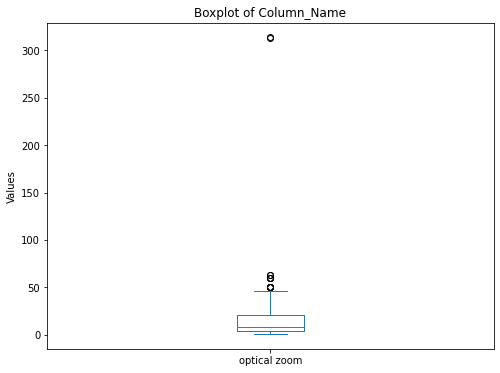

In [462]:
# Create a boxplot for 'Column_Name'
plt.figure(figsize=(8, 6))  # Optional: Set the size of the plot
buy_data_non_null_columns['optical zoom'].plot(kind='box')
plt.title('Boxplot of Column_Name')
plt.ylabel('Values')
plt.show()

In [466]:
buzzillions_data_non_null_columns['optical zoom'].min()

2.0

In [425]:
buzzillions_data_non_null_columns.head(3)

,key,source,famer_brand_list,famer_model_list,famer_product_name,famer_weight,optical zoom,digital zoom,height,width,megapixels,sensor,famer_mpn_list,famer_ean_list,price range,skuprice,still image resolution max
159,5f3ba61e3fd5b671b2200805,www.buzzillions.com,ge,x500bk,geappliancepowerprox500bk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"214698\,x500bk\,x500bktru",x500bk,NaN,149.9900,NaN
160,5f3ba61e3fd5b671b220080f,www.buzzillions.com,panasonic,dmczs25,panasoniclumixdmczs25885170117549qz452324,NaN,20,NaN,NaN,NaN,16 Megapixels,CMOS,"""280891""\,""318805 silver""\,""qz452324""\,""885170...","""qz452324""\,""885170117549""",NaN,299.9900,NaN
161,5f3ba61e3fd5b671b2200817,www.buzzillions.com,fujifilm,xp100,fujifilmfinepixxp100,NaN,5,NaN,NaN,NaN,14,CMOS,NaN,NaN,NaN,NaN,NaN


In [468]:
# Calculate the percentage of rows with NaN values in 'Column_Name'
nan_percentage = (buzzillions_data_non_null_columns['optical zoom'].isna().sum() / len(buzzillions_data_non_null_columns)) * 100
nan_percentage

22.235576923076923

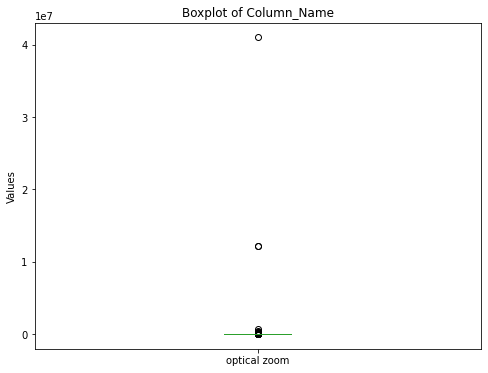

In [469]:
# Create a boxplot for 'Column_Name'
plt.figure(figsize=(8, 6))  # Optional: Set the size of the plot
buzzillions_data_non_null_columns['optical zoom'].plot(kind='box')
plt.title('Boxplot of Column_Name')
plt.ylabel('Values')
plt.show()

In [511]:
from scipy.stats import ks_2samp
ks_2samp(buy_data_non_null_columns['optical zoom'], eglobalcentral_data_non_null_columns['optical zoom'])

KstestResult(statistic=0.5546015877683035, pvalue=9.358825253242367e-36)

In [517]:
eglobalcentral_data_non_null_columns['optical zoom'].max()

30.0

In [518]:
buy_data_non_null_columns.loc[buy_data_non_null_columns['optical zoom']==313.72]

,key,source,famer_brand_list,famer_model_list,famer_product_name,weight,digital zoom,optical zoom,depth,height,width,effective megapixels,image sensor,maximum video capture resolution,vwidth
65,5f3ba61e3fd5b671b220037c,buy.net,nikon,j1,nikonj1,0.52,NaN,313.72,1.2,2.4,NaN,10.1 Megapixel,CMOS,1920 x 1080,4.2


In [476]:
# Find the intersection between 'Column1' and 'Column2'
intersection_set = set(buy_data_non_null_columns['famer_product_name']).intersection(buzzillions_data_non_null_columns['famer_product_name'])
# Convert the intersection set to a list (optional)
intersection_list = list(intersection_set)
# Print the intersection set and list
print("Intersection List:", len(intersection_list))
      
      
      

Intersection List: 29


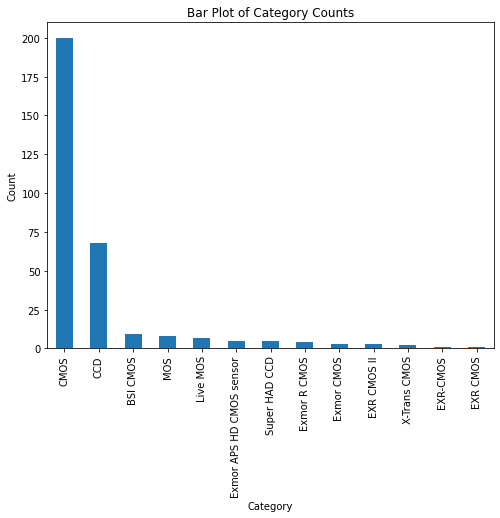

In [482]:
# Count the occurrences of each unique value in 'Column_Name'
value_counts = buy_data_non_null_columns['image sensor'].value_counts()

# Create a bar plot based on the value counts
plt.figure(figsize=(8, 6))  # Optional: Set the size of the plot
value_counts.plot(kind='bar')
plt.title('Bar Plot of Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

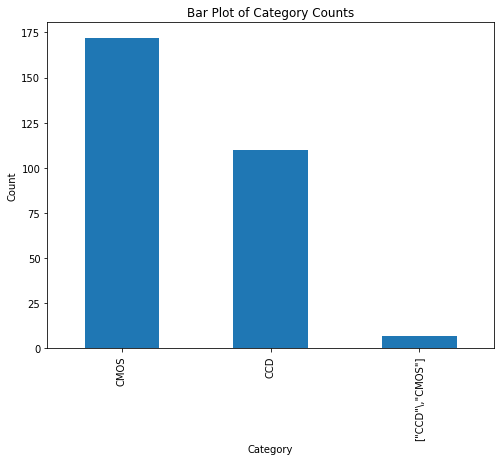

In [483]:
# Count the occurrences of each unique value in 'Column_Name'
value_counts = buzzillions_data_non_null_columns['sensor'].value_counts()

# Create a bar plot based on the value counts
plt.figure(figsize=(8, 6))  # Optional: Set the size of the plot
value_counts.plot(kind='bar')
plt.title('Bar Plot of Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [ ]:
import pandas as pd

# Define cleaning functions for each source with their specific important features
def clean_priceme_data(data):
    # Cleaning logic for www.priceme.co.nz data using specific important features
    data.to_csv('priceme_data_cleaned.csv', index=False)

def clean_buy_data(data):
    # Cleaning logic for buy.net data using specific important features
    numeric_columns = ['digital zoom', 'optical zoom', 'depth', 'height', 'width']
    clean_numeric_columns(data, numeric_columns)

    # Convert weight from grams to pounds
    data['weight'] = data['weight'].apply(convert_to_pounds)

    # Drop rows with any null values in the cleaned data
    data = data.dropna()

    # Save cleaned buy data to CSV
    data.to_csv('buy_data_cleaned.csv', index=False)

    


def clean_data(data):
    
    # Define important features for each source in a dictionary
    source_features = {
        'www.priceme.co.nz': ['key', 'source', 'famer_brand_list', 'famer_model_list', 'famer_product_name'],
        'buy.net': ['key', 'source', 'famer_brand_list', 'famer_model_list', 'famer_product_name', 
                    'weight', 'digital zoom', 'optical zoom', 'depth', 'height', 'width', 
                    'effective megapixels', 'image sensor', 'maximum video capture resolution'],
        # Add more sources and their respective features here
    }

    # Dictionary to store cleaning functions for each source
    cleaning_functions = {
        'www.priceme.co.nz': clean_priceme_data,
        'buy.net': clean_buy_data
    }

    # Clean data based on source
    for source, cleaning_function in cleaning_functions.items():
        data = data[data['source'] == source]
        data_important_features = source_features[source]
        data_cleaned = data[data_important_features].dropna(how='all')
        cleaned_source_data = cleaning_function(data_cleaned)
         

def main():
    # Read data
    data = pd.read_csv('data_cleaned_very_new.csv')  # Replace 'input_data.csv' with the actual path to your input data file
    
    # Clean data
    cleaned_data = clean_data(data)
    
   
main()


# Test the Length of the data

In [1]:
import os
path_to_working_dir = '/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/'
path_to_data_folder = path_to_working_dir + 'data/'
path_to_cleaned_data =  path_to_data_folder + 'sim_dataframes/'
# Get a list of all CSV files in the folder 
csv_files = [file for file in os.listdir(path_to_cleaned_data) if file.endswith('.csv')]

print(len(csv_files))

146


In [ ]:
146 * 146 = 21316

In [5]:
len(set(csv_files))

146